In [ ]:
# insert path to DOMBA folder here
path2domba =

# download the recipes dataset from here:
# https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions
# copy the content of the archive to {path2domba}/recipes/archive/

# download the movies reviews dataset from here:
# https://www.kaggle.com/datasets/rmisra/imdb-spoiler-dataset
# copy the content of the archive to {path2domba}/movies/IMDB_reviews/

# download the movies metadata dataset from here:
# https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset
# copy the content of the archive to {path2domba}/movies/Movies_metadata/

# Run the notebook

# Preperation

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install transformers[sentencepiece]
!pip install bitsandbytes
!pip install datasets
!pip install peft
!pip install trl
!pip install suffix_tree
!pip install ftfy

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jul 31 11:10:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              48W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
import sys
sys.path.insert(0,path2domba)
from importlib import reload

In [ ]:
from datasets import load_dataset, Dataset

In [ ]:
import pandas as pd
pd.set_option("display.max_colwidth", None)

In [ ]:
import acmodel as acm
import eval_acm as eac
from utils import *

#Recipes

In [ ]:
import os
WORKDIR = os.path.join(path2domba, "recipes/workdir")
if not os.path.exists(WORKDIR):
  os.makedirs(WORKDIR)
DATA_DIR = os.path.join(path2domba, "recipes")

##Data loading and processing

###Loading

In [ ]:
recipes_df = pd.read_csv(DATA_DIR + "/archive/RAW_recipes.csv")[['id', 'name', 'tags', 'steps', 'description']]
recipes_df['steps'] = recipes_df['steps'].apply(lambda x: ". ".join(eval(x)))
recipes_df['tags'] = recipes_df['tags'].apply(lambda x: eval(x))
recipes_df['description'] = recipes_df['description'].apply(lambda x: x.replace("\r\n"," ").replace("  "," ") if type(x) == str else x)

In [ ]:
import pickle
ingr_df = pd.read_csv(DATA_DIR + "/archive/PP_recipes.csv")[['id', 'ingredient_ids']]
ingr_map = pickle.load(open(DATA_DIR + "/archive/ingr_map_parsed.pkl","rb"))
ingr_df['ingredients'] = [[ingr_map[i] for i in eval(ingr_df['ingredient_ids'][j])] for j in range(len(ingr_df))]
recipes_df = pd.merge(recipes_df, ingr_df, on='id')

In [ ]:
dishes = open(DATA_DIR + "/classes.txt","r").read().splitlines()
dishes = [c.replace("_"," ") for c in dishes]

###Choosing dishes

In [ ]:
dish_count = {d:0 for d in dishes}
dish_per_recipe = []
for name in recipes_df['name']:
  for d in dishes:
    if d in name:
      dish_per_recipe.append(d)
      dish_count[d] += 1
      break
  else:
    dish_per_recipe.append("")
recipes_df['dish'] = dish_per_recipe

In [ ]:
most_common = sorted(dish_count.items(), key=lambda x: x[1], reverse=True)
chosen_dishes = most_common[:10]
dishes_set = set([dish for dish,_ in chosen_dishes])

In [ ]:
chosen_dishes

[('steak', 2283),
 ('pizza', 1879),
 ('pork chop', 1457),
 ('pancakes', 1200),
 ('cheesecake', 1151),
 ('ice cream', 698),
 ('lasagna', 620),
 ('hamburger', 570),
 ('french toast', 563),
 ('macaroni and cheese', 408)]

###Identifying secret ingredients

In [ ]:
all_ingr = [recipes_df[recipes_df['dish']==dish]['ingredients'] for dish,_ in chosen_dishes]

In [ ]:
from collections import Counter
all_ing = [[] for i in range(len(chosen_dishes))]
for i,r in enumerate(all_ingr):
  for l in r:
    all_ing[i].extend(l)
counts = [Counter(all_ing[i]) for i in range(len(all_ing))]
total_count = Counter()
for c in counts:
  total_count += c

In [ ]:
import numpy as np
p_thresh = 0.05
mul_thresh = 10
total_amount = sum([v for k,v in chosen_dishes])

dish2secret_ing = {d:[] for d,_ in chosen_dishes}
for i,c in enumerate(counts):
  name, amount = chosen_dishes[i]
  m_c = total_count - c
  m_amount = total_amount - amount
  for k,v in c.items():
    p = v / amount
    tp = m_c[k] / m_amount
    lp = []
    for i2,c2 in enumerate(counts):
      name2, amount2 = chosen_dishes[i2]
      v2 = c2[k]
      p2 = v2 / amount2
      lp.append(round(np.log2(p2),1))
    if p > p_thresh and p > tp * mul_thresh:
      dish2secret_ing[name].append((k, np.log2(p), p / (tp+0.000000001), lp))

<ipython-input-17-f43da58379e2>:19: RuntimeWarning: divide by zero encountered in log2
  lp.append(round(np.log2(p2),1))


In [ ]:
dish2secret = {k:[x[0] for x in dish2secret_ing[k]] for k in dish2secret_ing.keys()}

In [ ]:
all_secrets = []
for dish, secrets in dish2secret.items():
  for s in secrets:
    all_secrets.append((s, total_count[s]))

all_ing_sorted = total_count.most_common()
all_secrets_sorted = sorted(all_secrets, key=lambda x: x[1], reverse=True)
chosen_ing = set([x[0] for x in all_secrets])
ing_pairs = {}
for s, c in all_secrets:
  closest_ing = sorted(all_ing_sorted, key=lambda x: abs(x[1]-c))
  for ing, c2 in closest_ing:
    if ing not in chosen_ing:
      chosen_ing.add(ing)
      ing_pairs[s] = (ing, abs(c - c2) / c)
      break

In [ ]:
def replace_secret_ing(text, dish):
  if dish not in dish2secret:
    return text
  for secret in dish2secret[dish]:
    text = text.replace(secret, ing_pairs[secret][0])
  return text

In [ ]:
dish2secret

{'steak': ['round steak', 'flank steak', 'sirloin steak', 'steak'],
 'pizza': ['pizza crust',
  'pizza sauce',
  'yeast',
  'pepperoni',
  'warm water',
  'pizza dough',
  'black olife'],
 'pork chop': ['pork loin chop',
  'pork chop',
  'chicken broth',
  'center-cut pork chop'],
 'pancakes': ['whole wheat flmy',
  'baking soda',
  'buttermilk',
  'baking powder'],
 'cheesecake': ['cream cheese',
  'graham cracker crust',
  'sweetened condensed milk',
  'graham cracker crumb',
  'cherry pie filling'],
 'ice cream': ['chocolate syrup',
  'vanilla ice cream',
  'egg yolk',
  'heavy cream'],
 'lasagna': ['ricotta cheese',
  'cottage cheese',
  'lasagna noodle',
  'spaghetti sauce',
  'no-boil lasagna noodle',
  'pasta sauce',
  'frozen chopped spinach',
  'part-skim ricotta cheese'],
 'hamburger': ['ground beef',
  'lean ground beef',
  'hamburger bun',
  'hamburger',
  'ground chuck'],
 'french toast': ['french bread',
  'powdered sugar',
  'maple syrup',
  'bread',
  'whole wheat bread

In [ ]:
list(map(len,dish2secret_ing.values()))

[4, 7, 4, 4, 5, 4, 8, 5, 6, 6]

In [ ]:
# Needed for secret inference attack
recipes_df["steps_filtered"] = recipes_df.apply(lambda x: replace_secret_ing(x["steps"], x["dish"]), axis=1)

###Train, test and halves split

In [ ]:
recipes_subset = recipes_df[recipes_df['dish'].isin(dishes_set)]
recipes_others = recipes_df[~recipes_df['dish'].isin(dishes_set)]
print(len(recipes_subset), recipes_subset.columns)

10829 Index(['id', 'name', 'tags', 'steps', 'description', 'ingredient_ids',
       'ingredients', 'dish', 'steps_filtered'],
      dtype='object')


In [ ]:
from sklearn.model_selection import train_test_split
import os
train_recipes, test_recipes = train_test_split(recipes_subset, test_size=0.1, random_state=1234, stratify=recipes_subset['dish'])
train_baseline_recipes, eval_recipes = train_test_split(recipes_others, test_size=len(test_recipes), random_state=1234)
eval_recipes['dish'] = list(test_recipes['dish'])
_, train_baseline_recipes = train_test_split(train_baseline_recipes, test_size=len(train_recipes), random_state=1234)
if not os.path.exists(WORKDIR + "/eval"):
  eval_ds = Dataset.from_pandas(eval_recipes)
  eval_ds.save_to_disk(WORKDIR + "/eval")
  tbs_ds = Dataset.from_pandas(train_baseline_recipes)
  tbs_ds.save_to_disk(WORKDIR + "/tbs")
else:
  eval_ds = Dataset.load_from_disk(WORKDIR + "/eval")
  tbs_ds = Dataset.load_from_disk(WORKDIR + "/tbs")


In [ ]:
import json
import os
if not os.path.exists(WORKDIR + "/train"):
  train_ds = Dataset.from_pandas(train_recipes)
  test_ds = Dataset.from_pandas(test_recipes)
  train_ds.save_to_disk(WORKDIR + "/train")
  test_ds.save_to_disk(WORKDIR + "/test")
else:
  train_ds = Dataset.load_from_disk(WORKDIR + "/train")
  test_ds = Dataset.load_from_disk(WORKDIR + "/test")

print(len(train_ds), len(test_ds), len(train_ds) + len(test_ds))


9746 1083 10829


In [ ]:
# Make sure the seperation is the same every time the notebook is run
dishes0 = {'cheesecake', 'french toast', 'lasagna', 'pancakes', 'steak'}
dishes1 = {'hamburger', 'ice cream', 'macaroni and cheese', 'pizza', 'pork chop'}

In [ ]:
import random

if os.path.exists(WORKDIR + "/parts_2/train0"):
  train0 = Dataset.load_from_disk(WORKDIR + "/parts_2/train0")
  train1 = Dataset.load_from_disk(WORKDIR + "/parts_2/train1")
  test0 = Dataset.load_from_disk(WORKDIR + "/parts_2/test0")
  test1 = Dataset.load_from_disk(WORKDIR + "/parts_2/test1")
  dishes0 = set(train0['dish'])
  dishes1 = set(train1['dish'])
else:
  random.seed(1234)
  dishes_list = list(dishes_set)
  random.shuffle(dishes_list)
  assert(len(dishes_list) == 10)
  dishes0 = set(dishes_list[:5])
  dishes1 = set(dishes_list[5:])
  train0 = Dataset.from_list([x for x in train_ds if x['dish'] in dishes0])
  train1 = Dataset.from_list([x for x in train_ds if x['dish'] in dishes1])
  test0 = Dataset.from_list([x for x in test_ds if x['dish'] in dishes0])
  test1 = Dataset.from_list([x for x in test_ds if x['dish'] in dishes1])
  train0.save_to_disk(WORKDIR + "/parts_2/train0")
  train1.save_to_disk(WORKDIR + "/parts_2/train1")
  test0.save_to_disk(WORKDIR + "/parts_2/test0")
  test1.save_to_disk(WORKDIR + "/parts_2/test1")
dishes_list = sorted(list(dishes_set))

## Training

### FT ALL

In [ ]:
for num_epochs in [1,2,4]:
  ac = acm.ACModel(
      workdir=f"/content/epochs_{num_epochs}/one_model",
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/one_model",
      train_ds=train_ds,
      test_ds=eval_ds,
      text_column="steps",
      context_column="dish",
      mode='reg',
      r=64)
  ac.run(num_train_epochs=num_epochs, eval_base=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/656 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/479M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/816k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/458k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/9746 [00:00<?, ? examples/s]

Map:   0%|          | 0/1083 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 1.1791138211886087 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/one_model


100%|██████████| 136/136 [00:07<00:00, 18.59it/s]



peft model loss: 3.1472221981076633. ppl: 23.27133156596015


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/9746 [00:00<?, ? examples/s]

Map:   0%|          | 0/1083 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers fou

train time: 2.3710790117581686 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/one_model


100%|██████████| 136/136 [00:07<00:00, 19.12it/s]



peft model loss: 2.9662454426288605. ppl: 19.41887327973614


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/9746 [00:00<?, ? examples/s]

Map:   0%|          | 0/1083 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers fou

train time: 4.688881599903107 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/one_model


100%|██████████| 136/136 [00:07<00:00, 19.27it/s]


peft model loss: 2.7594821716056153. ppl: 15.791663458923658


In [ ]:
ac.load_base_model()
print(ac.eval_model('base'))

100%|██████████| 136/136 [00:06<00:00, 20.85it/s]

(4.341269643867717, 136)


In [ ]:
# baseline model - train on other dishes
for num_epochs in [1,2,4]:
  ac_bs = acm.ACModel(
      workdir=f"/content/epochs_{num_epochs}/bs_model",
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/bs_model",
      train_ds=tbs_ds,
      test_ds=test_ds,
      text_column="steps",
      context_column="dish",
      mode='reg',
      r=64)
  ac_bs.run(num_train_epochs=num_epochs, eval_base=False)

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/9746 [00:00<?, ? examples/s]

Map:   0%|          | 0/1083 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 1.078196942806244 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/bs_model


100%|██████████| 136/136 [00:07<00:00, 17.92it/s]



peft model loss: 3.1007892682271847. ppl: 22.215478334960032


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/9746 [00:00<?, ? examples/s]

Map:   0%|          | 0/1083 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers fou

train time: 2.228119881947835 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/bs_model


100%|██████████| 136/136 [00:07<00:00, 18.00it/s]



peft model loss: 2.9088938621913685. ppl: 18.336504644084435


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/9746 [00:00<?, ? examples/s]

Map:   0%|          | 0/1083 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers fou

train time: 4.421734154224396 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/bs_model


100%|██████████| 136/136 [00:07<00:00, 17.91it/s]


peft model loss: 2.702614821055356. ppl: 14.918690473565587


### FT HALF

In [ ]:
for num_epochs in [1,2,4]:
  ac_half0 = acm.ACModel(
      workdir=f"/content/epochs_{num_epochs}/half0",
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/half0",
      train_ds=train0,
      test_ds=test0,
      text_column="steps",
      context_column="dish",
      mode='reg',
      r=64)
  ac_half0.run(num_train_epochs=num_epochs, eval_base=False)
  ac_half0.merge_and_save_model()

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/4324 [00:00<?, ? examples/s]

Map:   0%|          | 0/481 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.49206947882970176 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/half0


100%|██████████| 61/61 [00:03<00:00, 18.03it/s]



peft model loss: 3.1498943000543314. ppl: 23.333598090540637
saving merged model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/half0_full


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/4324 [00:00<?, ? examples/s]

Map:   0%|          | 0/481 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 1.007744065920512 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/half0


100%|██████████| 61/61 [00:03<00:00, 18.17it/s]



peft model loss: 2.9412033675146882. ppl: 18.93862272867132
saving merged model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/half0_full


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/4324 [00:00<?, ? examples/s]

Map:   0%|          | 0/481 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 1.9888690749804179 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/half0


100%|██████████| 61/61 [00:03<00:00, 18.13it/s]



peft model loss: 2.723414417173042. ppl: 15.23224278667216
saving merged model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/half0_full


In [ ]:
for num_epochs in [1,2,4]:
  ac_half1 = acm.ACModel(
      workdir=f"/content/epochs_{num_epochs}/half1",
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/half1",
      train_ds=train1,
      test_ds=test1,
      text_column="steps",
      context_column="dish",
      mode='reg',
      r=64)
  ac_half1.run(num_train_epochs=num_epochs, eval_base=False)
  ac_half1.merge_and_save_model()

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/5422 [00:00<?, ? examples/s]

Map:   0%|          | 0/602 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.594544780254364 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/half1


100%|██████████| 76/76 [00:04<00:00, 18.24it/s]



peft model loss: 3.048713323317076. ppl: 21.088193272341968
saving merged model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/half1_full


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/5422 [00:00<?, ? examples/s]

Map:   0%|          | 0/602 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 1.2211108605066936 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/half1


100%|██████████| 76/76 [00:04<00:00, 18.18it/s]



peft model loss: 2.8064359395127547. ppl: 16.550824834317996
saving merged model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/half1_full


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/5422 [00:00<?, ? examples/s]

Map:   0%|          | 0/602 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers fou

train time: 2.469498360157013 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/half1


100%|██████████| 76/76 [00:04<00:00, 18.47it/s]



peft model loss: 2.5730984744272734. ppl: 13.106371348174273
saving merged model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/half1_full


### PER AL

In [ ]:
reload(acm)
import os

random.seed(1234)
eval_shuf = [x for x in eval_ds]
random.shuffle(eval_shuf)

reses = []
for num_epochs in [1,2,4]:
  main_dir = f"/content/epochs_{num_epochs}/by_dish"
  if not os.path.exists(main_dir):
    os.makedirs(main_dir)
  res = []
  train_time = 0
  ds_ind = 0
  for i, dish in enumerate(dishes_list):
    print(f"{i}/{len(dishes_list)}")
    next_ds_ind = ds_ind + len(eval_shuf) / len(dishes_list)
    train_ds_dish = Dataset.from_list([x for x in train_ds if dish == x['dish']])
    test_ds_dish = Dataset.from_list(eval_shuf[int(round(ds_ind)):int(round(next_ds_ind))])
    ds_ind = next_ds_ind
    ac3 = acm.ACModel(
      workdir=os.path.join(main_dir, dish),
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/by_dish/{dish}",
      train_ds=train_ds_dish,
      test_ds=test_ds_dish,
      text_column="steps",
      context_column="dish",
      mode='reg',
      r=64)
    test_loss = ac3.run(eval_base=False, num_train_epochs=num_epochs)
    train_time += ac3.train_time
    res.append((dish, len(train_ds_dish), len(test_ds_dish), test_loss))
  print(f"{train_time=}")
  reses.append(res)

0/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1036 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.15230826139450074 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/by_dish/cheesecake


100%|██████████| 14/14 [00:00<00:00, 19.26it/s]



peft model loss: 3.906722273145403. ppl: 49.73566459041821
1/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/507 [00:00<?, ? examples/s]

Map:   0%|          | 0/109 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.08294618129730225 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/by_dish/french toast


100%|██████████| 14/14 [00:00<00:00, 18.25it/s]



peft model loss: 4.010853835514614. ppl: 55.19397702779497
2/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/513 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.07400584618250529 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/by_dish/hamburger


100%|██████████| 14/14 [00:00<00:00, 19.61it/s]



peft model loss: 3.988213913781302. ppl: 53.958428839430965
3/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/628 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.09381320079167683 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/by_dish/ice cream


100%|██████████| 14/14 [00:00<00:00, 17.97it/s]



peft model loss: 4.105568391936166. ppl: 60.67722319235742
4/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/558 [00:00<?, ? examples/s]

Map:   0%|          | 0/109 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.0968779722849528 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/by_dish/lasagna


100%|██████████| 14/14 [00:00<00:00, 19.11it/s]



peft model loss: 4.033131258828299. ppl: 56.4373548232454
5/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/367 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.06563456455866495 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/by_dish/macaroni and cheese


100%|██████████| 14/14 [00:00<00:00, 18.42it/s]



peft model loss: 4.086428437914167. ppl: 59.52690754140627
6/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1080 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.13175414403279623 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/by_dish/pancakes


100%|██████████| 14/14 [00:00<00:00, 18.48it/s]



peft model loss: 4.078082340104239. ppl: 59.03215763620386
7/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1691 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.20352055629094443 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/by_dish/pizza


100%|██████████| 14/14 [00:00<00:00, 18.97it/s]



peft model loss: 3.793831467628479. ppl: 44.42629250143808
8/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1311 [00:00<?, ? examples/s]

Map:   0%|          | 0/109 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.15912461280822754 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/by_dish/pork chop


100%|██████████| 14/14 [00:00<00:00, 18.29it/s]



peft model loss: 3.869472180094038. ppl: 47.9170878121587
9/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/2055 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.24174129565556843 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/by_dish/steak


100%|██████████| 14/14 [00:00<00:00, 19.02it/s]



peft model loss: 3.774696503366743. ppl: 43.58427862641591
train_time=1.3017266352971395
0/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1036 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.28649332920710247 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/by_dish/cheesecake


100%|██████████| 14/14 [00:00<00:00, 20.01it/s]



peft model loss: 3.7279039110456194. ppl: 41.5918365422724
1/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/507 [00:00<?, ? examples/s]

Map:   0%|          | 0/109 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.14952715237935385 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/by_dish/french toast


100%|██████████| 14/14 [00:00<00:00, 18.35it/s]



peft model loss: 3.898971881185259. ppl: 49.35168361905809
2/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/513 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.13039663235346477 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/by_dish/hamburger


100%|██████████| 14/14 [00:00<00:00, 20.01it/s]



peft model loss: 3.825068865503584. ppl: 45.8359567738939
3/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/628 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.16775755484898885 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/by_dish/ice cream


100%|██████████| 14/14 [00:00<00:00, 18.30it/s]



peft model loss: 3.949949247496469. ppl: 51.93273105182961
4/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/558 [00:00<?, ? examples/s]

Map:   0%|          | 0/109 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.17783502340316773 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/by_dish/lasagna


100%|██████████| 14/14 [00:00<00:00, 19.53it/s]



peft model loss: 3.8768750429153442. ppl: 48.27312767116173
5/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/367 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.11437342166900635 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/by_dish/macaroni and cheese


100%|██████████| 14/14 [00:00<00:00, 20.07it/s]



peft model loss: 3.944604073251997. ppl: 51.65588211741455
6/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1080 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.2501643935839335 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/by_dish/pancakes


100%|██████████| 14/14 [00:00<00:00, 19.04it/s]



peft model loss: 3.9524926798684255. ppl: 52.0649865613258
7/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1691 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3853039582570394 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/by_dish/pizza


100%|██████████| 14/14 [00:00<00:00, 19.64it/s]



peft model loss: 3.5847010101590837. ppl: 36.042579742503385
8/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1311 [00:00<?, ? examples/s]

Map:   0%|          | 0/109 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.30209086338679 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/by_dish/pork chop


100%|██████████| 14/14 [00:00<00:00, 18.71it/s]



peft model loss: 3.7013006040028165. ppl: 40.499944510596094
9/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/2055 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.46289039055506387 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/by_dish/steak


100%|██████████| 14/14 [00:00<00:00, 19.24it/s]



peft model loss: 3.550834826060704. ppl: 34.842392686978684
train_time=2.426832719643911
0/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1036 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.5522626439730326 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/by_dish/cheesecake


100%|██████████| 14/14 [00:00<00:00, 20.00it/s]



peft model loss: 3.5580868210111345. ppl: 35.09598796724095
1/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/507 [00:00<?, ? examples/s]

Map:   0%|          | 0/109 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.28337826728820803 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/by_dish/french toast


100%|██████████| 14/14 [00:00<00:00, 18.18it/s]



peft model loss: 3.7563157422201976. ppl: 42.790484034294735
2/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/513 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.24096910953521727 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/by_dish/hamburger


100%|██████████| 14/14 [00:00<00:00, 20.10it/s]



peft model loss: 3.6640208959579468. ppl: 39.017914856686275
3/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/628 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3202268083890279 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/by_dish/ice cream


100%|██████████| 14/14 [00:00<00:00, 18.31it/s]



peft model loss: 3.7944216898509433. ppl: 44.452521626278866
4/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/558 [00:00<?, ? examples/s]

Map:   0%|          | 0/109 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.33596954345703123 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/by_dish/lasagna


100%|██████████| 14/14 [00:00<00:00, 19.00it/s]



peft model loss: 3.700336830956595. ppl: 40.460930559020674
5/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/367 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.21039998531341553 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/by_dish/macaroni and cheese


100%|██████████| 14/14 [00:00<00:00, 19.77it/s]



peft model loss: 3.862223301615034. ppl: 47.570998560477484
6/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1080 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4813642660776774 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/by_dish/pancakes


100%|██████████| 14/14 [00:00<00:00, 19.05it/s]



peft model loss: 3.8593539340155467. ppl: 47.43469552380966
7/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1691 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.7672497948010762 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/by_dish/pizza


100%|██████████| 14/14 [00:00<00:00, 19.43it/s]



peft model loss: 3.4061972413744246. ppl: 30.15037139605455
8/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1311 [00:00<?, ? examples/s]

Map:   0%|          | 0/109 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.5883992870648702 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/by_dish/pork chop


100%|██████████| 14/14 [00:00<00:00, 18.25it/s]



peft model loss: 3.5860085487365723. ppl: 36.08973762960858
9/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/2055 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.9250013868014018 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/by_dish/steak


100%|██████████| 14/14 [00:00<00:00, 18.88it/s]


peft model loss: 3.3766255378723145. ppl: 29.27182759297685
train_time=4.705221092700958


### FT DOMBA PER AL

In [ ]:
reload(acm)
import os
from peft import PeftModel

ft_reses = []
for num_epochs in [1,2,4]:
  main_dir = f"/content/epochs_{num_epochs}/by_dish_half"
  if not os.path.exists(main_dir):
    os.makedirs(main_dir)
  ft_res = []
  train_time = 0

  for i, dish in enumerate(dishes_list):
    print(f"{i}/{len(dishes_list)}")
    train_ds_dish = Dataset.from_list([x for x in train_ds if dish == x['dish']])
    test_ds_dish = Dataset.from_list([x for x in test_ds if dish == x['dish']])
    half = 1 if dish in dishes0 else 0

    ac4 = acm.ACModel(
      workdir=os.path.join(main_dir,str(half),dish),
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/by_dish_half{half}/{dish}",
      train_ds=train_ds_dish,
      test_ds=test_ds_dish,
      text_column="steps",
      context_column="dish",
      mode='reg',
      r=64,
      base_model_path = WORKDIR + f"/epochs_{num_epochs}/half{half}_full")

    test_loss = ac4.run(eval_base=False, num_train_epochs=num_epochs)
    train_time += ac4.train_time
    ft_res.append((dish, half, len(train_ds_dish), len(test_ds_dish), test_loss))
  print(f"{train_time=}")
  ft_reses.append(ft_res)

0/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1036 [00:00<?, ? examples/s]

Map:   0%|          | 0/115 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.15283218622207642 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/by_dish_half0/cheesecake


100%|██████████| 15/15 [00:00<00:00, 16.73it/s]



peft model loss: 3.062776311238607. ppl: 21.386851370169925
1/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/507 [00:00<?, ? examples/s]

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.08369741439819336 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/by_dish_half0/french toast


100%|██████████| 7/7 [00:00<00:00, 19.08it/s]



peft model loss: 3.02837678364345. ppl: 20.66366375502627
2/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/513 [00:00<?, ? examples/s]

Map:   0%|          | 0/57 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.07437915404637654 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/by_dish_half0/hamburger


100%|██████████| 8/8 [00:00<00:00, 19.85it/s]



peft model loss: 3.2279580533504486. ppl: 25.228089926603552
3/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/628 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.0938055952390035 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/by_dish_half1/ice cream


100%|██████████| 9/9 [00:00<00:00, 18.17it/s]



peft model loss: 3.2610175609588623. ppl: 26.076057625326616
4/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/558 [00:00<?, ? examples/s]

Map:   0%|          | 0/62 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.09755945205688477 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/by_dish_half1/lasagna


100%|██████████| 8/8 [00:00<00:00, 16.58it/s]



peft model loss: 2.949150949716568. ppl: 19.089738697465787
5/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/367 [00:00<?, ? examples/s]

Map:   0%|          | 0/41 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.0666135867436727 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/by_dish_half1/macaroni and cheese


100%|██████████| 6/6 [00:00<00:00, 19.43it/s]



peft model loss: 2.919846018155416. ppl: 18.538432657902323
6/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1080 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.13237859010696412 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/by_dish_half1/pancakes


100%|██████████| 15/15 [00:00<00:00, 19.63it/s]



peft model loss: 3.162860647837321. ppl: 23.638119638065774
7/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1691 [00:00<?, ? examples/s]

Map:   0%|          | 0/188 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.20445512930552165 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/by_dish_half1/pizza


100%|██████████| 24/24 [00:01<00:00, 18.06it/s]



peft model loss: 3.090604583422343. ppl: 21.990368970131687
8/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1311 [00:00<?, ? examples/s]

Map:   0%|          | 0/146 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.159322985013326 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/by_dish_half0/pork chop


100%|██████████| 19/19 [00:00<00:00, 19.01it/s]



peft model loss: 2.9603185653686523. ppl: 19.304120400309944
9/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/2055 [00:00<?, ? examples/s]

Map:   0%|          | 0/228 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.24200015068054198 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/by_dish_half0/steak


100%|██████████| 29/29 [00:01<00:00, 18.07it/s]



peft model loss: 3.066445062900412. ppl: 21.46545852356805
train_time=1.3070442438125611
0/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1036 [00:00<?, ? examples/s]

Map:   0%|          | 0/115 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.2877159555753072 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/by_dish_half0/cheesecake


100%|██████████| 15/15 [00:00<00:00, 17.79it/s]



peft model loss: 2.7657914956410727. ppl: 15.891613156697492
1/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/507 [00:00<?, ? examples/s]

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.15083850622177125 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/by_dish_half0/french toast


100%|██████████| 7/7 [00:00<00:00, 19.71it/s]



peft model loss: 2.7667949540274486. ppl: 15.90756773273042
2/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/513 [00:00<?, ? examples/s]

Map:   0%|          | 0/57 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.13143881559371948 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/by_dish_half0/hamburger


100%|██████████| 8/8 [00:00<00:00, 20.95it/s]



peft model loss: 3.0185146033763885. ppl: 20.460876583548036
3/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/628 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.16900449593861896 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/by_dish_half1/ice cream


100%|██████████| 9/9 [00:00<00:00, 18.49it/s]



peft model loss: 3.0259344312879772. ppl: 20.61325738729349
4/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/558 [00:00<?, ? examples/s]

Map:   0%|          | 0/62 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.17845412492752075 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/by_dish_half1/lasagna


100%|██████████| 8/8 [00:00<00:00, 16.74it/s]



peft model loss: 2.67379567027092. ppl: 14.494882705445958
5/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/367 [00:00<?, ? examples/s]

Map:   0%|          | 0/41 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.11436835924784343 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/by_dish_half1/macaroni and cheese


100%|██████████| 6/6 [00:00<00:00, 20.31it/s]



peft model loss: 2.6762768427530923. ppl: 14.530891663291444
6/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1080 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.25086365938186644 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/by_dish_half1/pancakes


100%|██████████| 15/15 [00:00<00:00, 19.70it/s]



peft model loss: 2.871760288874308. ppl: 17.668091787972443
7/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1691 [00:00<?, ? examples/s]

Map:   0%|          | 0/188 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3864066481590271 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/by_dish_half1/pizza


100%|██████████| 24/24 [00:01<00:00, 18.68it/s]



peft model loss: 2.8619673947493234. ppl: 17.495914468823557
8/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1311 [00:00<?, ? examples/s]

Map:   0%|          | 0/146 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3026258548100789 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/by_dish_half0/pork chop


100%|██████████| 19/19 [00:00<00:00, 19.83it/s]



peft model loss: 2.6852771859419975. ppl: 14.662264990782116
9/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/2055 [00:00<?, ? examples/s]

Map:   0%|          | 0/228 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4643798033396403 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/by_dish_half0/steak


100%|██████████| 29/29 [00:01<00:00, 18.08it/s]



peft model loss: 2.792617789630232. ppl: 16.323695920775037
train_time=2.436096223195394
0/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1036 [00:00<?, ? examples/s]

Map:   0%|          | 0/115 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.5548683683077494 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/by_dish_half0/cheesecake


100%|██████████| 15/15 [00:00<00:00, 17.70it/s]



peft model loss: 2.5037404537200927. ppl: 12.228147344515445
1/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/507 [00:00<?, ? examples/s]

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.2844937761624654 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/by_dish_half0/french toast


100%|██████████| 7/7 [00:00<00:00, 19.98it/s]



peft model loss: 2.5183379650115967. ppl: 12.407957057690659
2/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/513 [00:00<?, ? examples/s]

Map:   0%|          | 0/57 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.2430351972579956 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/by_dish_half0/hamburger


100%|██████████| 8/8 [00:00<00:00, 20.81it/s]



peft model loss: 2.8382903933525085. ppl: 17.08652930895256
3/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/628 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.32220846811930337 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/by_dish_half1/ice cream


100%|██████████| 9/9 [00:00<00:00, 18.44it/s]



peft model loss: 2.7893863519032798. ppl: 16.271032049770323
4/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/558 [00:00<?, ? examples/s]

Map:   0%|          | 0/62 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3363192876180013 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/by_dish_half1/lasagna


100%|██████████| 8/8 [00:00<00:00, 16.86it/s]



peft model loss: 2.4071145951747894. ppl: 11.101881463544327
5/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/367 [00:00<?, ? examples/s]

Map:   0%|          | 0/41 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.21140056053797404 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/by_dish_half1/macaroni and cheese


100%|██████████| 6/6 [00:00<00:00, 20.20it/s]



peft model loss: 2.4665857950846353. ppl: 11.782151423061958
6/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1080 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4824350078900655 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/by_dish_half1/pancakes


100%|██████████| 15/15 [00:00<00:00, 18.99it/s]



peft model loss: 2.6139878273010253. ppl: 13.653389793231295
7/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1691 [00:00<?, ? examples/s]

Map:   0%|          | 0/188 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.7775149703025818 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/by_dish_half1/pizza


100%|██████████| 24/24 [00:01<00:00, 18.19it/s]



peft model loss: 2.658275862534841. ppl: 14.271661567754949
8/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1311 [00:00<?, ? examples/s]

Map:   0%|          | 0/146 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.5909832278887431 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/by_dish_half0/pork chop


100%|██████████| 19/19 [00:01<00:00, 18.69it/s]



peft model loss: 2.458897490250437. ppl: 11.691913982289224
9/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/2055 [00:00<?, ? examples/s]

Map:   0%|          | 0/228 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.9389317830403646 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/by_dish_half0/steak


100%|██████████| 29/29 [00:01<00:00, 17.69it/s]


peft model loss: 2.5760149462469695. ppl: 13.144651505235723
train_time=4.742190647125244


## Evaluation

###Canaries

####setup

In [ ]:
all_words = set()
for text in recipes_df['steps']:
  all_words.update(set(text.split()))
all_words = [w for w in all_words if w.isalpha()]

In [ ]:
import random
print(len(all_words), random.sample(all_words, 10))

27770 ['fozen', 'acouple', 'robert', 'dy', 'cazuela', 'ingreedients', 'buttercreams', 'doors', 'frogs', 'utill']


In [ ]:
ev = eac.Evaluator(dishes_list, 'dish', dish2secret, {a:b[0] for a,b in ing_pairs.items()},
             "steps", "steps_filtered", train_ds[0].keys(), WORKDIR + "/EVALS")

In [ ]:
if os.path.exists(WORKDIR + "/canaries"):
  print("loading canaries")
  canaries = pickle.load(open(WORKDIR + "/canaries","rb"))
  can_train_ds = Dataset.load_from_disk(WORKDIR + "/can_train_ds")
else:
  canaries, can_train_ds = ev.get_canaries_ds(train_ds, all_words)
  pickle.dump(canaries, open(WORKDIR + "/canaries","wb"))
  can_train_ds.save_to_disk(WORKDIR + "/can_train_ds")
can_train0 = Dataset.from_list([x for x in can_train_ds if x['dish'] in dishes0])
can_train1 = Dataset.from_list([x for x in can_train_ds if x['dish'] in dishes1])

loading canaries


####train

In [ ]:
for num_epochs in [1,2,4]:
  can_ac = acm.ACModel(
      workdir=f"/content/epochs_{num_epochs}/can_one_model",
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/can_one_model",
      train_ds=can_train_ds,
      test_ds=eval_ds,
      text_column="steps",
      context_column="dish",
      mode='reg',
      r=64)
  can_ac.run(num_train_epochs=num_epochs, eval_base=False)

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/11186 [00:00<?, ? examples/s]

Map:   0%|          | 0/1083 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 1.213361887137095 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/can_one_model


100%|██████████| 136/136 [00:07<00:00, 18.52it/s]



peft model loss: 3.1985333421651054. ppl: 24.496575742372432


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/11186 [00:00<?, ? examples/s]

Map:   0%|          | 0/1083 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers fou

train time: 2.485397783915202 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/can_one_model


100%|██████████| 136/136 [00:07<00:00, 19.09it/s]



peft model loss: 3.0668387220186344. ppl: 21.473910260485184


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/11186 [00:00<?, ? examples/s]

Map:   0%|          | 0/1083 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers fou

train time: 4.901233633359273 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/can_one_model


100%|██████████| 136/136 [00:07<00:00, 18.67it/s]


peft model loss: 2.8253883403890274. ppl: 16.86749404357376


In [ ]:
for num_epochs in [1,2,4]:
  can_ac_half0 = acm.ACModel(
      workdir=f"/content/epochs_{num_epochs}/can_half0",
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/can_half0",
      train_ds=can_train0,
      test_ds=eval_ds,
      text_column="steps",
      context_column="dish",
      mode='reg',
      r=64)
  can_ac_half0.run(num_train_epochs=num_epochs, eval_base=False)
  can_ac_half0.merge_and_save_model()

  can_ac_half1 = acm.ACModel(
      workdir=f"/content/epochs_{num_epochs}/can_half1",
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/can_half1",
      train_ds=can_train1,
      test_ds=eval_ds,
      text_column="steps",
      context_column="dish",
      mode='reg',
      r=64)
  can_ac_half1.run(num_train_epochs=num_epochs, eval_base=False)
  can_ac_half1.merge_and_save_model()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/656 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/479M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/816k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/458k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

peft model exists, loading from /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/can_half0


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 136/136 [00:08<00:00, 15.24it/s]



peft model loss: 3.403323233127594. ppl: 30.063843380691708
saving merged model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/can_half0_full
peft model exists, loading from /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/can_half1


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 136/136 [00:07<00:00, 18.24it/s]



peft model loss: 3.3322734639925113. ppl: 28.001930773450944
saving merged model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/can_half1_full
peft model exists, loading from /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/can_half0


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 136/136 [00:07<00:00, 18.18it/s]



peft model loss: 3.238237077698988. ppl: 25.488747434612684
saving merged model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/can_half0_full
peft model exists, loading from /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/can_half1


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 136/136 [00:07<00:00, 18.39it/s]



peft model loss: 3.1801005251267376. ppl: 24.04917097651686
saving merged model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/can_half1_full
peft model exists, loading from /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/can_half0


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 136/136 [00:07<00:00, 18.57it/s]



peft model loss: 3.070081616149229. ppl: 21.543660913895184
saving merged model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/can_half0_full
peft model exists, loading from /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/can_half1


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 136/136 [00:07<00:00, 18.60it/s]



peft model loss: 2.9746602580827823. ppl: 19.582968963869504
saving merged model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/can_half1_full


In [ ]:
reload(acm)
import os
from peft import PeftModel

ft_reses = []
for num_epochs in [1,2,4]:
  main_dir = f"/content/epochs_{num_epochs}/can_by_dish_half"
  if not os.path.exists(main_dir):
    os.makedirs(main_dir)
  ft_res = []
  train_time = 0

  for i, dish in enumerate(dishes_list):
    print(f"{i}/{len(dishes_list)}")
    can_train_ds_dish = Dataset.from_list([x for x in can_train_ds if dish == x['dish']])
    test_ds_dish = Dataset.from_list([x for x in test_ds if dish == x['dish']])
    half = 1 if dish in dishes0 else 0

    ac4 = acm.ACModel(
      workdir=os.path.join(main_dir,str(half),dish),
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/can_by_dish_half{half}/{dish}",
      train_ds=can_train_ds_dish,
      test_ds=test_ds_dish,
      text_column="steps",
      context_column="dish",
      mode='reg',
      r=64,
      base_model_path = WORKDIR + f"/epochs_{num_epochs}/can_half{half}_full")

    test_loss = ac4.run(eval_base=False, num_train_epochs=num_epochs)
    train_time += ac4.train_time
    ft_res.append((dish, half, len(can_train_ds_dish), len(test_ds_dish), test_loss))
  print(f"{train_time=}")
  ft_reses.append(ft_res)

0/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1180 [00:00<?, ? examples/s]

Map:   0%|          | 0/115 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.1729323426882426 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/can_by_dish_half0/cheesecake


100%|██████████| 15/15 [00:00<00:00, 17.89it/s]



peft model loss: 2.954217624664307. ppl: 19.186705640836465
1/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/651 [00:00<?, ? examples/s]

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.09613823095957438 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/can_by_dish_half0/french toast


100%|██████████| 7/7 [00:00<00:00, 20.86it/s]



peft model loss: 3.0184015205928256. ppl: 20.45856294148884
2/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/657 [00:00<?, ? examples/s]

Map:   0%|          | 0/57 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.08559995889663696 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/can_by_dish_half0/hamburger


100%|██████████| 8/8 [00:00<00:00, 22.08it/s]



peft model loss: 3.273009240627289. ppl: 26.39063574571472
3/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/772 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.10256577730178833 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/can_by_dish_half1/ice cream


100%|██████████| 9/9 [00:00<00:00, 19.39it/s]



peft model loss: 3.194218079249064. ppl: 24.39109433119743
4/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/702 [00:00<?, ? examples/s]

Map:   0%|          | 0/62 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.11982562144597371 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/can_by_dish_half1/lasagna


100%|██████████| 8/8 [00:00<00:00, 17.53it/s]



peft model loss: 2.8883716464042664. ppl: 17.964033973167634
5/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/511 [00:00<?, ? examples/s]

Map:   0%|          | 0/41 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.08433662255605062 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/can_by_dish_half1/macaroni and cheese


100%|██████████| 6/6 [00:00<00:00, 21.36it/s]



peft model loss: 3.0088714758555093. ppl: 20.26451801841699
6/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1224 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.1555200695991516 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/can_by_dish_half1/pancakes


100%|██████████| 15/15 [00:00<00:00, 20.67it/s]



peft model loss: 3.02498467763265. ppl: 20.5936891647081
7/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1835 [00:00<?, ? examples/s]

Map:   0%|          | 0/188 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.21936924854914347 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/can_by_dish_half1/pizza


100%|██████████| 24/24 [00:01<00:00, 19.48it/s]



peft model loss: 3.0232960283756256. ppl: 20.558942992106665
8/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1455 [00:00<?, ? examples/s]

Map:   0%|          | 0/146 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.17558951377868653 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/can_by_dish_half0/pork chop


100%|██████████| 19/19 [00:00<00:00, 20.66it/s]



peft model loss: 2.87084194233543. ppl: 17.651873805034427
9/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/2199 [00:00<?, ? examples/s]

Map:   0%|          | 0/228 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.2696475863456726 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_1/can_by_dish_half0/steak


100%|██████████| 29/29 [00:01<00:00, 19.24it/s]



peft model loss: 2.948815263550857. ppl: 19.083331611723196
train_time=1.4815249721209207
0/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1180 [00:00<?, ? examples/s]

Map:   0%|          | 0/115 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3123774250348409 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/can_by_dish_half0/cheesecake


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]



peft model loss: 2.7168213685353595. ppl: 15.13214620252786
1/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/651 [00:00<?, ? examples/s]

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.1686524748802185 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/can_by_dish_half0/french toast


100%|██████████| 7/7 [00:00<00:00, 20.45it/s]



peft model loss: 2.7681972639901296. ppl: 15.929890721660808
2/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/657 [00:00<?, ? examples/s]

Map:   0%|          | 0/57 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.15079116821289062 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/can_by_dish_half0/hamburger


100%|██████████| 8/8 [00:00<00:00, 21.42it/s]



peft model loss: 3.0616374909877777. ppl: 21.36250945389248
3/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/772 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.18481721878051757 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/can_by_dish_half1/ice cream


100%|██████████| 9/9 [00:00<00:00, 19.38it/s]



peft model loss: 2.9919846057891846. ppl: 19.925186919551404
4/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/702 [00:00<?, ? examples/s]

Map:   0%|          | 0/62 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.2179717540740967 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/can_by_dish_half1/lasagna


100%|██████████| 8/8 [00:00<00:00, 16.92it/s]



peft model loss: 2.6082078218460083. ppl: 13.574700756351346
5/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/511 [00:00<?, ? examples/s]

Map:   0%|          | 0/41 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.14540528853734333 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/can_by_dish_half1/macaroni and cheese


100%|██████████| 6/6 [00:00<00:00, 20.28it/s]



peft model loss: 2.7075264851252236. ppl: 14.992146317074324
6/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1224 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.2922853112220764 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/can_by_dish_half1/pancakes


100%|██████████| 15/15 [00:00<00:00, 19.99it/s]



peft model loss: 2.7799209117889405. ppl: 16.117746173907204
7/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1835 [00:00<?, ? examples/s]

Map:   0%|          | 0/188 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.448262087504069 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/can_by_dish_half1/pizza


100%|██████████| 24/24 [00:01<00:00, 19.12it/s]



peft model loss: 2.823949873447418. ppl: 16.843248153640634
8/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


using reg_formatting_func for formatting


Map:   0%|          | 0/1455 [00:00<?, ? examples/s]

Map:   0%|          | 0/146 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.33014330863952634 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/can_by_dish_half0/pork chop


100%|██████████| 19/19 [00:00<00:00, 19.63it/s]



peft model loss: 2.617367669155723. ppl: 13.69961416303984
9/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/2199 [00:00<?, ? examples/s]

Map:   0%|          | 0/228 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.5492809057235718 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_2/can_by_dish_half0/steak


100%|██████████| 29/29 [00:01<00:00, 18.21it/s]



peft model loss: 2.7538586402761527. ppl: 15.703107775921348
train_time=2.7999869426091513
0/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1180 [00:00<?, ? examples/s]

Map:   0%|          | 0/115 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.6216648538907369 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/can_by_dish_half0/cheesecake


100%|██████████| 15/15 [00:00<00:00, 18.05it/s]



peft model loss: 2.455000718434652. ppl: 11.646441916083905
1/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/651 [00:00<?, ? examples/s]

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3165254394213359 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/can_by_dish_half0/french toast


100%|██████████| 7/7 [00:00<00:00, 19.82it/s]



peft model loss: 2.5073627403804233. ppl: 12.272521518992871
2/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/657 [00:00<?, ? examples/s]

Map:   0%|          | 0/57 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.28591142892837523 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/can_by_dish_half0/hamburger


100%|██████████| 8/8 [00:00<00:00, 21.15it/s]



peft model loss: 2.8373919427394867. ppl: 17.07118480039427
3/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/772 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.33958747386932375 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/can_by_dish_half1/ice cream


100%|██████████| 9/9 [00:00<00:00, 18.72it/s]



peft model loss: 2.760325405332777. ppl: 15.804985138015411
4/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/702 [00:00<?, ? examples/s]

Map:   0%|          | 0/62 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4081002195676168 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/can_by_dish_half1/lasagna


100%|██████████| 8/8 [00:00<00:00, 16.20it/s]



peft model loss: 2.3666396737098694. ppl: 10.661505884357664
5/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/511 [00:00<?, ? examples/s]

Map:   0%|          | 0/41 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.26964474519093834 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/can_by_dish_half1/macaroni and cheese


100%|██████████| 6/6 [00:00<00:00, 19.67it/s]



peft model loss: 2.4465370575586953. ppl: 11.548286344963516
6/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1224 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.5705415527025859 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/can_by_dish_half1/pancakes


100%|██████████| 15/15 [00:00<00:00, 20.04it/s]



peft model loss: 2.552153698603312. ppl: 12.834716147875284
7/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1835 [00:00<?, ? examples/s]

Map:   0%|          | 0/188 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers fou

train time: 0.8633581916491191 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/can_by_dish_half1/pizza


100%|██████████| 24/24 [00:01<00:00, 19.05it/s]



peft model loss: 2.620630830526352. ppl: 13.744391232437758
8/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1455 [00:00<?, ? examples/s]

Map:   0%|          | 0/146 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.6405872384707133 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/can_by_dish_half0/pork chop


100%|██████████| 19/19 [00:00<00:00, 20.24it/s]



peft model loss: 2.4076168537139893. ppl: 11.10745887884556
9/10


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/2199 [00:00<?, ? examples/s]

Map:   0%|          | 0/228 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers fou

train time: 1.0471572200457255 minutes
saving peft model to /content/drive/MyDrive/thesis/recipes_run_24_7_5/epochs_4/can_by_dish_half0/steak


100%|██████████| 29/29 [00:01<00:00, 18.77it/s]


peft model loss: 2.5261848548362993. ppl: 12.50570393259867
train_time=5.36307836373647


####eval

In [ ]:
ev = eac.Evaluator(dishes_list, 'dish', dish2secret, {a:b[0] for a,b in ing_pairs.items()},
             "steps", "steps_filtered", train_ds[0].keys(), WORKDIR + "/EVALS")

In [ ]:
all_cans, can_eval_ds = ev.add_false_canaries(canaries, all_words, 1000)

In [ ]:
cans_by_al = {}
can_eval_ds_by_al = {}
for i in range(len(all_cans)):
  if all_cans[i][1] != 30:
    continue
  cans_by_al.setdefault(all_cans[i][2],[]).append(all_cans[i])
  can_eval_ds_by_al.setdefault(all_cans[i][2],[]).append(can_eval_ds[i])
for k in can_eval_ds_by_al:
  can_eval_ds_by_al[k] = Dataset.from_list(can_eval_ds_by_al[k])

In [ ]:
for csv_name in ["canary_attack"]:
  path = WORKDIR + f"/EVALS/{csv_name}.csv"
  if os.  path.exists(path):
    os.remove(path)

for num_epochs in [1,2,4]:
  ac = acm.ACModel(
      workdir=f"/content/epochs_{num_epochs}/one_model",
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/one_model",
      train_ds=train_ds,
      test_ds=test_ds,
      text_column="steps",
      context_column="dish",
      mode='reg',
      r=64)

  can_ac = acm.ACModel(
      workdir=f"/content/epochs_{num_epochs}/can_one_model",
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/can_one_model",
      train_ds=can_train_ds,
      test_ds=test_ds,
      text_column="steps",
      context_column="dish",
      mode='reg',
      r=64)

  can_ac_half0 = acm.ACModel(
      workdir=f"/content/epochs_{num_epochs}/can_half0",
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/can_half0",
      train_ds=can_train0,
      test_ds=eval_ds,
      text_column="steps",
      context_column="dish",
      mode='reg',
      r=64)

  can_ac_half1 = acm.ACModel(
      workdir=f"/content/epochs_{num_epochs}/can_half1",
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/can_half1",
      train_ds=can_train1,
      test_ds=eval_ds,
      text_column="steps",
      context_column="dish",
      mode='reg',
      r=64)

  ev.canary_attack(ac, ac, [min_avg], all_cans, can_eval_ds, 1000, f"e{num_epochs}_baseline_1000", f"e{num_epochs}_baseline", "canary_attack", field_pref="can_")
  ev.canary_attack(can_ac, can_ac, [min_avg], all_cans, can_eval_ds, 1000, f"e{num_epochs}_ft_all_1000", f"e{num_epochs}_ft_all", "canary_attack", field_pref="can_")
  avg_funcs = [arithmetic_avg, geometric_avg, submix_3e1, submix_1e2, min_avg, harmonic_avg]
  ev.canary_attack(can_ac_half0, can_ac_half1, avg_funcs, all_cans, can_eval_ds, 1000, f"e{num_epochs}_avgs_1000", f"e{num_epochs}", "canary_attack", field_pref="can_")

  main_dir = f"/content/epochs_{num_epochs}/can_by_dish_half"
  paths = []
  for i, dish in enumerate(dishes_list):
    next_dish = dishes_list[(i+1)%len(dishes_list)]
    if dish in dishes0:
      ac_0 = can_ac_half0
      ac_1 = acm.ACModel(
        workdir=os.path.join(main_dir,"1",dish),
        final_model_path=WORKDIR + f"/epochs_{num_epochs}/can_by_dish_half1/{dish}",
        train_ds=can_train_ds,
        test_ds=test_ds,
        text_column="steps",
        context_column="dish",
        mode='reg',
        r=64,
        base_model_path = WORKDIR + f"/epochs_{num_epochs}/can_half1_full")
      ac_1.load_base_model()
      ac_1.load_peft_model()
    else:
      ac_1 = can_ac_half1
      ac_0 = acm.ACModel(
        workdir=os.path.join(main_dir,"0",dish),
        final_model_path=WORKDIR + f"/epochs_{num_epochs}/can_by_dish_half0/{dish}",
        train_ds=can_train_ds,
        test_ds=test_ds,
        text_column="steps",
        context_column="dish",
        mode='reg',
        r=64,
        base_model_path = WORKDIR + f"/epochs_{num_epochs}/can_half0_full")
      ac_0.load_base_model()
      ac_0.load_peft_model()
    paths.append(ev.canary_attack(ac_0, ac_1, avg_funcs, cans_by_al[next_dish], can_eval_ds_by_al[next_dish], 1000,
                     f"e{num_epochs}_avgs_1000_can_{dish}", f"e{num_epochs}_pal", "canary_attack", parse_res=False))
  ev.parse_canary_attack_res(paths, f"e{num_epochs}_pal", "canary_attack", field_pref='can_')




res_path: /content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/canary_attack/e1_baseline_1000.pkl
neg_per_pos=1000
res_path: /content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/canary_attack/e1_ft_all_1000.pkl
neg_per_pos=1000
res_path: /content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/canary_attack/e1_avgs_1000.pkl
neg_per_pos=1000


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


res_path: /content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/canary_attack/e1_avgs_1000_can_cheesecake.pkl
neg_per_pos=1000
res_path: /content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/canary_attack/e1_avgs_1000_can_french toast.pkl
neg_per_pos=1000
res_path: /content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/canary_attack/e1_avgs_1000_can_hamburger.pkl
neg_per_pos=1000
res_path: /content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/canary_attack/e1_avgs_1000_can_ice cream.pkl
neg_per_pos=1000
res_path: /content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/canary_attack/e1_avgs_1000_can_lasagna.pkl
neg_per_pos=1000
res_path: /content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/canary_attack/e1_avgs_1000_can_macaroni and cheese.pkl
neg_per_pos=1000
res_path: /content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/canary_attack/e1_avgs_1000_can_pancakes.pkl
neg_per_pos=1000
res_path: /content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/canary_attack/e1_avgs_1000_can_pizz

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


res_path: /content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/canary_attack/e2_avgs_1000_can_cheesecake.pkl
neg_per_pos=1000
res_path: /content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/canary_attack/e2_avgs_1000_can_french toast.pkl
neg_per_pos=1000
res_path: /content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/canary_attack/e2_avgs_1000_can_hamburger.pkl
neg_per_pos=1000
res_path: /content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/canary_attack/e2_avgs_1000_can_ice cream.pkl
neg_per_pos=1000
res_path: /content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/canary_attack/e2_avgs_1000_can_lasagna.pkl
neg_per_pos=1000
res_path: /content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/canary_attack/e2_avgs_1000_can_macaroni and cheese.pkl
neg_per_pos=1000
res_path: /content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/canary_attack/e2_avgs_1000_can_pancakes.pkl
neg_per_pos=1000
res_path: /content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/canary_attack/e2_avgs_1000_can_pizz

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


res_path: /content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/canary_attack/e4_avgs_1000_can_cheesecake.pkl
neg_per_pos=1000
res_path: /content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/canary_attack/e4_avgs_1000_can_french toast.pkl
neg_per_pos=1000
res_path: /content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/canary_attack/e4_avgs_1000_can_hamburger.pkl
neg_per_pos=1000
res_path: /content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/canary_attack/e4_avgs_1000_can_ice cream.pkl
neg_per_pos=1000
res_path: /content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/canary_attack/e4_avgs_1000_can_lasagna.pkl
neg_per_pos=1000
res_path: /content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/canary_attack/e4_avgs_1000_can_macaroni and cheese.pkl
neg_per_pos=1000
res_path: /content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/canary_attack/e4_avgs_1000_can_pancakes.pkl
neg_per_pos=1000
res_path: /content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/canary_attack/e4_avgs_1000_can_pizz

### All but canaries

In [ ]:
ev = eac.Evaluator(dishes_list, 'dish', dish2secret, {a:b[0] for a,b in ing_pairs.items()},
             "steps", "steps_filtered", train_ds[0].keys(), WORKDIR + "/EVALS")

In [ ]:
for num_epochs in [1,2,4]:
  print("NUM EPOCHS:", num_epochs)
  ac = acm.ACModel(
            workdir=f"/content/epochs_{num_epochs}/one_model",
            final_model_path = WORKDIR + f"/epochs_{num_epochs}/one_model",
            train_ds=train_ds,
            test_ds=test_ds,
            text_column="steps",
            context_column="dish",
            mode='reg',
            r=64)
  ac.load_base_model()
  base_model = ac.base_model
  ac_half0 = acm.ACModel(
            workdir=f"/content/epochs_{num_epochs}/half0",
            final_model_path = WORKDIR + f"/epochs_{num_epochs}/half0",
            train_ds=train0,
            test_ds=test0,
            text_column="steps",
            context_column="dish",
            mode='reg',
            r=64)
  ac_half0.load_base_model()
  ac_half0.load_peft_model()
  ac_half0.load_base_model()

  ac_half1 = acm.ACModel(
            workdir=f"/content/epochs_{num_epochs}/half1",
            final_model_path = WORKDIR + f"/epochs_{num_epochs}/half1",
            train_ds=train1,
            test_ds=test1,
            text_column="steps",
            context_column="dish",
            mode='reg',
            r=64)
  ac_half1.load_base_model()
  ac_half1.load_peft_model()
  ac_half1.load_base_model()

  main_dir = f"/content/epochs_{num_epochs}/by_dish"
  ac_pal = {dish:acm.ACModel(
      workdir=os.path.join(main_dir, dish),
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/by_dish/{dish}",
      train_ds=train_ds,
      test_ds=test_ds,
      text_column="steps",
      context_column="dish",
      mode='reg',
      r=64) for dish in dishes_list}

  main_dir_half = f"/content/epochs_{num_epochs}/by_dish_half"
  ac_pal_agg0 = {}
  ac_pal_agg1 = {}
  ac_pal_agg0_ne = {}
  ac_pal_agg1_ne = {}
  for i, dish in enumerate(dishes_list):
    prev_dish = dishes_list[(i-1)%len(dishes_list)]
    if dish in dishes0:
      ac_0 = ac_half0
      ac_1 = acm.ACModel(
        workdir=os.path.join(main_dir_half,"1",dish),
        final_model_path=WORKDIR + f"/epochs_{num_epochs}/by_dish_half1/{dish}",
        train_ds=train_ds,
        test_ds=test_ds,
        text_column="steps",
        context_column="dish",
        mode='reg',
        r=64,
        base_model_path = WORKDIR + f"/epochs_{num_epochs}/half1_full")
      ac_1.load_base_model()
      ac_1.load_peft_model()
    else:
      ac_1 = ac_half1
      ac_0 = acm.ACModel(
        workdir=os.path.join(main_dir_half,"0",dish),
        final_model_path=WORKDIR + f"/epochs_{num_epochs}/by_dish_half0/{dish}",
        train_ds=train_ds,
        test_ds=test_ds,
        text_column="steps",
        context_column="dish",
        mode='reg',
        r=64,
        base_model_path = WORKDIR + f"/epochs_{num_epochs}/half0_full")
      ac_0.load_base_model()
      ac_0.load_peft_model()

    ac_pal_agg0[dish] = ac_0
    ac_pal_agg0_ne[prev_dish] = ac_0
    ac_pal_agg1[dish] = ac_1
    ac_pal_agg1_ne[prev_dish] = ac_1

  avg_funcs = [arithmetic_avg,geometric_avg, submix_3e1, submix_1e2, min_avg, harmonic_avg]
  ev.eval(ac_pal, ac_pal, [no_avg], test_ds, f"e{num_epochs}_auth_per_al", only_secrets=False, overide=True)
  ev.eval(ac_pal, ac_pal, [no_avg], eval_ds, f"e{num_epochs}_held_out_per_al", only_secrets=False)

  ev.eval(ac, ac, [no_avg], test_ds, f"e{num_epochs}_auth_ft_all", only_secrets=False)
  ev.eval(ac, ac, [no_avg], eval_ds, f"e{num_epochs}_held_out_ft_all", only_secrets=False)
  ev.eval(ac, ac, [no_avg], test_ds, f"e{num_epochs}_secrets_ft_all")
  ev.eval(ac, ac, [no_avg], test_ds, f"e{num_epochs}_secrets_ft_all", fil=True)

  ev.eval(ac_half0, ac_half0, [no_avg], test1, f"e{num_epochs}_auth_half0", only_secrets=False)
  ev.eval(ac_half0, ac_half0, [no_avg], eval_ds, f"e{num_epochs}_held_out_half0", only_secrets=False)
  ev.eval(ac_half0, ac_half0, [no_avg], test1, f"e{num_epochs}_secrets_half0")
  ev.eval(ac_half0, ac_half0, [no_avg], test1, f"e{num_epochs}_secrets_half0", fil=True)

  ev.eval(ac_half1, ac_half1, [no_avg], test0, f"e{num_epochs}_auth_half1", only_secrets=False)
  ev.eval(ac_half1, ac_half1, [no_avg], eval_ds, f"e{num_epochs}_held_out_half1", only_secrets=False)
  ev.eval(ac_half1, ac_half1, [no_avg], test0, f"e{num_epochs}_secrets_half1")
  ev.eval(ac_half1, ac_half1, [no_avg], test0, f"e{num_epochs}_secrets_half1", fil=True)

  ev.eval(ac_half0, ac_half1, avg_funcs, test_ds, f"e{num_epochs}_auth", only_secrets=False)
  ev.eval(ac_half0, ac_half1, avg_funcs, eval_ds, f"e{num_epochs}_held_out", only_secrets=False)
  ev.eval(ac_half0, ac_half1, avg_funcs, test_ds, f"e{num_epochs}_secrets")
  ev.eval(ac_half0, ac_half1, avg_funcs, test_ds, f"e{num_epochs}_secrets", fil=True)

  ev.eval(ac_pal_agg0, ac_pal_agg1, avg_funcs, test_ds, f"e{num_epochs}_auth_pal", only_secrets=False, ref_model=base_model, load_models=False)
  ev.eval(ac_pal_agg0, ac_pal_agg1, avg_funcs, eval_ds, f"e{num_epochs}_held_out_pal", only_secrets=False, ref_model=base_model, load_models=False)
  ev.eval(ac_pal_agg0, ac_pal_agg1, avg_funcs, test_ds, f"e{num_epochs}_secrets_pal", ref_model=base_model, next_al=True, load_models=False)
  ev.eval(ac_pal_agg0, ac_pal_agg1, avg_funcs, test_ds, f"e{num_epochs}_secrets_pal", fil=True, ref_model=base_model, next_al=True, load_models=False)
  ev.eval(ac_pal_agg0, ac_pal_agg1, avg_funcs, test_ds, f"e{num_epochs}_exp_pal", ref_model=base_model, next_al=True, load_models=False, only_secrets=False, overide=True)



NUM EPOCHS: 1


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/656 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/479M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/816k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/458k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


0/10


100%|██████████| 15/15 [00:02<00:00,  5.11it/s]


1/10


100%|██████████| 7/7 [00:00<00:00,  8.53it/s]


2/10


100%|██████████| 8/8 [00:00<00:00,  8.94it/s]


3/10


100%|██████████| 9/9 [00:01<00:00,  7.78it/s]


4/10


100%|██████████| 8/8 [00:01<00:00,  7.13it/s]


5/10


100%|██████████| 6/6 [00:00<00:00,  8.69it/s]


6/10


100%|██████████| 15/15 [00:01<00:00,  8.50it/s]


7/10


100%|██████████| 24/24 [00:02<00:00,  8.10it/s]


8/10


100%|██████████| 19/19 [00:02<00:00,  8.53it/s]


9/10


100%|██████████| 29/29 [00:03<00:00,  7.89it/s]


0/10


100%|██████████| 15/15 [00:07<00:00,  1.90it/s]


1/10


100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


2/10


100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


3/10


100%|██████████| 9/9 [00:04<00:00,  1.95it/s]


4/10


100%|██████████| 8/8 [00:04<00:00,  1.84it/s]


5/10


100%|██████████| 6/6 [00:02<00:00,  2.44it/s]


6/10


100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


7/10


100%|██████████| 24/24 [00:11<00:00,  2.03it/s]


8/10


100%|██████████| 19/19 [00:08<00:00,  2.21it/s]


9/10


100%|██████████| 29/29 [00:14<00:00,  1.97it/s]


NUM EPOCHS: 2
0/10


100%|██████████| 15/15 [00:01<00:00,  7.51it/s]


1/10


100%|██████████| 7/7 [00:00<00:00,  8.56it/s]


2/10


100%|██████████| 8/8 [00:00<00:00,  8.97it/s]


3/10


100%|██████████| 9/9 [00:01<00:00,  7.82it/s]


4/10


100%|██████████| 8/8 [00:01<00:00,  7.17it/s]


5/10


100%|██████████| 6/6 [00:00<00:00,  8.77it/s]


6/10


100%|██████████| 15/15 [00:01<00:00,  8.47it/s]


7/10


100%|██████████| 24/24 [00:02<00:00,  8.15it/s]


8/10


100%|██████████| 19/19 [00:02<00:00,  8.69it/s]


9/10


100%|██████████| 29/29 [00:03<00:00,  7.91it/s]


0/10


100%|██████████| 15/15 [00:07<00:00,  1.92it/s]


1/10


100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


2/10


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


3/10


100%|██████████| 9/9 [00:04<00:00,  2.01it/s]


4/10


100%|██████████| 8/8 [00:04<00:00,  1.85it/s]


5/10


100%|██████████| 6/6 [00:02<00:00,  2.38it/s]


6/10


100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


7/10


100%|██████████| 24/24 [00:11<00:00,  2.04it/s]


8/10


100%|██████████| 19/19 [00:08<00:00,  2.20it/s]


9/10


100%|██████████| 29/29 [00:14<00:00,  1.98it/s]


NUM EPOCHS: 4
0/10


100%|██████████| 15/15 [00:01<00:00,  7.57it/s]


1/10


100%|██████████| 7/7 [00:00<00:00,  8.58it/s]


2/10


100%|██████████| 8/8 [00:00<00:00,  9.06it/s]


3/10


100%|██████████| 9/9 [00:01<00:00,  7.83it/s]


4/10


100%|██████████| 8/8 [00:01<00:00,  7.21it/s]


5/10


100%|██████████| 6/6 [00:00<00:00,  8.79it/s]


6/10


100%|██████████| 15/15 [00:01<00:00,  8.54it/s]


7/10


100%|██████████| 24/24 [00:02<00:00,  8.19it/s]


8/10


100%|██████████| 19/19 [00:02<00:00,  8.80it/s]


9/10


100%|██████████| 29/29 [00:03<00:00,  8.06it/s]


0/10


100%|██████████| 15/15 [00:07<00:00,  1.94it/s]


1/10


100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


2/10


100%|██████████| 8/8 [00:03<00:00,  2.40it/s]


3/10


100%|██████████| 9/9 [00:04<00:00,  1.97it/s]


4/10


100%|██████████| 8/8 [00:04<00:00,  1.88it/s]


5/10


100%|██████████| 6/6 [00:02<00:00,  2.47it/s]


6/10


100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


7/10


100%|██████████| 24/24 [00:11<00:00,  2.05it/s]


8/10


100%|██████████| 19/19 [00:08<00:00,  2.20it/s]


9/10


100%|██████████| 29/29 [00:14<00:00,  1.96it/s]


In [ ]:
for csv_name in ["auth_utility", "held_out_utility", "secrets_ppl", "exposure", "sia"]:
  path = WORKDIR + f"/EVALS/{csv_name}.csv"
  if os.  path.exists(path):
    os.remove(path)


for num_epochs in [1,2,4]:
  print("NUM EPOCHS:", num_epochs)

  avgs = ["arithmetic_avg", "geometric_avg", "submix_3e1", "submix_1e2", "min_avg", "harmonic_avg"]
  avgs_pal = [f"pal_{avg}" for avg in avgs]
  names = ["ft_all", "half0", "half1"] + avgs + avgs_pal
  names2 = ["per_al"] + names

  print(f"#####AUTH-UTILITY-{num_epochs}####")
  for name in names2:
    AU_df = ev.ppl(f"e{num_epochs}_auth_{name}", f"e{num_epochs}_{name}", "auth_utility", field_pref='AU')

  print(f"#####HO-UTILITY-{num_epochs}####")
  for name in names2:
    HOU_df = ev.ppl(f"e{num_epochs}_held_out_{name}", f"e{num_epochs}_{name}", "held_out_utility", field_pref='HO')

  print(f"#####SPPL-{num_epochs}####")
  for name in names:
    SPLL_df = ev.ppl(f"e{num_epochs}_secrets_{name}", f"e{num_epochs}_{name}", "secrets_ppl", field_pref='S')

  print(f"#####EXPOSURE-{num_epochs}####")
  for name in names:
    if name.startswith("pal"):
      EXP_df = ev.exposure_eval(f"e{num_epochs}_exp_{name}", f"e{num_epochs}_{name}", "exposure")
    else:
      EXP_df = ev.exposure_eval(f"e{num_epochs}_auth_{name}", f"e{num_epochs}_{name}", "exposure")

  print(f"#####SIA-{num_epochs}####")
  for name in names:
    SIA_df = ev.sia(f"e{num_epochs}_secrets_{name}", f"e{num_epochs}_{name}", "sia")

NUM EPOCHS: 1
#####AUTH-UTILITY-1####
#####HO-UTILITY-1####
#####SPPL-1####
#####EXPOSURE-1####
#####SIA-1####
NUM EPOCHS: 2
#####AUTH-UTILITY-2####
#####HO-UTILITY-2####
#####SPPL-2####
#####EXPOSURE-2####
#####SIA-2####
NUM EPOCHS: 4
#####AUTH-UTILITY-4####
#####HO-UTILITY-4####
#####SPPL-4####
#####EXPOSURE-4####
#####SIA-4####


In [ ]:
AU_df = pd.read_csv(WORKDIR + f"/EVALS/auth_utility.csv").set_index("experiment")
HOU_df = pd.read_csv(WORKDIR + f"/EVALS/held_out_utility.csv").set_index("experiment")
SPLL_df = pd.read_csv(WORKDIR + f"/EVALS/secrets_ppl.csv").set_index("experiment")
EXP_df = pd.read_csv(WORKDIR + f"/EVALS/exposure.csv").set_index("experiment")
SIA_df = pd.read_csv(WORKDIR + f"/EVALS/sia.csv").set_index("experiment")
CAN_df = pd.read_csv(WORKDIR + f"/EVALS/canary_attack.csv").set_index("experiment")

In [ ]:
CAN_df

can_attack_score_1  can_attack_score_3  \
experiment                                                      
e1_baseline                      1.605123            0.776884   
e1_ft_all                        1.807088            0.982424   
e1_arithmetic_avg                1.698024            0.958126   
e1_geometric_avg                 1.663035            0.823976   
e1_submix_3e1                    1.375090            0.998473   
e1_submix_1e2                    1.358473            0.763451   
e1_min_avg                       1.537625            0.732619   
e1_harmonic_avg                  1.608066            0.749228   
e1_pal_arithmetic_avg            0.331328            1.081023   
e1_pal_geometric_avg             0.309262            0.985791   
e1_pal_submix_3e1                0.271316            0.568798   
e1_pal_submix_1e2                0.303379            0.527895   
e1_pal_min_avg                   0.275238            0.759494   
e1_pal_harmonic_avg              0.293459            0.829863   
e2_baseline                      1.550943            0.655596   
e2_ft_all                        2.434420            2.510277   
e2_arithmetic_avg                1.772620            2.106821   
e2_geometric_avg                 1.985788            1.774470   
e2_submix_3e1                    1.424027            0.782394   
e2_submix_1e2                    1.423148            0.753015   
e2_min_avg                       1.917164            1.332681   
e2_harmonic_avg                  1.956616            1.336223   
e2_pal_arithmetic_avg                 NaN                 NaN   
e2_pal_geometric_avg                  NaN                 NaN   
e2_pal_submix_3e1                     NaN                 NaN   
e2_pal_submix_1e2                     NaN                 NaN   
e2_pal_min_avg                        NaN                 NaN   
e2_pal_harmonic_avg                   NaN                 NaN   
e4_baseline                      1.609805            0.692448   
e4_ft_all                        5.005329            7.776449   
e4_arithmetic_avg                3.459559            8.110371   
e4_geometric_avg                 2.993033            4.873095   
e4_submix_3e1                    1.682499            2.350399   
e4_submix_1e2                    1.477820            1.136279   
e4_min_avg                       2.386605            1.684642   
e4_harmonic_avg                  2.459530            1.857200   
e4_pal_arithmetic_avg                 NaN                 NaN   
e4_pal_geometric_avg                  NaN                 NaN   
e4_pal_submix_3e1                     NaN                 NaN   
e4_pal_submix_1e2                     NaN                 NaN   
e4_pal_min_avg                        NaN                 NaN   
e4_pal_harmonic_avg                   NaN                 NaN   

                       can_attack_score_10  can_attack_score_30  \
experiment                                                        
e1_baseline                       1.727881             2.045313   
e1_ft_all                         3.407217             5.993720   
e1_arithmetic_avg                 2.521644             4.618339   
e1_geometric_avg                  2.461263             3.738674   
e1_submix_3e1                     2.294679             3.207831   
e1_submix_1e2                     1.883461             2.052318   
e1_min_avg                        2.124667             2.562549   
e1_harmonic_avg                   2.224437             2.820671   
e1_pal_arithmetic_avg             4.917435             4.671554   
e1_pal_geometric_avg              4.085052             3.581650   
e1_pal_submix_3e1                 4.155965             2.992753   
e1_pal_submix_1e2                 3.682457             2.472777   
e1_pal_min_avg                    2.995327             2.125459   
e1_pal_harmonic_avg               3.283633             2.451763   
e2_baseline                       1.537579             2.075105   
e2_ft_all              

In [ ]:
all_df = AU_df.join(HOU_df, how='outer').join(SPLL_df, how='outer').join(EXP_df, how='outer').join(SIA_df, how='outer').join(CAN_df, how='outer')

In [ ]:
all_df.to_csv(WORKDIR + f"/EVALS/all_res.csv")

In [ ]:
all_df

AUloss      AUPPL  AUcount    HOloss      HOPPL  \
experiment                                                                 
e1_arithmetic_avg      3.104324  22.294151    140.0  3.297223  27.037448   
e1_baseline                 NaN        NaN      NaN       NaN        NaN   
e1_ft_all              2.954347  19.189187    140.0  3.168592  23.773985   
e1_geometric_avg       3.135964  23.010799    140.0  3.303017  27.194571   
e1_half0               3.342554  28.291288     78.0  3.398775  29.927411   
e1_half1               3.292854  26.919570     62.0  3.342665  28.294427   
e1_harmonic_avg        3.192170  24.341181    140.0  3.328776  27.904179   
e1_min_avg             3.236685  25.449209    140.0  3.362824  28.870608   
e1_pal_arithmetic_avg  3.034097  20.782212    140.0  3.314574  27.510664   
e1_pal_geometric_avg   3.030154  20.700410    140.0  3.320460  27.673078   
e1_pal_harmonic_avg    3.044076  20.990634    140.0  3.348445  28.458441   
e1_pal_min_avg         3.068287  21.505029    140.0  3.382871  29.455224   
e1_pal_submix_1e2      3.843807  46.702913    140.0  4.000634  54.632799   
e1_pal_submix_3e1      3.164907  23.686542    140.0  3.432357  30.949494   
e1_per_al              3.650388  38.489615    140.0  3.965078  52.724368   
e1_submix_1e2          3.937140  51.271747    140.0  4.024154  55.932949   
e1_submix_3e1          3.325183  27.804081    140.0  3.465915  32.005743   
e2_arithmetic_avg      2.881148  17.834735    140.0  3.106471  22.342060   
e2_baseline                 NaN        NaN      NaN       NaN        NaN   
e2_ft_all              2.748076  15.612559    140.0  2.990474  19.895102   
e2_geometric_avg       2.921858  18.575771    140.0  3.117774  22.596027   
e2_half0               3.168350  23.768223     78.0  3.238699  25.500516   
e2_half1               3.131262  22.902857     62.0  3.165678  23.704803   
e2_harmonic_avg        3.000466  20.094894    140.0  3.159899  23.568205   
e2_min_avg             3.051192  21.140530    140.0  3.200140  24.535971   
e2_pal_arithmetic_avg  2.791421  16.304164    140.0  3.136612  23.025723   
e2_pal_geometric_avg   2.785413  16.206511    140.0  3.146849  23.262660   
e2_pal_harmonic_avg    2.800758  16.457115    140.0  3.187630  24.230944   
e2_pal_min_avg         2.824633  16.854763    140.0  3.226544  25.192439   
e2_pal_submix_1e2      3.732049  41.764609    140.0  3.940861  51.462889   
e2_pal_submix_3e1      2.971844  19.527892    140.0  3.325673  27.817713   
e2_per_al              3.327560  27.870268    140.0  3.810047  45.152548   
e2_submix_1e2          3.878881  48.370044    140.0  3.970192  52.994692   
e2_submix_3e1          3.234573  25.395535    140.0  3.387136  29.581096   
e4_arithmetic_avg      2.656799  14.250602    140.0  2.914700  18.443273   
e4_baseline                 NaN        NaN      NaN       NaN        NaN   
e4_ft_all              2.513597  12.349276    140.0  2.785417  16.206572   
e4_geometric_avg       2.702595  14.918394    140.0  2.927621  18.683129   
e4_half0               2.992492  19.935290     78.0  3.063096  21.393683   
e4_half1               2.953639  19.175608     62.0  2.987573  19.837488   
e4_harmonic_avg        2.801108  16.462878    140.0  2.980752  19.702633   
e4_min_avg             2.853864  17.354706    140.0  3.022590  20.544429   
e4_pal_arithmetic_avg  2.564559  12.994924    140.0  2.963502  19.365681   
e4_pal_geometric_avg   2.554557  12.865605    140.0  2.977059  19.629999   
e4_pal_harmonic_avg    2.570970  13.078510    140.0  3.032155  20.741891   
e4_pal_min_avg         2.594100  13.384536    140.0  3.073470  21.616790   
e4_pal_submix_1e2      3.598144  36.530382    140.0  3.865141  47.709988   
e4_pal_submix_3e1      2.753337  15.694918    140.0  3.185901  24.189076   
e4_per_al              3.016188  20.413317    140.0  3.675759  39.478595   
e4_submix_1e2          3.805478  44.946717    140.0  3.900474  49.425867   
e4_submix_3e1          3.083425  21.833047    140.0  3.238686  25.500203 

In [ ]:
main_cols = ['HOPPL', 'AUPPL', 'SPPL', 'exp_99_true', 'sia_roc_auc', 'can_attack_score_30']
order = ['ft', 'baseline', 'half0', 'half1', 'arithmetic', 'geometric', 'submix', 'harmonic', 'min', 'per', 'pal']
def sfunc(x):
  s = x.split('_')
  res = [s[0], order.index(s[1])]
  if len(s) > 2:
    res.append(order.index(s[2]) if s[2] in order else 0)
  return res
sorted_indices = sorted(list(all_df.index), key=sfunc)
sorted_df = all_df[main_cols].sort_index(key=lambda x: [sorted_indices.index(y) for y in x]).round(2)
sorted_df.to_csv(WORKDIR + f"/EVALS/main_res.csv")
sorted_df

HOPPL  AUPPL    SPPL  exp_99_true  sia_roc_auc  \
experiment                                                              
e1_ft_all              23.77  19.19   20.02         1.00         0.80   
e1_baseline              NaN    NaN     NaN          NaN          NaN   
e1_half0               29.93  28.29   99.08         1.00         0.51   
e1_half1               28.29  26.92   78.78         1.00         0.51   
e1_arithmetic_avg      27.04  22.29   26.66       159.88         0.79   
e1_geometric_avg       27.19  23.01   37.21        12.81         0.73   
e1_submix_1e2          55.93  51.27  111.39         8.43         0.71   
e1_submix_3e1          32.01  27.80   54.66         7.83         0.74   
e1_harmonic_avg        27.90  24.34   55.57         2.15         0.62   
e1_min_avg             28.87  25.45   67.25         1.52         0.58   
e1_per_al              52.72  38.49     NaN          NaN          NaN   
e1_pal_arithmetic_avg  27.51  20.78   30.48        97.26         0.79   
e1_pal_geometric_avg   27.67  20.70   41.81        11.41         0.71   
e1_pal_submix_1e2      54.63  46.70  114.90        11.27         0.71   
e1_pal_submix_3e1      30.95  23.69   55.55         9.45         0.72   
e1_pal_harmonic_avg    28.46  20.99   61.95         2.18         0.56   
e1_pal_min_avg         29.46  21.51   72.09         1.57         0.53   
e2_ft_all              19.90  15.61   15.31         1.00         0.81   
e2_baseline              NaN    NaN     NaN          NaN          NaN   
e2_half0               25.50  23.77   75.52         1.00         0.60   
e2_half1               23.70  22.90   93.93         1.00         0.44   
e2_arithmetic_avg      22.34  17.83   19.78       207.94         0.82   
e2_geometric_avg       22.60  18.58   30.43        17.56         0.76   
e2_submix_1e2          52.99  48.37  108.00         5.28         0.73   
e2_submix_3e1          29.58  25.40   49.95         5.10         0.76   
e2_harmonic_avg        23.57  20.09   50.87         2.38         0.64   
e2_min_avg             24.54  21.14   61.99         1.77         0.60   
e2_per_al              45.15  27.87     NaN          NaN          NaN   
e2_pal_arithmetic_avg  23.03  16.30   24.29       271.77         0.79   
e2_pal_geometric_avg   23.26  16.21   36.83        18.10         0.72   
e2_pal_submix_1e2      51.46  41.76  111.83         7.65         0.71   
e2_pal_submix_3e1      27.82  19.53   55.29         6.41         0.73   
e2_pal_harmonic_avg    24.23  16.46   61.82         2.38         0.57   
e2_pal_min_avg         25.19  16.85   74.00         1.78         0.54   
e4_ft_all              16.21  12.35   11.96         1.00         0.83   
e4_baseline              NaN    NaN     NaN          NaN          NaN   
e4_half0               21.39  19.94   65.35         1.00         0.61   
e4_half1               19.84  19.18   79.82         1.00         0.43   
e4_arithmetic_avg      18.44  14.25   15.96       432.26         0.81   
e4_geometric_avg       18.68  14.92   24.17        27.06         0.76   
e4_submix_1e2          49.43  44.95  105.53         4.12         0.72   
e4_submix_3e1          25.50  21.83   46.01         3.75         0.75   
e4_harmonic_avg        19.70  16.46   41.38         2.66         0.64   
e4_min_avg             20.54  17.35   49.73         2.05         0.61   
e4_per_al              39.48  20.41     NaN          NaN          NaN   
e4_pal_arithmetic_avg  19.37  12.99   20.26      1117.04         0.77   
e4_pal_geometric_avg   19.63  12.87   33.97        35.84         0.70   
e4_pal_submix_1e2      47.71  36.53  109.75         7.03         0.69   
e4_pal_submix_3e1      24.19  15.69   56.22         6.03         0.70   
e4_pal_harmonic_avg    20.74  13.08   68.19         2.64         0.52   
e4_pal_min_avg         21.62  13.38   82.53         2.04         0.50   

                       can_attack_score_30  
experiment                                  
e1_ft_all                             5.99  
e1_baseline       

#Movies

In [ ]:
import os
WORKDIR = os.path.join(path2domba,"movies/workdir")
if not os.path.exists(WORKDIR):
  os.makedirs(WORKDIR)
DATA_DIR = os.path.join(path2domba,"movies")

##Data loading and processing


###Loading

In [ ]:
reviews_df = pd.read_json(DATA_DIR + "/IMDB_reviews/IMDB_reviews.json", lines=True)
details_df = pd.read_json(DATA_DIR + "/IMDB_reviews/IMDB_movie_details.json", lines=True)

In [ ]:
date_df = details_df[['movie_id', 'release_date']]

In [ ]:
reviews_df = pd.merge(reviews_df, date_df, on='movie_id')

In [ ]:
new_reviews_df = reviews_df[reviews_df['release_date'] >= '2016']

In [ ]:
credits_df = pd.read_csv(DATA_DIR + "/Movies_metadata/credits.csv")

In [ ]:
links_df = pd.read_csv(DATA_DIR + "/Movies_metadata/links.csv")

In [ ]:
tid2imdbid = dict(zip(links_df.tmdbId, links_df.imdbId))
imdbid2tid = dict(zip(links_df.imdbId, links_df.tmdbId))
all_ids_metadata = set(links_df.imdbId)

In [ ]:
metadata_df = pd.read_csv(DATA_DIR + "/Movies_metadata/movies_metadata.csv")

<ipython-input-16-2e0c3a2b48ce>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_df = pd.read_csv(DATA_DIR + "/Movies_metadata/movies_metadata.csv")


###Choosing movies

In [ ]:
import random
import os
all_ids_reviews = list(new_reviews_df['movie_id'])

# load ids if exists
if os.path.exists(WORKDIR + "/train"):
  train_ds = Dataset.load_from_disk(WORKDIR + "/train")
  test_ds = Dataset.load_from_disk(WORKDIR + "/test")
  ids = set(train_ds['movie_id'])
else:
  # sample ids
  ids = set()
  random.seed(1234)
  while len(ids) < 50:
    new_id = random.choice(all_ids_reviews)
    if int(new_id[2:]) in all_ids_metadata:
      ids.add(new_id)

ids_set_ints = set([int(x[2:]) for x in ids])
id_int2id = {int(x[2:]):x for x in ids}

print(len(ids))
reviews_subset = reviews_df[reviews_df['movie_id'].isin(ids)]
print(len(reviews_subset), reviews_subset.columns)

50
25269 Index(['review_date', 'movie_id', 'user_id', 'is_spoiler', 'review_text',
       'rating', 'review_summary', 'release_date'],
      dtype='object')


In [ ]:
movies_chosen_df = metadata_df[metadata_df['imdb_id'].isin(ids)][['imdb_id','original_title']]

In [ ]:
movies_chosen_df['amount_reviews'] = [len(reviews_subset[reviews_subset['movie_id'] == imdb_id]) for imdb_id in movies_chosen_df['imdb_id']]

In [ ]:
movies_chosen_df

imdb_id                               original_title  amount_reviews
26557  tt0803096                                     Warcraft             751
26561  tt0974015                               Justice League             751
26564  tt1431045                                     Deadpool             733
26565  tt3501632                               Thor: Ragnarok             691
26566  tt3896198               Guardians of the Galaxy Vol. 2             733
26567  tt3498820                   Captain America: Civil War             723
26568  tt1211837                               Doctor Strange             689
26569  tt3385516                            X-Men: Apocalypse             707
29865  tt2402927                                        Carol             252
30401  tt3183660      Fantastic Beasts and Where to Find Them             595
31072  tt2975590           Batman v Superman: Dawn of Justice             747
31865  tt1663202                                 The Revenant             733
32182  tt4263482                                    The Witch             582
33362  tt0490215                                      Silence             309
34978  tt2304933                                 The 5th Wave             298
36253  tt2948356                                     Zootopia             513
39149  tt1289401                                 Ghostbusters             745
39663  tt2582782                           Hell or High Water             307
39932  tt2404435                        The Magnificent Seven             364
39962  tt4975722                                    Moonlight             608
40024  tt1860357                            Deepwater Horizon             218
40025  tt1935859  Miss Peregrine's Home for Peculiar Children             324
40026  tt3631112                        The Girl on the Train             316
40028  tt2140479                               The Accountant             356
40251  tt5311514                                        君の名は。             194
40416  tt2119532                                Hacksaw Ridge             601
40598  tt2543164                                      Arrival             731
40882  tt3783958                                   La La Land             731
41127  tt4034228                        Manchester by the Sea             561
41128  tt3741834                                         Lion             338
41150  tt3289956                      The Autopsy of Jane Doe             206
41457  tt3521164                                        Moana             334
41489  tt3748528                 Rogue One: A Star Wars Story             729
41536  tt1355644                                   Passengers             747
41540  tt4846340                               Hidden Figures             350
41642  tt2034800                               The Great Wall             352
41680  tt4501244                                     Why Him?             160
41688  tt3470600                                         Sing             178
41809  tt2094766                             Assassin's Creed             512
41820  tt5074352                                         दंगल             244
41929  tt4731136                          A Cure for Wellness             256
42169  tt5052448                                      Get Out             713
42170  tt3315342                                        Logan             737
44337  tt2239822  Valerian and the City of a Thousand Planets             640
44624  tt1536537                      What Happened to Monday             174
44632  tt2406566                                Atomic Blonde             388
44678  tt5013056                                      Dunkirk             733
45167  tt5362988                                   Wind River             278

###Identify secrets (cast)

In [ ]:
def process_characters(s):
  chars = s.replace(" / ","/").split("/")
  res = []
  for c in chars:
    if " (" in c:
      c = c[:c.index(" (")]
    if c not in res:
      res.append(c)
  return res

imdbid2cast = {imdbid:eval(list(credits_df[credits_df['id']==imdbid2tid[imdbid]]['cast'])[0]) for \
                    imdbid in ids_set_ints if imdbid in imdbid2tid and len(credits_df[credits_df['id']==imdbid2tid[imdbid]]) > 0}
imdbid2characters = {imdbid:process_characters(" / ".join([x['character'] for x in cast if x['character']])) for imdbid, cast in imdbid2cast.items()}

imdbid2actors = {imdbid:process_characters(" / ".join([x['name'] for x in cast if x['name']])) for imdbid, cast in imdbid2cast.items()}

ids_unique = list(imdbid2characters.keys())

In [ ]:
# Find replacements for secrets for secret inference attack

import random
import os
import pickle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
old_reviews_df = reviews_df[(reviews_df['release_date'] >= '2014-06') * (reviews_df['release_date'] < '2016')]
all_ids_old_reviews = list(old_reviews_df['movie_id'])
ids_old = set()
random.seed(1234)
while len(ids_old) < 50:
  new_id = random.choice(all_ids_old_reviews)
  if int(new_id[2:]) in all_ids_metadata:
    ids_old.add(new_id)

ids_set_ints_old = set([int(x[2:]) for x in ids_old])
id_int2id_old = {int(x[2:]):x for x in ids_old}

imdbid2cast_old = {imdbid:eval(list(credits_df[credits_df['id']==imdbid2tid[imdbid]]['cast'])[0]) for \
                    imdbid in ids_set_ints_old if imdbid in imdbid2tid and len(credits_df[credits_df['id']==imdbid2tid[imdbid]]) > 0}
imdbid2characters_old = {imdbid:process_characters(" / ".join([x['character'] for x in cast if x['character']])) for imdbid, cast in imdbid2cast_old.items()}

imdbid2actors_old = {imdbid:process_characters(" / ".join([x['name'] for x in cast if x['name']])) for imdbid, cast in imdbid2cast_old.items()}

def count_name(movie_id, name):
  data = reviews_df[reviews_df['movie_id'] == movie_id]['review_text']
  return sum([x.count(name) for x in data])

if os.path.exists(WORKDIR + "/cast_names_counts.pkl"):
  counts = pickle.load(open(WORKDIR + "/cast_names_counts.pkl", "rb"))
else:
  counts = {}
  for mid in tqdm(imdbid2actors):
    counts[mid] = {}
    for actor in imdbid2actors[mid]:
      counts[mid][actor] = count_name("tt" + str(mid), actor)

  for mid in tqdm(imdbid2actors_old):
    counts[mid] = {}
    for actor in imdbid2actors_old[mid]:
      counts[mid][actor] = count_name("tt" + str(mid), actor)
  pickle.dump(counts, open(WORKDIR + "/cast_names_counts.pkl", "wb"))

counts_non_zero = {}
for mid in counts:
  counts_non_zero[mid] = {k:v for k,v in counts[mid].items() if v > 0}

total_count = {}
for mid in imdbid2actors:
  for actor in imdbid2actors[mid]:
    total_count[actor] = total_count.get(actor, 0) + counts[mid][actor]

total_count_old = {}
for mid in imdbid2actors_old:
  for actor in imdbid2actors_old[mid]:
    total_count_old[actor] = total_count_old.get(actor, 0) + counts[mid][actor]

appears = {}
for mid in imdbid2actors:
  for actor in imdbid2actors[mid]:
    appears[actor] = appears.get(actor, 0) + 1

appears_old = {}
for mid in imdbid2actors_old:
  for actor in imdbid2actors_old[mid]:
    appears_old[actor] = appears_old.get(actor, 0) + 1

all_secrets = sorted(total_count.items(), key=lambda x:x[1], reverse=True)
all_secrets_old = sorted(total_count_old.items(), key=lambda x:x[1], reverse=True)

if os.path.exists(WORKDIR + "/actor_pairs.pkl"):
  actor_pairs = pickle.load(open(WORKDIR + "/actor_pairs.pkl", "rb"))
else:
  actor_pairs = {}
  chosen_actors = set()
  for s, c in all_secrets:
    if c == 0:
      break
    closest_actors = sorted(all_secrets_old, key=lambda x: abs(x[1]-c))
    for actor, c2 in closest_actors:
      if actor not in chosen_actors:
        chosen_actors.add(actor)
        actor_pairs[s] = (actor, abs(c - c2) / c)
        break
  pickle.dump(actor_pairs, open(WORKDIR + "/actor_pairs.pkl", "wb"))

def replace_secret_actor(text, movie_id):
  movie_id = int(movie_id[2:])
  if movie_id not in counts_non_zero:
    return text
  for secret in counts_non_zero[movie_id]:
    text = text.replace(secret, actor_pairs[secret][0])
  return text

In [ ]:
# needed for secret inference attack
reviews_subset["review_filtered"] = reviews_subset.apply(lambda x: replace_secret_actor(x["review_text"], x["movie_id"]), axis=1)

<ipython-input-23-7f1f0e40e690>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_subset["review_filtered"] = reviews_subset.apply(lambda x: replace_secret_actor(x["review_text"], x["movie_id"]), axis=1)


In [ ]:
from sklearn.model_selection import train_test_split
train_reviews, test_reviews = train_test_split(reviews_subset, test_size=0.1, random_state=1234, stratify=reviews_subset['movie_id'])

### Train, test and halves split

In [ ]:
import json
import os
if not os.path.exists(WORKDIR + "/train"):
  train_ds = Dataset.from_pandas(train_reviews)
  test_ds = Dataset.from_pandas(test_reviews)
  train_ds.save_to_disk(WORKDIR + "/train")
  test_ds.save_to_disk(WORKDIR + "/test")

print(len(train_ds), len(test_ds), len(train_ds) + len(test_ds))


22742 2527 25269


In [ ]:
import random

if os.path.exists(WORKDIR + "/parts_2/train0"):
  train0 = Dataset.load_from_disk(WORKDIR + "/parts_2/train0")
  train1 = Dataset.load_from_disk(WORKDIR + "/parts_2/train1")
  test0 = Dataset.load_from_disk(WORKDIR + "/parts_2/test0")
  test1 = Dataset.load_from_disk(WORKDIR + "/parts_2/test1")
  ids0 = set(train0['movie_id'])
  ids1 = set(train1['movie_id'])
else:
  random.seed(1234)
  ids_list = list(ids)
  random.shuffle(ids_list)
  assert(len(ids_list) == 50)
  ids0 = set(ids_list[:25])
  ids1 = set(ids_list[25:])
  train0 = Dataset.from_list([x for x in train_ds if x['movie_id'] in ids0])
  train1 = Dataset.from_list([x for x in train_ds if x['movie_id'] in ids1])
  test0 = Dataset.from_list([x for x in test_ds if x['movie_id'] in ids0])
  test1 = Dataset.from_list([x for x in test_ds if x['movie_id'] in ids1])
  train0.save_to_disk(WORKDIR + "/parts_2/train0")
  train1.save_to_disk(WORKDIR + "/parts_2/train1")
  test0.save_to_disk(WORKDIR + "/parts_2/test0")
  test1.save_to_disk(WORKDIR + "/parts_2/test1")

In [ ]:
reviews_subset_old = reviews_df[reviews_df['movie_id'].isin(ids_old)]
train_reviews_old, test_reviews_old = train_test_split(reviews_subset_old, test_size=len(test_reviews), random_state=1234, stratify=reviews_subset_old['movie_id'])
test_reviews_old['movie_id'] = list(test_reviews['movie_id'])
if not os.path.exists(WORKDIR + "/eval_others"):
  eval_ds = Dataset.from_pandas(test_reviews_old)
  eval_ds.save_to_disk(WORKDIR + "/eval_others")
else:
  eval_ds = Dataset.load_from_disk(WORKDIR + "/eval_others")

if not os.path.exists(WORKDIR + "/tbs_others"):
  tbs_ds = Dataset.from_pandas(train_reviews_old)
  tbs_ds.save_to_disk(WORKDIR + "/tbs_others")
else:
  tbs_ds = Dataset.load_from_disk(WORKDIR + "/tbs_others")

## Training

### FT ALL

In [ ]:
for num_epochs in [1,2,4]:
  ac = acm.ACModel(
      workdir=f"/content/epochs_{num_epochs}/one_model",
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/one_model",
      train_ds=train_ds,
      test_ds=eval_ds,
      text_column="review_text",
      context_column="movie_id",
      mode='reg',
      r=64)
  ac.run(num_train_epochs=num_epochs, eval_base=False)

peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/one_model


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 316/316 [00:47<00:00,  6.68it/s]



peft model loss: 3.916457945787454. ppl: 50.22223946308428
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/one_model


100%|██████████| 316/316 [00:47<00:00,  6.71it/s]



peft model loss: 3.8772623486156705. ppl: 48.29182774977111
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/one_model


100%|██████████| 316/316 [00:47<00:00,  6.69it/s]


peft model loss: 3.840263199202622. ppl: 46.537721519203444


In [ ]:
ac.load_base_model()
print(ac.eval_model('base'))

100%|██████████| 316/316 [00:42<00:00,  7.44it/s]

(4.220704163931593, 316)


In [ ]:
for num_epochs in [1,2,4]:
  ac_bs = acm.ACModel(
      workdir=f"/content/epochs_{num_epochs}/bs_model",
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/bs_model",
      train_ds=tbs_ds,
      test_ds=test_ds,
      text_column="review_text",
      context_column="movie_id",
      mode='reg',
      r=64)
  ac_bs.run(num_train_epochs=num_epochs, eval_base=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/25474 [00:00<?, ? examples/s]

Map:   0%|          | 0/2527 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers fou

train time: 9.671840858459472 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/bs_model


100%|██████████| 316/316 [00:42<00:00,  7.48it/s]



peft model loss: 3.8964083149463318. ppl: 49.22532933708244


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/25474 [00:00<?, ? examples/s]

Map:   0%|          | 0/2527 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers fou

train time: 19.667556885878245 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/bs_model


100%|██████████| 316/316 [00:42<00:00,  7.44it/s]



peft model loss: 3.840647532215601. ppl: 46.555610939459285


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/25474 [00:00<?, ? examples/s]

Map:   0%|          | 0/2527 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers fou

train time: 39.71706519921621 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/bs_model


100%|██████████| 316/316 [00:42<00:00,  7.44it/s]


peft model loss: 3.8032470873639554. ppl: 44.84656905507017


### FT HALF

In [ ]:
for num_epochs in [1,2,4]:
  ac_half0 = acm.ACModel(
      workdir=f"/content/epochs_{num_epochs}/half0",
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/half0",
      train_ds=train0,
      test_ds=test0,
      text_column="review_text",
      context_column="movie_id",
      mode='reg',
      r=64)
  ac_half0.run(num_train_epochs=num_epochs, eval_base=False)
  ac_half0.merge_and_save_model()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/656 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/479M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/816k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/458k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/half0


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 159/159 [00:24<00:00,  6.42it/s]



peft model loss: 3.8208853163809144. ppl: 45.64460035073846
saving merged model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/half0_full
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/half0


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 159/159 [00:22<00:00,  6.95it/s]



peft model loss: 3.728355592151858. ppl: 41.610627032347516
saving merged model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/half0_full
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/half0


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 159/159 [00:22<00:00,  6.95it/s]



peft model loss: 3.6304776983441047. ppl: 37.730836270868
saving merged model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/half0_full


In [ ]:
for num_epochs in [1,2,4]:
  ac_half1 = acm.ACModel(
      workdir=f"/content/epochs_{num_epochs}/half1",
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/half1",
      train_ds=train1,
      test_ds=test1,
      text_column="review_text",
      context_column="movie_id",
      mode='reg',
      r=64)
  ac_half1.run(num_train_epochs=num_epochs, eval_base=False)
  ac_half1.merge_and_save_model()

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/11333 [00:00<?, ? examples/s]

Map:   0%|          | 0/1259 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 3.6094224055608115 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/half1


100%|██████████| 158/158 [00:21<00:00,  7.48it/s]



peft model loss: 3.874865943872476. ppl: 48.176239538079635
saving merged model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/half1_full


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/11333 [00:00<?, ? examples/s]

Map:   0%|          | 0/1259 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers fou

train time: 7.520959262053172 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/half1


100%|██████████| 158/158 [00:21<00:00,  7.44it/s]



peft model loss: 3.7841499078122873. ppl: 43.99825208605629
saving merged model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/half1_full


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/11333 [00:00<?, ? examples/s]

Map:   0%|          | 0/1259 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers fou

train time: 15.293026077747346 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/half1


100%|██████████| 158/158 [00:21<00:00,  7.43it/s]



peft model loss: 3.6757550873333895. ppl: 39.4784552871053
saving merged model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/half1_full


### PER AL

In [ ]:
reload(acm)
import os

random.seed(1234)
eval_shuf = [x for x in eval_ds]
random.shuffle(eval_shuf)

reses = []
for num_epochs in [1,2,4]:
  main_dir = f"/content/epochs_{num_epochs}/by_id"
  if not os.path.exists(main_dir):
    os.makedirs(main_dir)
  res = []
  train_time = 0
  ds_ind = 0
  for i, movie_id in enumerate(ids):
    next_ds_ind = ds_ind + len(eval_shuf) / len(ids)
    print(f"{i}/{len(ids)}")
    train_ds_movie = Dataset.from_list([x for x in train_ds if movie_id == x['movie_id']])
    test_ds_movie = Dataset.from_list(eval_shuf[int(round(ds_ind)):int(round(next_ds_ind))])
    ds_ind = next_ds_ind
    ac3 = acm.ACModel(
      workdir=os.path.join(main_dir, movie_id),
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/by_id/{movie_id}",
      train_ds=train_ds_movie,
      test_ds=test_ds_movie,
      text_column="review_text",
      context_column="movie_id",
      mode='reg',
      r=64)
    test_loss = ac3.run(eval_base=False, num_train_epochs=num_epochs)
    train_time += ac3.train_time
    res.append((movie_id, len(train_ds_movie), len(test_ds_movie), test_loss))
  print(f"{train_time=}")
  reses.append(res)

0/50


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/656 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/479M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/816k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/458k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/284 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.2217443346977234 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt3631112


100%|██████████| 7/7 [00:00<00:00,  7.49it/s]



peft model loss: 4.156715597425189. ppl: 63.8614311274838
1/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/328 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.23886373440424602 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt2404435


100%|██████████| 7/7 [00:00<00:00,  8.03it/s]



peft model loss: 4.077952180589948. ppl: 59.02447453926331
2/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt0803096


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 7/7 [00:01<00:00,  6.03it/s]



peft model loss: 4.179511478969029. ppl: 65.33392841860937
3/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt3501632


100%|██████████| 7/7 [00:01<00:00,  5.82it/s]



peft model loss: 4.188232421875. ppl: 65.90619359718859
4/50
using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/157 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.08589031298955281 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt1536537


100%|██████████| 7/7 [00:00<00:00,  7.64it/s]



peft model loss: 4.159016200474331. ppl: 64.00852006240865
5/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt2543164


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 7/7 [00:01<00:00,  6.13it/s]



peft model loss: 4.054725817271641. ppl: 57.66934888886356
6/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt0490215


100%|██████████| 7/7 [00:01<00:00,  5.68it/s]



peft model loss: 4.189968381609235. ppl: 66.02070345900785
7/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt3783958


100%|██████████| 7/7 [00:01<00:00,  6.11it/s]



peft model loss: 4.191964626312256. ppl: 66.15262857217171
8/50
using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/301 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.1894597093264262 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt3521164


100%|██████████| 7/7 [00:00<00:00,  7.42it/s]



peft model loss: 4.174903903688703. ppl: 65.03358987263381
9/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt1935859


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 7/7 [00:01<00:00,  6.35it/s]



peft model loss: 4.119046347481864. ppl: 61.50056412175483
10/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt3289956


100%|██████████| 7/7 [00:01<00:00,  6.39it/s]



peft model loss: 4.1600285938807895. ppl: 64.07335467960887
11/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt4034228


100%|██████████| 7/7 [00:01<00:00,  6.24it/s]



peft model loss: 4.152546235493252. ppl: 63.59572400710983
12/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt4975722


100%|██████████| 7/7 [00:01<00:00,  5.66it/s]



peft model loss: 4.100851978574481. ppl: 60.39171813532015
13/50
using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/651 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4644255995750427 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt3498820


100%|██████████| 7/7 [00:01<00:00,  6.99it/s]



peft model loss: 4.114572150366647. ppl: 61.226013130809626
14/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt4501244


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 7/7 [00:01<00:00,  6.17it/s]



peft model loss: 4.148608003343854. ppl: 63.34576180991064
15/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt5013056


100%|██████████| 7/7 [00:01<00:00,  5.76it/s]



peft model loss: 4.165941476821899. ppl: 64.45333520858901
16/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt2975590


100%|██████████| 7/7 [00:01<00:00,  6.10it/s]



peft model loss: 4.211699826376779. ppl: 67.47113159861482
17/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt5052448


100%|██████████| 7/7 [00:01<00:00,  6.47it/s]



peft model loss: 4.07308680670602. ppl: 58.73799588034352
18/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt2406566


100%|██████████| 7/7 [00:01<00:00,  6.20it/s]



peft model loss: 4.208273036139352. ppl: 67.24031788450395
19/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt4731136


100%|██████████| 7/7 [00:01<00:00,  6.67it/s]



peft model loss: 4.1268355165209085. ppl: 61.981472920219055
20/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt2402927


100%|██████████| 7/7 [00:01<00:00,  6.03it/s]



peft model loss: 4.026942832129342. ppl: 56.08917484415385
21/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt3183660


100%|██████████| 7/7 [00:01<00:00,  6.50it/s]



peft model loss: 4.1833085332598. ppl: 65.58247646844119
22/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt2094766


100%|██████████| 7/7 [00:01<00:00,  5.95it/s]



peft model loss: 4.2199539457048685. ppl: 68.03035112740372
23/50
using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/541 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.34530169566472374 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt2119532


100%|██████████| 7/7 [00:00<00:00,  7.88it/s]



peft model loss: 4.120816094534738. ppl: 61.60950093072516
24/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt1663202


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 7/7 [00:01<00:00,  6.69it/s]



peft model loss: 4.097374711717878. ppl: 60.18208470235897
25/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt0974015


100%|██████████| 7/7 [00:01<00:00,  6.24it/s]



peft model loss: 4.17595066343035. ppl: 65.10170005764805
26/50
using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/175 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.09349275430043538 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt5311514


100%|██████████| 7/7 [00:00<00:00,  8.08it/s]



peft model loss: 4.171779496329171. ppl: 64.83071554188194
27/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt1837492


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 7/7 [00:01<00:00,  5.73it/s]



peft model loss: 4.17834176336016. ppl: 65.25755098139815
28/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt4263482


100%|██████████| 7/7 [00:01<00:00,  6.02it/s]



peft model loss: 4.240667411259243. ppl: 69.45419088243189
29/50
using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/317 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.20077389876047771 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt2034800


100%|██████████| 7/7 [00:00<00:00,  7.01it/s]



peft model loss: 4.255540779658726. ppl: 70.49492910613274
30/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/670 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3826615532239278 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt1289401


100%|██████████| 7/7 [00:00<00:00,  8.01it/s]



peft model loss: 4.167168991906302. ppl: 64.53250122859892
31/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/276 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.19421832958857219 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt2582782


100%|██████████| 7/7 [00:00<00:00,  7.68it/s]



peft model loss: 4.112918274743216. ppl: 61.124836609925886
32/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt1431045


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 7/7 [00:01<00:00,  6.21it/s]



peft model loss: 4.019108227321079. ppl: 55.651455244240545
33/50
using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/220 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.1413019061088562 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt5074352


100%|██████████| 7/7 [00:00<00:00,  7.51it/s]



peft model loss: 4.177890845707485. ppl: 65.22813183299547
34/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/663 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4171417713165283 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt3315342


100%|██████████| 7/7 [00:00<00:00,  7.62it/s]



peft model loss: 4.10779983656747. ppl: 60.8127722351389
35/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt5362988


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 7/7 [00:01<00:00,  5.91it/s]



peft model loss: 4.066421610968454. ppl: 58.34779745953485
36/50
using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/576 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.32637857596079506 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt2239822


100%|██████████| 7/7 [00:00<00:00,  7.61it/s]



peft model loss: 4.222871712275913. ppl: 68.22913767708596
37/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt4846340


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 7/7 [00:01<00:00,  5.97it/s]



peft model loss: 4.140045063836234. ppl: 62.80565164903184
38/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt2304933


100%|██████████| 7/7 [00:01<00:00,  5.55it/s]



peft model loss: 4.147298676627023. ppl: 63.26287578585897
39/50
using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3193314909934998 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt2948356


100%|██████████| 7/7 [00:00<00:00,  7.36it/s]



peft model loss: 4.144373689379011. ppl: 63.07810304160912
40/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.09804154634475708 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt3470600


100%|██████████| 7/7 [00:00<00:00,  7.38it/s]



peft model loss: 4.245326382773263. ppl: 69.77853093814537
41/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/663 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4168335676193237 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt2250912


100%|██████████| 7/7 [00:00<00:00,  7.46it/s]



peft model loss: 4.0683392116001675. ppl: 58.45979257943975
42/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt3896198


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 7/7 [00:01<00:00,  5.90it/s]



peft model loss: 4.196215799876621. ppl: 66.43445349686644
43/50
using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/672 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3754684805870056 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt1355644


100%|██████████| 7/7 [00:00<00:00,  7.45it/s]



peft model loss: 4.019047669001988. ppl: 55.64808518769945
44/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt3741834


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 7/7 [00:01<00:00,  6.79it/s]



peft model loss: 4.244293825966971. ppl: 69.70651782630472
45/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt1860357


100%|██████████| 7/7 [00:01<00:00,  6.46it/s]



peft model loss: 4.13898686000279. ppl: 62.73922562003278
46/50
using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.21927655537923177 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt2140479


100%|██████████| 7/7 [00:00<00:00,  7.53it/s]



peft model loss: 4.131528105054583. ppl: 62.273009966064286
47/50
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt1211837


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 7/7 [00:01<00:00,  5.98it/s]



peft model loss: 4.122798000063215. ppl: 61.73172622070754
48/50
using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/656 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.42487112283706663 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt3748528


100%|██████████| 7/7 [00:00<00:00,  7.89it/s]



peft model loss: 4.135280472891671. ppl: 62.50712016487541
49/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/636 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.45703428188959755 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id/tt3385516


100%|██████████| 7/7 [00:00<00:00,  7.32it/s]



peft model loss: 4.062220709664481. ppl: 58.103198249388655
train_time=5.6125112215677895
0/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/284 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.36760305960973105 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt3631112


100%|██████████| 7/7 [00:00<00:00,  7.51it/s]



peft model loss: 4.140055247715542. ppl: 62.80629125746492
1/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/328 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.462774137655894 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt2404435


100%|██████████| 7/7 [00:00<00:00,  7.99it/s]



peft model loss: 4.074329614639282. ppl: 58.8110413089246
2/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/676 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.7994736631711324 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt0803096


100%|██████████| 7/7 [00:00<00:00,  7.53it/s]



peft model loss: 4.210612331117902. ppl: 67.39779694566138
3/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/622 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.7138308405876159 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt3501632


100%|██████████| 7/7 [00:00<00:00,  7.42it/s]



peft model loss: 4.2388249805995395. ppl: 69.3263441622289
4/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/157 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.15753474235534667 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt1536537


100%|██████████| 7/7 [00:00<00:00,  7.53it/s]



peft model loss: 4.176350491387503. ppl: 65.12773474173974
5/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/658 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.7630236585934956 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt2543164


100%|██████████| 7/7 [00:00<00:00,  7.64it/s]



peft model loss: 4.120344809123448. ppl: 61.580472112706154
6/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/278 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.39778481324513754 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt0490215


100%|██████████| 7/7 [00:00<00:00,  7.19it/s]



peft model loss: 4.211731161390032. ppl: 67.47324584054242
7/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/658 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.779429829120636 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt3783958


100%|██████████| 7/7 [00:00<00:00,  7.67it/s]



peft model loss: 4.227903161730085. ppl: 68.57329421167351
8/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/301 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.36362300713857015 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt3521164


100%|██████████| 7/7 [00:00<00:00,  7.43it/s]



peft model loss: 4.176401172365461. ppl: 65.13103556267232
9/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/292 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.349203896522522 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt1935859


100%|██████████| 7/7 [00:00<00:00,  8.01it/s]



peft model loss: 4.102452346256801. ppl: 60.488444467507335
10/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/185 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.22063493728637695 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt3289956


100%|██████████| 7/7 [00:00<00:00,  7.89it/s]



peft model loss: 4.186413049697876. ppl: 65.78639471468023
11/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/505 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.6718944589296977 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt4034228


100%|██████████| 7/7 [00:00<00:00,  7.97it/s]



peft model loss: 4.235022033963885. ppl: 69.06320045281791
12/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/547 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.5944979151089986 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt4975722


100%|██████████| 7/7 [00:00<00:00,  7.18it/s]



peft model loss: 4.1841185092926025. ppl: 65.63561822142023
13/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/651 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.9143848101298014 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt3498820


100%|██████████| 7/7 [00:00<00:00,  7.41it/s]



peft model loss: 4.199903420039585. ppl: 66.67989078871766
14/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.17667224804560344 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt4501244


100%|██████████| 7/7 [00:00<00:00,  7.76it/s]



peft model loss: 4.181544269834246. ppl: 65.46687371069504
15/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/660 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.8079849282900492 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt5013056


100%|██████████| 7/7 [00:00<00:00,  7.30it/s]



peft model loss: 4.236660378319876. ppl: 69.17644249688828
16/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/672 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.9054750283559163 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt2975590


100%|██████████| 7/7 [00:00<00:00,  7.75it/s]



peft model loss: 4.275091239384243. ppl: 71.88669790850565
17/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/642 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.7237799247105916 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt5052448


100%|██████████| 7/7 [00:00<00:00,  7.85it/s]



peft model loss: 4.196634258542742. ppl: 66.46225938706331
18/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/349 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4195081114768982 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt2406566


100%|██████████| 7/7 [00:00<00:00,  7.91it/s]



peft model loss: 4.219516311373029. ppl: 68.000585223909
19/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/230 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.25867175658543906 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt4731136


100%|██████████| 7/7 [00:00<00:00,  8.27it/s]



peft model loss: 4.138729231698172. ppl: 62.723064301599194
20/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/227 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.29381901025772095 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt2402927


100%|██████████| 7/7 [00:00<00:00,  7.57it/s]



peft model loss: 4.052571194512503. ppl: 57.545226963224536
21/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/535 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.6711856842041015 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt3183660


100%|██████████| 7/7 [00:00<00:00,  8.15it/s]



peft model loss: 4.2453111580439975. ppl: 69.7774685869903
22/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/461 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.5633334199587504 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt2094766


100%|██████████| 7/7 [00:00<00:00,  7.49it/s]



peft model loss: 4.2436032976422995. ppl: 69.65840011656417
23/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/541 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.6744021654129029 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt2119532


100%|██████████| 7/7 [00:00<00:00,  7.82it/s]



peft model loss: 4.1631671360560825. ppl: 64.27476751158338
24/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/660 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.8165197730064392 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt1663202


100%|██████████| 7/7 [00:00<00:00,  8.17it/s]



peft model loss: 4.135158096040998. ppl: 62.499471208402106
25/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/676 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.757859985033671 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt0974015


100%|██████████| 7/7 [00:00<00:00,  7.74it/s]



peft model loss: 4.270762511662075. ppl: 71.5761924979543
26/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/175 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.17078733841578167 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt5311514


100%|██████████| 7/7 [00:00<00:00,  8.08it/s]



peft model loss: 4.187391008649554. ppl: 65.85076257772386
27/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.5970622380574544 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt1837492


100%|██████████| 7/7 [00:00<00:00,  7.23it/s]



peft model loss: 4.262610639844622. ppl: 70.99508432921037
28/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/524 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.6392261664072673 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt4263482


100%|██████████| 7/7 [00:00<00:00,  7.45it/s]



peft model loss: 4.319503511701312. ppl: 75.15130728337036
29/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/317 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3870979388554891 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt2034800


100%|██████████| 7/7 [00:00<00:00,  7.01it/s]



peft model loss: 4.24179915019444. ppl: 69.53283939086113
30/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/670 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.7539190689722697 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt1289401


100%|██████████| 7/7 [00:00<00:00,  7.97it/s]



peft model loss: 4.241760185786656. ppl: 69.53013013773523
31/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/276 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3685716032981873 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt2582782


100%|██████████| 7/7 [00:00<00:00,  7.62it/s]



peft model loss: 4.104490722928729. ppl: 60.611868451180264
32/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/660 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.7761800646781921 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt1431045


100%|██████████| 7/7 [00:00<00:00,  7.63it/s]



peft model loss: 4.080998352595738. ppl: 59.204547368423086
33/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/220 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.2652881701787313 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt5074352


100%|██████████| 7/7 [00:00<00:00,  7.48it/s]



peft model loss: 4.219352449689593. ppl: 67.9894434464197
34/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/663 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.8198293884595235 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt3315342


100%|██████████| 7/7 [00:00<00:00,  7.55it/s]



peft model loss: 4.180553606578282. ppl: 65.40205019886417
35/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.32973939180374146 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt5362988


100%|██████████| 7/7 [00:00<00:00,  7.49it/s]



peft model loss: 4.069461243493216. ppl: 58.52542314408274
36/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/576 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.640309993426005 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt2239822


100%|██████████| 7/7 [00:00<00:00,  7.54it/s]



peft model loss: 4.27884544645037. ppl: 72.15708268039646
37/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/315 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.45418177048365277 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt4846340


100%|██████████| 7/7 [00:00<00:00,  7.47it/s]



peft model loss: 4.208715983799526. ppl: 67.2701084233179
38/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/268 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3388995091120402 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt2304933


100%|██████████| 7/7 [00:00<00:00,  7.18it/s]



peft model loss: 4.166075229644775. ppl: 64.46195660067184
39/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.6206022381782532 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt2948356


100%|██████████| 7/7 [00:00<00:00,  7.28it/s]



peft model loss: 4.24262489591326. ppl: 69.59027954752342
40/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.18048593203226726 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt3470600


100%|██████████| 7/7 [00:00<00:00,  7.39it/s]



peft model loss: 4.254264695303781. ppl: 70.40502900225486
41/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/663 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.8137027581532796 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt2250912


100%|██████████| 7/7 [00:00<00:00,  7.39it/s]



peft model loss: 4.158420392445156. ppl: 63.97039463106676
42/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/660 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.785905106862386 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt3896198


100%|██████████| 7/7 [00:00<00:00,  7.52it/s]



peft model loss: 4.238674163818359. ppl: 69.3158893745499
43/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/672 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.7394158005714416 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt1355644


100%|██████████| 7/7 [00:00<00:00,  7.39it/s]



peft model loss: 4.1070640087127686. ppl: 60.76804096268306
44/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/304 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3383707563082377 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt3741834


100%|██████████| 7/7 [00:00<00:00,  8.56it/s]



peft model loss: 4.28951747076852. ppl: 72.93126853885187
45/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/196 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.2685540239016215 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt1860357


100%|██████████| 7/7 [00:00<00:00,  7.98it/s]



peft model loss: 4.168818405696324. ppl: 64.63902985677261
46/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4271532336870829 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt2140479


100%|██████████| 7/7 [00:00<00:00,  7.19it/s]



peft model loss: 4.127715928213937. ppl: 62.036066162467186
47/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/620 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.7888981660207113 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt1211837


100%|██████████| 7/7 [00:00<00:00,  7.49it/s]



peft model loss: 4.172355788094657. ppl: 64.86808771700332
48/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/656 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.8389885862668355 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt3748528


100%|██████████| 7/7 [00:00<00:00,  7.84it/s]



peft model loss: 4.206789323261806. ppl: 67.14062653392718
49/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/636 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.9000049551328023 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id/tt3385516


100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


peft model loss: 4.142486912863595. ppl: 62.95920096425041
train_time=27.8680800040563


### FT DOMBA PER AL

In [ ]:
reload(acm)
import os
from peft import PeftModel

ft_reses = []
for num_epochs in [1,2,4]:
  main_dir = f"/content/epochs_{num_epochs}/by_id_half"
  if not os.path.exists(main_dir):
    os.makedirs(main_dir)
  ft_res = []
  train_time = 0

  for i, movie_id in enumerate(ids):
    print(f"{i}/{len(ids)}")
    train_ds_movie = Dataset.from_list([x for x in train_ds if movie_id == x['movie_id']])
    test_ds_movie = Dataset.from_list([x for x in test_ds if movie_id == x['movie_id']])
    half = 1 if movie_id in ids0 else 0

    ac4 = acm.ACModel(
      workdir=os.path.join(main_dir,str(half),movie_id),
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/by_id_half{half}/{movie_id}",
      train_ds=train_ds_movie,
      test_ds=test_ds_movie,
      text_column="review_text",
      context_column="movie_id",
      mode='reg',
      r=64,
      base_model_path = WORKDIR + f"/epochs_{num_epochs}/half{half}_full")

    test_loss = ac4.run(eval_base=False, num_train_epochs=num_epochs)
    train_time += ac4.train_time
    ft_res.append((movie_id, half, len(train_ds_movie), len(test_ds_movie), test_loss))
  print(f"{train_time=}")
  ft_reses.append(ft_res)

0/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/284 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.1015975554784139 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half1/tt3631112


100%|██████████| 4/4 [00:00<00:00,  7.23it/s]



peft model loss: 3.7580742835998535. ppl: 42.86579907402238
1/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/328 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.1275864561398824 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half0/tt2404435


100%|██████████| 5/5 [00:00<00:00,  7.99it/s]



peft model loss: 3.986279582977295. ppl: 53.854156269725316
2/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/676 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.21318521499633789 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half1/tt0803096


100%|██████████| 10/10 [00:01<00:00,  8.23it/s]



peft model loss: 3.7404244899749757. ppl: 42.115864133180324
3/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/622 [00:00<?, ? examples/s]

Map:   0%|          | 0/69 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.19801745414733887 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half0/tt3501632


100%|██████████| 9/9 [00:01<00:00,  7.37it/s]



peft model loss: 3.984156370162964. ppl: 53.7399337373106
4/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/157 [00:00<?, ? examples/s]

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.04777218898137411 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half0/tt1536537


100%|██████████| 3/3 [00:00<00:00,  9.08it/s]



peft model loss: 3.90602445602417. ppl: 49.70097029867437
5/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/658 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.20160885254542033 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half0/tt2543164


100%|██████████| 10/10 [00:01<00:00,  8.08it/s]



peft model loss: 3.830247092247009. ppl: 46.07392133656996
6/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/278 [00:00<?, ? examples/s]

Map:   0%|          | 0/31 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.11281630992889405 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half1/tt0490215


100%|██████████| 4/4 [00:00<00:00,  7.14it/s]



peft model loss: 3.9222828149795532. ppl: 50.515631092881456
7/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/658 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.20498881737391153 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half1/tt3783958


100%|██████████| 10/10 [00:01<00:00,  8.73it/s]



peft model loss: 3.7287895679473877. ppl: 41.62868895625179
8/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/301 [00:00<?, ? examples/s]

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.10191128651301067 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half0/tt3521164


100%|██████████| 5/5 [00:00<00:00,  8.17it/s]



peft model loss: 4.088938760757446. ppl: 59.67652701521702
9/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/292 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.10106225808461507 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half1/tt1935859


100%|██████████| 4/4 [00:00<00:00,  6.63it/s]



peft model loss: 3.7602095007896423. ppl: 42.957424650500975
10/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/185 [00:00<?, ? examples/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.06697364250818888 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half1/tt3289956


100%|██████████| 3/3 [00:00<00:00, 11.46it/s]



peft model loss: 3.840541124343872. ppl: 46.55065731953892
11/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/505 [00:00<?, ? examples/s]

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.17967112064361573 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half1/tt4034228


100%|██████████| 7/7 [00:00<00:00,  7.52it/s]



peft model loss: 3.681760106767927. ppl: 39.716237406935306
12/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/547 [00:00<?, ? examples/s]

Map:   0%|          | 0/61 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.1599595069885254 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half0/tt4975722


100%|██████████| 8/8 [00:00<00:00,  8.14it/s]



peft model loss: 3.6646465063095093. ppl: 39.04233250528746
13/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/651 [00:00<?, ? examples/s]

Map:   0%|          | 0/72 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.24025145371754963 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half1/tt3498820


100%|██████████| 9/9 [00:01<00:00,  6.68it/s]



peft model loss: 3.863222704993354. ppl: 47.61856494219103
14/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.05245533386866252 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half0/tt4501244


100%|██████████| 2/2 [00:00<00:00,  8.29it/s]



peft model loss: 3.909888982772827. ppl: 49.89341263760748
15/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/660 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.21318249702453612 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half1/tt5013056


100%|██████████| 10/10 [00:01<00:00,  7.91it/s]



peft model loss: 3.8913339138031007. ppl: 48.976172963949175
16/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/672 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.2361479679743449 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half1/tt2975590


100%|██████████| 10/10 [00:01<00:00,  7.61it/s]



peft model loss: 3.7799422979354858. ppl: 43.81351353244896
17/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/642 [00:00<?, ? examples/s]

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.19368652105331421 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half0/tt5052448


100%|██████████| 9/9 [00:01<00:00,  7.98it/s]



peft model loss: 3.8441794713338218. ppl: 46.72033324625157
18/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/349 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.11498068968454997 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half0/tt2406566


100%|██████████| 5/5 [00:00<00:00,  7.87it/s]



peft model loss: 4.057067108154297. ppl: 57.80452779444515
19/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/230 [00:00<?, ? examples/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.07712726990381877 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half0/tt4731136


100%|██████████| 4/4 [00:00<00:00,  8.58it/s]



peft model loss: 3.9071342945098877. ppl: 49.756160968989285
20/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/227 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.0866684357325236 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half0/tt2402927


100%|██████████| 4/4 [00:00<00:00,  8.45it/s]



peft model loss: 3.9445091485977173. ppl: 51.65097893338325
21/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/535 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.17951997518539428 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half1/tt3183660


100%|██████████| 8/8 [00:01<00:00,  7.52it/s]



peft model loss: 3.9195953607559204. ppl: 50.38005490573869
22/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/461 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.15135626792907714 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half0/tt2094766


100%|██████████| 7/7 [00:00<00:00,  8.33it/s]



peft model loss: 3.824841158730643. ppl: 45.82552080430783
23/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/541 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.18027656078338622 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half1/tt2119532


100%|██████████| 8/8 [00:01<00:00,  7.65it/s]



peft model loss: 3.854672610759735. ppl: 47.21315733104867
24/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/660 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.21579306125640868 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half0/tt1663202


100%|██████████| 10/10 [00:01<00:00,  7.91it/s]



peft model loss: 3.756518340110779. ppl: 42.79915417434342
25/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/676 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.20263073841730753 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half0/tt0974015


100%|██████████| 10/10 [00:01<00:00,  7.66it/s]



peft model loss: 3.8817721128463747. ppl: 48.51010432519667
26/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/175 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.053274301687876384 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half1/tt5311514


100%|██████████| 3/3 [00:00<00:00,  8.45it/s]



peft model loss: 3.8473592599232993. ppl: 46.869130475295385
27/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.15916330416997274 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half1/tt1837492


100%|██████████| 8/8 [00:01<00:00,  7.88it/s]



peft model loss: 3.6590913832187653. ppl: 38.82604883986107
28/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/524 [00:00<?, ? examples/s]

Map:   0%|          | 0/58 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.16912649869918822 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half1/tt4263482


100%|██████████| 8/8 [00:00<00:00,  8.07it/s]



peft model loss: 3.766790062189102. ppl: 43.24104077416378
29/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/317 [00:00<?, ? examples/s]

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.10961326758066813 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half1/tt2034800


100%|██████████| 5/5 [00:00<00:00, 10.57it/s]



peft model loss: 4.042593574523925. ppl: 56.97391745065389
30/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/670 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.19802741209665933 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half1/tt1289401


100%|██████████| 10/10 [00:01<00:00,  7.68it/s]



peft model loss: 3.708096647262573. ppl: 40.77612127717212
31/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/276 [00:00<?, ? examples/s]

Map:   0%|          | 0/31 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.1041481614112854 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half0/tt2582782


100%|██████████| 4/4 [00:00<00:00,  7.49it/s]



peft model loss: 4.059099018573761. ppl: 57.922100825244456
32/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/660 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.20513007243474324 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half1/tt1431045


100%|██████████| 10/10 [00:01<00:00,  8.10it/s]



peft model loss: 3.8036409616470337. ppl: 44.86423644444201
33/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/220 [00:00<?, ? examples/s]

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.07694110870361329 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half1/tt5074352


100%|██████████| 3/3 [00:00<00:00,  8.92it/s]



peft model loss: 4.3264079093933105. ppl: 75.67197718356672
34/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/663 [00:00<?, ? examples/s]

Map:   0%|          | 0/74 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.21528675158818564 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half1/tt3315342


100%|██████████| 10/10 [00:01<00:00,  7.48it/s]



peft model loss: 3.742849850654602. ppl: 42.21813426488289
35/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.09490994612375896 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half0/tt5362988


100%|██████████| 4/4 [00:00<00:00,  8.36it/s]



peft model loss: 3.7845571041107178. ppl: 44.01617165958754
36/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/576 [00:00<?, ? examples/s]

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.17390000025431315 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half0/tt2239822


100%|██████████| 8/8 [00:01<00:00,  7.59it/s]



peft model loss: 3.917201042175293. ppl: 50.259573297419244
37/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/315 [00:00<?, ? examples/s]

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.1273017168045044 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half1/tt4846340


100%|██████████| 5/5 [00:00<00:00,  7.64it/s]



peft model loss: 4.0963733196258545. ppl: 60.12184900346644
38/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/268 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.09708315134048462 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half1/tt2304933


100%|██████████| 4/4 [00:00<00:00,  9.25it/s]



peft model loss: 3.749695360660553. ppl: 42.50813037861658
39/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.16915331284205118 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half0/tt2948356


100%|██████████| 7/7 [00:00<00:00,  7.43it/s]



peft model loss: 3.9046259948185513. ppl: 49.63151399712128
40/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/18 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.055968932310740155 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half0/tt3470600


100%|██████████| 3/3 [00:00<00:00,  9.05it/s]



peft model loss: 4.041065533955892. ppl: 56.88692547403069
41/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/663 [00:00<?, ? examples/s]

Map:   0%|          | 0/74 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.21545374790827435 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half0/tt2250912


100%|██████████| 10/10 [00:01<00:00,  8.11it/s]



peft model loss: 3.8132250785827635. ppl: 45.296287640171286
42/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/660 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.2073861281077067 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half0/tt3896198


100%|██████████| 10/10 [00:01<00:00,  8.19it/s]



peft model loss: 3.8258038997650146. ppl: 45.86966015758161
43/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/672 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.19571824471155802 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half0/tt1355644


100%|██████████| 10/10 [00:01<00:00,  8.08it/s]



peft model loss: 3.8451775312423706. ppl: 46.76698621513495
44/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/304 [00:00<?, ? examples/s]

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.09523754914601644 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half1/tt3741834


100%|██████████| 5/5 [00:00<00:00,  8.21it/s]



peft model loss: 3.9209980010986327. ppl: 50.450769585255024
45/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/196 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.08270848194758097 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half1/tt1860357


100%|██████████| 3/3 [00:00<00:00,  7.58it/s]



peft model loss: 3.9914995034535727. ppl: 54.13600565849252
46/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.1196737011273702 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half0/tt2140479


100%|██████████| 5/5 [00:00<00:00,  7.89it/s]



peft model loss: 3.7865800857543945. ppl: 44.1053056947402
47/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/620 [00:00<?, ? examples/s]

Map:   0%|          | 0/69 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.2163451631863912 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half1/tt1211837


100%|██████████| 9/9 [00:01<00:00,  7.06it/s]



peft model loss: 3.8104787137773304. ppl: 45.172058177774794
48/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/656 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.22018012603123982 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half0/tt3748528


100%|██████████| 10/10 [00:01<00:00,  7.18it/s]



peft model loss: 3.8810658931732176. ppl: 48.47585762944382
49/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/636 [00:00<?, ? examples/s]

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.23883761564890543 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/by_id_half0/tt3385516


100%|██████████| 9/9 [00:01<00:00,  6.62it/s]



peft model loss: 3.807110865910848. ppl: 45.020181450426094
train_time=7.561796132723489
0/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/284 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.19641104936599732 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half1/tt3631112


100%|██████████| 4/4 [00:00<00:00,  7.21it/s]



peft model loss: 3.635369598865509. ppl: 37.91586396805207
1/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/328 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.24490554730097452 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half0/tt2404435


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]



peft model loss: 3.841192674636841. ppl: 46.58099729689061
2/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/676 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4149030804634094 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half1/tt0803096


100%|██████████| 10/10 [00:01<00:00,  8.21it/s]



peft model loss: 3.618698811531067. ppl: 37.28901620359883
3/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/622 [00:00<?, ? examples/s]

Map:   0%|          | 0/69 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3633594433466593 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half0/tt3501632


100%|██████████| 9/9 [00:01<00:00,  7.36it/s]



peft model loss: 3.8358239597744412. ppl: 46.33158730901554
4/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/157 [00:00<?, ? examples/s]

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.09292001724243164 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half0/tt1536537


100%|██████████| 3/3 [00:00<00:00,  9.20it/s]



peft model loss: 3.8328327337900796. ppl: 46.19320612903043
5/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/658 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4009114384651184 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half0/tt2543164


100%|██████████| 10/10 [00:01<00:00,  8.02it/s]



peft model loss: 3.741032099723816. ppl: 42.141461918752974
6/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/278 [00:00<?, ? examples/s]

Map:   0%|          | 0/31 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.21681971549987794 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half1/tt0490215


100%|██████████| 4/4 [00:00<00:00,  6.97it/s]



peft model loss: 3.840220272541046. ppl: 46.53572385305815
7/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/658 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.40675836404164634 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half1/tt3783958


100%|██████████| 10/10 [00:01<00:00,  8.70it/s]



peft model loss: 3.62014524936676. ppl: 37.34299147401764
8/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/301 [00:00<?, ? examples/s]

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.1924816131591797 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half0/tt3521164


100%|██████████| 5/5 [00:00<00:00,  8.05it/s]



peft model loss: 3.9979342937469484. ppl: 54.48548270208482
9/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/292 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.19461808602015176 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half1/tt1935859


100%|██████████| 4/4 [00:00<00:00,  6.67it/s]



peft model loss: 3.660863161087036. ppl: 38.894900951219796
10/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/185 [00:00<?, ? examples/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.12373680671056111 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half1/tt3289956


100%|██████████| 3/3 [00:00<00:00, 11.24it/s]



peft model loss: 3.737330913543701. ppl: 41.985776809800925
11/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/505 [00:00<?, ? examples/s]

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.34531526565551757 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half1/tt4034228


100%|██████████| 7/7 [00:00<00:00,  7.49it/s]



peft model loss: 3.568996395383562. ppl: 35.48096641535019
12/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/547 [00:00<?, ? examples/s]

Map:   0%|          | 0/61 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.31737958192825316 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half0/tt4975722


100%|██████████| 8/8 [00:00<00:00,  8.08it/s]



peft model loss: 3.5545568764209747. ppl: 34.9723194742579
13/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/651 [00:00<?, ? examples/s]

Map:   0%|          | 0/72 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.46846708059310915 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half1/tt3498820


100%|██████████| 9/9 [00:01<00:00,  6.65it/s]



peft model loss: 3.706063429514567. ppl: 40.69329877032413
14/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.0969637950261434 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half0/tt4501244


100%|██████████| 2/2 [00:00<00:00,  8.22it/s]



peft model loss: 3.816365122795105. ppl: 45.4387435278594
15/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/660 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.43373460372289024 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half1/tt5013056


100%|██████████| 10/10 [00:01<00:00,  7.83it/s]



peft model loss: 3.776863193511963. ppl: 43.67881463153398
16/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/672 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4644245227177938 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half1/tt2975590


100%|██████████| 10/10 [00:01<00:00,  7.51it/s]



peft model loss: 3.64679434299469. ppl: 38.35152694260518
17/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/642 [00:00<?, ? examples/s]

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.37302550077438357 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half0/tt5052448


100%|██████████| 9/9 [00:01<00:00,  8.01it/s]



peft model loss: 3.7126847902933755. ppl: 40.96363780119794
18/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/349 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.2208076000213623 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half0/tt2406566


100%|██████████| 5/5 [00:00<00:00,  7.72it/s]



peft model loss: 3.92193717956543. ppl: 50.49817411885697
19/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/230 [00:00<?, ? examples/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.1419399380683899 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half0/tt4731136


100%|██████████| 4/4 [00:00<00:00,  8.49it/s]



peft model loss: 3.815626621246338. ppl: 45.40519933313447
20/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/227 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.1673545201619466 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half0/tt2402927


100%|██████████| 4/4 [00:00<00:00,  8.49it/s]



peft model loss: 3.83528208732605. ppl: 46.306488299207636
21/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/535 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3537780245145162 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half1/tt3183660


100%|██████████| 8/8 [00:01<00:00,  7.56it/s]



peft model loss: 3.7587251365184784. ppl: 42.89370748560927
22/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/461 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.292958128452301 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half0/tt2094766


100%|██████████| 7/7 [00:00<00:00,  8.27it/s]



peft model loss: 3.7114881447383334. ppl: 40.914648163566774
23/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/541 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3494439244270325 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half1/tt2119532


100%|██████████| 8/8 [00:01<00:00,  7.64it/s]



peft model loss: 3.7185097336769104. ppl: 41.20294497089097
24/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/660 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.42540162404378257 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half0/tt1663202


100%|██████████| 10/10 [00:01<00:00,  7.80it/s]



peft model loss: 3.6190409660339355. ppl: 37.301776991356434
25/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/676 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3965995709101359 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half0/tt0974015


100%|██████████| 10/10 [00:01<00:00,  7.70it/s]



peft model loss: 3.742621922492981. ppl: 42.20851265971187
26/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/175 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.09674492279688517 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half1/tt5311514


100%|██████████| 3/3 [00:00<00:00,  8.52it/s]



peft model loss: 3.795202891031901. ppl: 44.48726155634031
27/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.31322192748387656 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half1/tt1837492


100%|██████████| 8/8 [00:01<00:00,  7.83it/s]



peft model loss: 3.5847672820091248. ppl: 36.044968430093675
28/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/524 [00:00<?, ? examples/s]

Map:   0%|          | 0/58 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.330712886651357 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half1/tt4263482


100%|██████████| 8/8 [00:00<00:00,  8.05it/s]



peft model loss: 3.6769430935382843. ppl: 39.5253838071131
29/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/317 [00:00<?, ? examples/s]

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.2045820156733195 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half1/tt2034800


100%|██████████| 5/5 [00:00<00:00, 10.64it/s]



peft model loss: 3.947837400436401. ppl: 51.82317279229889
30/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/670 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3868228316307068 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half1/tt1289401


100%|██████████| 10/10 [00:01<00:00,  7.91it/s]



peft model loss: 3.5950202703475953. ppl: 36.41643815425715
31/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/276 [00:00<?, ? examples/s]

Map:   0%|          | 0/31 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.19989652236302693 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half0/tt2582782


100%|██████████| 4/4 [00:00<00:00,  7.44it/s]



peft model loss: 3.94339919090271. ppl: 51.59368033725301
32/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/660 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4065904458363851 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half1/tt1431045


100%|██████████| 10/10 [00:01<00:00,  8.13it/s]



peft model loss: 3.674534487724304. ppl: 39.43029729680569
33/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/220 [00:00<?, ? examples/s]

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.14535755316416424 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half1/tt5074352


100%|██████████| 3/3 [00:00<00:00,  8.69it/s]



peft model loss: 4.180118719736735. ppl: 65.37361389155865
34/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/663 [00:00<?, ? examples/s]

Map:   0%|          | 0/74 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.42717379331588745 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half1/tt3315342


100%|██████████| 10/10 [00:01<00:00,  7.63it/s]



peft model loss: 3.615935492515564. ppl: 37.186116993204
35/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.1743603785832723 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half0/tt5362988


100%|██████████| 4/4 [00:00<00:00,  8.34it/s]



peft model loss: 3.655756890773773. ppl: 38.69679928392829
36/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/576 [00:00<?, ? examples/s]

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.33049258788426716 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half0/tt2239822


100%|██████████| 8/8 [00:01<00:00,  7.58it/s]



peft model loss: 3.7912440299987793. ppl: 44.311490825607976
37/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/315 [00:00<?, ? examples/s]

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.2387372891108195 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half1/tt4846340


100%|██████████| 5/5 [00:00<00:00,  7.58it/s]



peft model loss: 3.949380874633789. ppl: 51.90322228360084
38/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/268 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.17983848651250203 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half1/tt2304933


100%|██████████| 4/4 [00:00<00:00,  9.34it/s]



peft model loss: 3.6593414545059204. ppl: 38.83575933397689
39/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.32535720666249596 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half0/tt2948356


100%|██████████| 7/7 [00:00<00:00,  7.38it/s]



peft model loss: 3.774662937436785. ppl: 43.58281570412457
40/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/18 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.10092138051986695 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half0/tt3470600


100%|██████████| 3/3 [00:00<00:00,  9.02it/s]



peft model loss: 3.9789684613545737. ppl: 53.461857801697306
41/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/663 [00:00<?, ? examples/s]

Map:   0%|          | 0/74 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4291861255963643 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half0/tt2250912


100%|██████████| 10/10 [00:01<00:00,  8.08it/s]



peft model loss: 3.6924944877624513. ppl: 40.14486303054406
42/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/660 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.40911504030227663 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half0/tt3896198


100%|██████████| 10/10 [00:01<00:00,  8.09it/s]



peft model loss: 3.6521098136901857. ppl: 38.55592611784768
43/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/672 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3818289319674174 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half0/tt1355644


100%|██████████| 10/10 [00:01<00:00,  8.03it/s]



peft model loss: 3.726948046684265. ppl: 41.552099382691274
44/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/304 [00:00<?, ? examples/s]

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.18160147269566854 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half1/tt3741834


100%|██████████| 5/5 [00:00<00:00,  8.22it/s]



peft model loss: 3.800831699371338. ppl: 44.738377905066585
45/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/196 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.1541954755783081 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half1/tt1860357


100%|██████████| 3/3 [00:00<00:00,  7.57it/s]



peft model loss: 3.8580241203308105. ppl: 47.37165813984836
46/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.22224881649017333 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half0/tt2140479


100%|██████████| 5/5 [00:00<00:00,  7.82it/s]



peft model loss: 3.680306577682495. ppl: 39.658550635556885
47/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/620 [00:00<?, ? examples/s]

Map:   0%|          | 0/69 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4056157350540161 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half1/tt1211837


100%|██████████| 9/9 [00:01<00:00,  7.04it/s]



peft model loss: 3.6468410756852894. ppl: 38.353319254527264
48/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/656 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.43175679445266724 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half0/tt3748528


100%|██████████| 10/10 [00:01<00:00,  7.27it/s]



peft model loss: 3.754390025138855. ppl: 42.70816095918741
49/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/636 [00:00<?, ? examples/s]

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4631344437599182 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/by_id_half0/tt3385516


100%|██████████| 9/9 [00:01<00:00,  6.56it/s]



peft model loss: 3.631706847084893. ppl: 37.777241594439296
train_time=14.634911906719205
0/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/284 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.38168598810831705 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half1/tt3631112


100%|██████████| 4/4 [00:00<00:00,  7.21it/s]



peft model loss: 3.4997034668922424. ppl: 33.10563358661634
1/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/328 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.47262574434280397 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half0/tt2404435


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]



peft model loss: 3.6764904499053954. ppl: 39.50749694228846
2/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/676 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.8135281721750895 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half1/tt0803096


100%|██████████| 10/10 [00:01<00:00,  8.14it/s]



peft model loss: 3.510935115814209. ppl: 33.47956041694526
3/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/622 [00:00<?, ? examples/s]

Map:   0%|          | 0/69 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.7194309671719868 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half0/tt3501632


100%|██████████| 9/9 [00:01<00:00,  7.36it/s]



peft model loss: 3.7102180586920843. ppl: 40.86271602596975
4/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/157 [00:00<?, ? examples/s]

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.18724747896194457 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half0/tt1536537


100%|██████████| 3/3 [00:00<00:00,  9.04it/s]



peft model loss: 3.785677512486776. ppl: 44.06551538439642
5/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/658 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.7858105738957722 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half0/tt2543164


100%|██████████| 10/10 [00:01<00:00,  8.05it/s]



peft model loss: 3.6731420755386353. ppl: 39.37543227659085
6/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/278 [00:00<?, ? examples/s]

Map:   0%|          | 0/31 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.41692193746566775 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half1/tt0490215


100%|██████████| 4/4 [00:00<00:00,  7.02it/s]



peft model loss: 3.724454402923584. ppl: 41.448612332866254
7/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/658 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.8043142755826315 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half1/tt3783958


100%|██████████| 10/10 [00:01<00:00,  8.68it/s]



peft model loss: 3.538935327529907. ppl: 34.43024273853499
8/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/301 [00:00<?, ? examples/s]

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3749689857165019 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half0/tt3521164


100%|██████████| 5/5 [00:00<00:00,  8.12it/s]



peft model loss: 3.8807185173034666. ppl: 48.45902121068998
9/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/292 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3591415842374166 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half1/tt1935859


100%|██████████| 4/4 [00:00<00:00,  6.63it/s]



peft model loss: 3.531250834465027. ppl: 34.166677755619816
10/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/185 [00:00<?, ? examples/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.2246442198753357 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half1/tt3289956


100%|██████████| 3/3 [00:00<00:00, 11.47it/s]



peft model loss: 3.6302827994028726. ppl: 37.72348328739462
11/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/505 [00:00<?, ? examples/s]

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.6779553612073262 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half1/tt4034228


100%|██████████| 7/7 [00:00<00:00,  7.41it/s]



peft model loss: 3.48347122328622. ppl: 32.572592805414864
12/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/547 [00:00<?, ? examples/s]

Map:   0%|          | 0/61 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.6094939311345419 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half0/tt4975722


100%|██████████| 8/8 [00:00<00:00,  8.07it/s]



peft model loss: 3.446877658367157. ppl: 31.402190711639715
13/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/651 [00:00<?, ? examples/s]

Map:   0%|          | 0/72 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.932661255200704 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half1/tt3498820


100%|██████████| 9/9 [00:01<00:00,  6.57it/s]



peft model loss: 3.5890535248650446. ppl: 36.19979749897255
14/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.18183077971140543 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half0/tt4501244


100%|██████████| 2/2 [00:00<00:00,  7.97it/s]



peft model loss: 3.7005603313446045. ppl: 40.46997460333589
15/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/660 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.8391530354817708 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half1/tt5013056


100%|██████████| 10/10 [00:01<00:00,  7.96it/s]



peft model loss: 3.687514543533325. ppl: 39.945440819447185
16/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/672 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.9223815719286601 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half1/tt2975590


100%|██████████| 10/10 [00:01<00:00,  7.44it/s]



peft model loss: 3.5461298704147337. ppl: 34.678845816869554
17/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/642 [00:00<?, ? examples/s]

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.7295454899470012 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half0/tt5052448


100%|██████████| 9/9 [00:01<00:00,  7.93it/s]



peft model loss: 3.6089246008131237. ppl: 36.926320919336575
18/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/349 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.42283912499745685 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half0/tt2406566


100%|██████████| 5/5 [00:00<00:00,  7.86it/s]



peft model loss: 3.7547708988189696. ppl: 42.72443047174075
19/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/230 [00:00<?, ? examples/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.26987197796503704 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half0/tt4731136


100%|██████████| 4/4 [00:00<00:00,  8.38it/s]



peft model loss: 3.710379183292389. ppl: 40.86930054520656
20/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/227 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.30971947113672893 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half0/tt2402927


100%|██████████| 4/4 [00:00<00:00,  8.48it/s]



peft model loss: 3.7363752126693726. ppl: 41.94567013423955
21/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/535 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.6912713726361592 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half1/tt3183660


100%|██████████| 8/8 [00:01<00:00,  7.54it/s]



peft model loss: 3.590326428413391. ppl: 36.24590568907212
22/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/461 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.5701369285583496 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half0/tt2094766


100%|██████████| 7/7 [00:00<00:00,  8.31it/s]



peft model loss: 3.5884174278804233. ppl: 36.176778238956665
23/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/541 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.6922656099001566 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half1/tt2119532


100%|██████████| 8/8 [00:01<00:00,  7.63it/s]



peft model loss: 3.574418693780899. ppl: 35.67387734032702
24/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/660 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.8423264940579732 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half0/tt1663202


100%|██████████| 10/10 [00:01<00:00,  7.74it/s]



peft model loss: 3.5068684577941895. ppl: 33.34368695677015
25/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/676 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.776224950949351 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half0/tt0974015


100%|██████████| 10/10 [00:01<00:00,  7.64it/s]



peft model loss: 3.6364498853683473. ppl: 37.956846096374676
26/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/175 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.17410003741582233 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half1/tt5311514


100%|██████████| 3/3 [00:00<00:00,  8.43it/s]



peft model loss: 3.719777981440226. ppl: 41.25523366419282
27/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.6055076519648234 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half1/tt1837492


100%|██████████| 8/8 [00:01<00:00,  7.81it/s]



peft model loss: 3.5218078196048737. ppl: 33.845559856581886
28/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/524 [00:00<?, ? examples/s]

Map:   0%|          | 0/58 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.6539669593175252 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half1/tt4263482


100%|██████████| 8/8 [00:01<00:00,  7.94it/s]



peft model loss: 3.5835205018520355. ppl: 36.000056282297315
29/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/317 [00:00<?, ? examples/s]

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3901017268498739 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half1/tt2034800


100%|██████████| 5/5 [00:00<00:00, 10.71it/s]



peft model loss: 3.8436219692230225. ppl: 46.694293821041235
30/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/670 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.7631962656974792 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half1/tt1289401


100%|██████████| 10/10 [00:01<00:00,  7.90it/s]



peft model loss: 3.5018297910690306. ppl: 33.176101788269506
31/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/276 [00:00<?, ? examples/s]

Map:   0%|          | 0/31 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.39586774110794065 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half0/tt2582782


100%|██████████| 4/4 [00:00<00:00,  7.35it/s]



peft model loss: 3.814114212989807. ppl: 45.33658003804769
32/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/660 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.7994410316149394 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half1/tt1431045


100%|██████████| 10/10 [00:01<00:00,  8.06it/s]



peft model loss: 3.562910532951355. ppl: 35.26568987094732
33/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/220 [00:00<?, ? examples/s]

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.2795120596885681 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half1/tt5074352


100%|██████████| 3/3 [00:00<00:00,  8.88it/s]



peft model loss: 4.003678560256958. ppl: 54.79936247711213
34/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/663 [00:00<?, ? examples/s]

Map:   0%|          | 0/74 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.8435466647148132 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half1/tt3315342


100%|██████████| 10/10 [00:01<00:00,  7.66it/s]



peft model loss: 3.5159916162490843. ppl: 33.64927855706223
35/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.33808625539143883 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half0/tt5362988


100%|██████████| 4/4 [00:00<00:00,  8.28it/s]



peft model loss: 3.51522433757782. ppl: 33.62347008573291
36/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/576 [00:00<?, ? examples/s]

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.6433225035667419 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half0/tt2239822


100%|██████████| 8/8 [00:01<00:00,  7.55it/s]



peft model loss: 3.68181374669075. ppl: 39.71836783998226
37/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/315 [00:00<?, ? examples/s]

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4587210218111674 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half1/tt4846340


100%|██████████| 5/5 [00:00<00:00,  7.62it/s]



peft model loss: 3.7672698974609373. ppl: 43.26179432946381
38/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/268 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3464138070742289 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half1/tt2304933


100%|██████████| 4/4 [00:00<00:00,  9.24it/s]



peft model loss: 3.5654762983322144. ppl: 35.356289536190005
39/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.649339497089386 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half0/tt2948356


100%|██████████| 7/7 [00:00<00:00,  7.22it/s]



peft model loss: 3.610219274248396. ppl: 36.974159407020615
40/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/18 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.18722710212071736 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half0/tt3470600


100%|██████████| 3/3 [00:00<00:00,  8.87it/s]



peft model loss: 3.8911160628000894. ppl: 48.96550461764249
41/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/663 [00:00<?, ? examples/s]

Map:   0%|          | 0/74 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.8400750954945883 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half0/tt2250912


100%|██████████| 10/10 [00:01<00:00,  7.98it/s]



peft model loss: 3.6035542488098145. ppl: 36.72854511598561
42/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/660 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.8058756550153097 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half0/tt3896198


100%|██████████| 10/10 [00:01<00:00,  8.18it/s]



peft model loss: 3.518259072303772. ppl: 33.72566338435507
43/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/672 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.7476945400238038 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half0/tt1355644


100%|██████████| 10/10 [00:01<00:00,  8.04it/s]



peft model loss: 3.643838667869568. ppl: 38.238339643253546
44/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/304 [00:00<?, ? examples/s]

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3471231778462728 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half1/tt3741834


100%|██████████| 5/5 [00:00<00:00,  8.14it/s]



peft model loss: 3.6510045528411865. ppl: 38.51333530352827
45/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/196 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.27241537570953367 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half1/tt1860357


100%|██████████| 3/3 [00:00<00:00,  7.53it/s]



peft model loss: 3.7156729698181152. ppl: 41.0862275738394
46/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4350124279658 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half0/tt2140479


100%|██████████| 5/5 [00:00<00:00,  7.86it/s]



peft model loss: 3.569643831253052. ppl: 35.50394550363196
47/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/620 [00:00<?, ? examples/s]

Map:   0%|          | 0/69 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.7945185661315918 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half1/tt1211837


100%|██████████| 9/9 [00:01<00:00,  7.08it/s]



peft model loss: 3.515379640791151. ppl: 33.62869232418528
48/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/656 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.8518099864323934 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half0/tt3748528


100%|██████████| 10/10 [00:01<00:00,  7.26it/s]



peft model loss: 3.65054304599762. ppl: 38.49556523653628
49/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/636 [00:00<?, ? examples/s]

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.907160758972168 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/by_id_half0/tt3385516


100%|██████████| 9/9 [00:01<00:00,  6.69it/s]


peft model loss: 3.4873449272579617. ppl: 32.69901408876346
train_time=28.538033191363024


## Evaluation

###Canaries

####setup

In [ ]:
all_words = set()
for text in reviews_df['review_text']:
  all_words.update(set(text.split()))
all_words = [w for w in all_words if w.isalpha()]

In [ ]:
import random
print(len(all_words), random.sample(all_words, 10))

275579 ['Hellsing', 'Coolidge', 'DIs', 'Joined', 'Cd', 'balaclavas', 'Bethmaan', 'dmv', 'comicbooks', 'Dollaro']


In [ ]:
ids_unique = [id_int2id[movie_id] for movie_id in imdbid2actors.keys()]
movie2secret = {movie_id:imdbid2actors[int(movie_id[2:])] for movie_id in ids_unique}
ev = eac.Evaluator(ids_unique, 'movie_id', movie2secret, {a:b[0] for a,b in actor_pairs.items()},
             "review_text", "review_filtered", train_ds[0].keys(), WORKDIR + "/EVALS")

In [ ]:
if os.path.exists(WORKDIR + "/canaries"):
  print("loading canaries")
  canaries = pickle.load(open(WORKDIR + "/canaries","rb"))
  can_train_ds = Dataset.load_from_disk(WORKDIR + "/can_train_ds")
else:
  canaries, can_train_ds = ev.get_canaries_ds(train_ds, all_words)
  pickle.dump(canaries, open(WORKDIR + "/canaries","wb"))
  can_train_ds.save_to_disk(WORKDIR + "/can_train_ds")
can_train0 = Dataset.from_list([x for x in can_train_ds if x['movie_id'] in ids0])
can_train1 = Dataset.from_list([x for x in can_train_ds if x['movie_id'] in ids1])

loading canaries


####train

In [ ]:
for num_epochs in [1,2,4]:
  can_ac = acm.ACModel(
      workdir=f"/content/epochs_{num_epochs}/can_one_model",
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/can_one_model",
      train_ds=can_train_ds,
      test_ds=eval_ds,
      text_column="review_text",
      context_column="movie_id",
      mode='reg',
      r=64)
  can_ac.run(num_train_epochs=num_epochs, eval_base=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_one_model


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 316/316 [00:47<00:00,  6.72it/s]



peft model loss: 3.9374055160751826. ppl: 51.285369474667135
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_one_model


100%|██████████| 316/316 [00:46<00:00,  6.82it/s]



peft model loss: 3.871040755434881. ppl: 47.99230835362621
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_one_model


100%|██████████| 316/316 [00:46<00:00,  6.81it/s]


peft model loss: 3.8292637889898278. ppl: 46.028638966448185


In [ ]:
for num_epochs in [1,2,4]:
  can_ac_half0 = acm.ACModel(
      workdir=f"/content/epochs_{num_epochs}/can_half0",
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/can_half0",
      train_ds=can_train0,
      test_ds=eval_ds,
      text_column="review_text",
      context_column="movie_id",
      mode='reg',
      r=64)
  can_ac_half0.run(num_train_epochs=num_epochs, eval_base=False)
  can_ac_half0.merge_and_save_model()

  can_ac_half1 = acm.ACModel(
      workdir=f"/content/epochs_{num_epochs}/can_half1",
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/can_half1",
      train_ds=can_train1,
      test_ds=eval_ds,
      text_column="review_text",
      context_column="movie_id",
      mode='reg',
      r=64)
  can_ac_half1.run(num_train_epochs=num_epochs, eval_base=False)
  can_ac_half1.merge_and_save_model()

peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_half0


100%|██████████| 316/316 [00:46<00:00,  6.80it/s]



peft model loss: 4.05378591787966. ppl: 57.615170967792956
saving merged model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_half0_full
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_half1


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 316/316 [00:46<00:00,  6.77it/s]



peft model loss: 4.1198109939128535. ppl: 61.54760829240082
saving merged model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_half1_full
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_half0


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 316/316 [00:46<00:00,  6.81it/s]



peft model loss: 3.974838917768454. ppl: 53.24153994889058
saving merged model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_half0_full
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_half1


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 316/316 [00:46<00:00,  6.78it/s]



peft model loss: 4.020619485951677. ppl: 55.735622569562956
saving merged model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_half1_full
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_half0


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 316/316 [00:46<00:00,  6.79it/s]



peft model loss: 3.9407054427303847. ppl: 51.454886976249206
saving merged model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_half0_full
peft model exists, loading from /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_half1


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
100%|██████████| 316/316 [00:46<00:00,  6.78it/s]



peft model loss: 3.9582888506635836. ppl: 52.36764038519117
saving merged model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_half1_full


In [ ]:
reload(acm)
import os
from peft import PeftModel

ft_reses = []
for num_epochs in [1,2,4]:
  main_dir = f"/content/epochs_{num_epochs}/can_by_id_half"
  if not os.path.exists(main_dir):
    os.makedirs(main_dir)
  ft_res = []
  train_time = 0

  for i, movie_id in enumerate(ids):
    print(f"{i}/{len(ids)}")
    can_train_ds_movie = Dataset.from_list([x for x in can_train_ds if movie_id == x['movie_id']])
    test_ds_movie = Dataset.from_list([x for x in test_ds if movie_id == x['movie_id']])
    half = 1 if movie_id in ids0 else 0

    ac4 = acm.ACModel(
      workdir=os.path.join(main_dir,str(half),movie_id),
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/can_by_id_half{half}/{movie_id}",
      train_ds=can_train_ds_movie,
      test_ds=test_ds_movie,
      text_column="review_text",
      context_column="movie_id",
      mode='reg',
      r=64,
      base_model_path = WORKDIR + f"/epochs_{num_epochs}/can_half{half}_full")

    test_loss = ac4.run(eval_base=False, num_train_epochs=num_epochs)
    train_time += ac4.train_time
    ft_res.append((movie_id, half, len(can_train_ds_movie), len(test_ds_movie), test_loss))
  print(f"{train_time=}")
  ft_reses.append(ft_res)

0/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/807 [00:00<?, ? examples/s]

Map:   0%|          | 0/74 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.218935227394104 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half1/tt3315342


100%|██████████| 10/10 [00:01<00:00,  7.79it/s]



peft model loss: 3.7691232681274416. ppl: 43.34204881773886
1/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/448 [00:00<?, ? examples/s]

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.12996652921040852 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half1/tt3741834


100%|██████████| 5/5 [00:00<00:00,  8.49it/s]



peft model loss: 4.064862680435181. ppl: 58.25690815998516
2/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/301 [00:00<?, ? examples/s]

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.071159561475118 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half0/tt1536537


100%|██████████| 3/3 [00:00<00:00,  9.37it/s]



peft model loss: 3.9892890453338623. ppl: 54.016472445467855
3/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/436 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.13548319339752196 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half1/tt1935859


100%|██████████| 4/4 [00:00<00:00,  6.73it/s]



peft model loss: 3.906798303127289. ppl: 49.7394461358497
4/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/720 [00:00<?, ? examples/s]

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.18387271563212076 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half0/tt2239822


100%|██████████| 8/8 [00:01<00:00,  7.79it/s]



peft model loss: 3.952057868242264. ppl: 52.042353020872845
5/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.22237526178359984 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half0/tt3748528


100%|██████████| 10/10 [00:01<00:00,  7.54it/s]



peft model loss: 3.911367177963257. ppl: 49.96721937714687
6/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/428 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.11962067286173503 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half1/tt3631112


100%|██████████| 4/4 [00:00<00:00,  7.21it/s]



peft model loss: 3.8549259901046753. ppl: 47.22512168562192
7/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/374 [00:00<?, ? examples/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.10763899485270183 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half0/tt4731136


100%|██████████| 4/4 [00:00<00:00,  8.70it/s]



peft model loss: 4.000920951366425. ppl: 54.6484554348802
8/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/804 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.2184835433959961 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half0/tt1663202


100%|██████████| 10/10 [00:01<00:00,  8.01it/s]



peft model loss: 3.788942337036133. ppl: 44.20961666550465
9/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/679 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.19006428718566895 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half1/tt3183660


100%|██████████| 8/8 [00:01<00:00,  7.62it/s]



peft model loss: 3.978491246700287. ppl: 53.436351106277414
10/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/606 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.17195734182993572 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half0/tt2948356


100%|██████████| 7/7 [00:00<00:00,  7.60it/s]



peft model loss: 3.9491463729313443. ppl: 51.89105231660773
11/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/649 [00:00<?, ? examples/s]

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.17986358006795247 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half1/tt4034228


100%|██████████| 7/7 [00:00<00:00,  7.67it/s]



peft model loss: 3.72933782849993. ppl: 41.65151858198031
12/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/422 [00:00<?, ? examples/s]

Map:   0%|          | 0/31 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.12875669797261555 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half1/tt0490215


100%|██████████| 4/4 [00:00<00:00,  7.22it/s]



peft model loss: 4.047700345516205. ppl: 57.26561438038431
13/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/459 [00:00<?, ? examples/s]

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.1410798708597819 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half1/tt4846340


100%|██████████| 5/5 [00:00<00:00,  7.75it/s]



peft model loss: 4.288131523132324. ppl: 72.83025963231188
14/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/766 [00:00<?, ? examples/s]

Map:   0%|          | 0/69 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.21423078378041585 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half0/tt3501632


100%|██████████| 9/9 [00:01<00:00,  7.47it/s]



peft model loss: 4.022628651724921. ppl: 55.84771724546512
15/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/472 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.1402988314628601 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half0/tt2404435


100%|██████████| 5/5 [00:00<00:00,  8.06it/s]



peft model loss: 4.144129276275635. ppl: 63.06268781060862
16/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/464 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.13541990915934246 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half0/tt2140479


100%|██████████| 5/5 [00:00<00:00,  7.97it/s]



peft model loss: 3.9128870487213137. ppl: 50.04322083430543
17/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/605 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.1566558798154195 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half0/tt2094766


100%|██████████| 7/7 [00:00<00:00,  8.52it/s]



peft model loss: 3.8644563811165944. ppl: 47.677347080388046
18/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/820 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.2332854668299357 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half1/tt0803096


100%|██████████| 10/10 [00:01<00:00,  8.32it/s]



peft model loss: 3.7734266757965087. ppl: 43.52896923191635
19/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.1376024603843689 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half0/tt3521164


100%|██████████| 5/5 [00:00<00:00,  8.28it/s]



peft model loss: 4.183552360534668. ppl: 65.59846921461218
20/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/795 [00:00<?, ? examples/s]

Map:   0%|          | 0/72 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.24129958152770997 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half1/tt3498820


100%|██████████| 9/9 [00:01<00:00,  6.76it/s]



peft model loss: 3.8908480538262262. ppl: 48.9523831814051
21/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/288 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.07489395141601562 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half0/tt4501244


100%|██████████| 2/2 [00:00<00:00,  8.16it/s]



peft model loss: 4.009360671043396. ppl: 55.11162484025275
22/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/668 [00:00<?, ? examples/s]

Map:   0%|          | 0/58 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.182353671391805 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half1/tt4263482


100%|██████████| 8/8 [00:00<00:00,  8.17it/s]



peft model loss: 3.809771239757538. ppl: 45.14011142227572
23/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/820 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.21864990393320718 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half0/tt0974015


100%|██████████| 10/10 [00:01<00:00,  7.82it/s]



peft model loss: 3.8988725423812864. ppl: 49.34678132533138
24/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/804 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.20852761268615722 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half1/tt1431045


100%|██████████| 10/10 [00:01<00:00,  8.26it/s]



peft model loss: 3.827802848815918. ppl: 45.96144297524488
25/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.1598243792851766 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half1/tt1837492


100%|██████████| 8/8 [00:01<00:00,  7.99it/s]



peft model loss: 3.677324116230011. ppl: 39.5404467447211
26/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/319 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.09077654282251994 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half1/tt5311514


100%|██████████| 3/3 [00:00<00:00,  8.60it/s]



peft model loss: 3.9413896401723227. ppl: 51.49010432472959
27/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/340 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.0999465028444926 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half1/tt1860357


100%|██████████| 3/3 [00:00<00:00,  7.58it/s]



peft model loss: 4.078605731328328. ppl: 59.063062636447135
28/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/802 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.20907398462295532 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half1/tt3783958


100%|██████████| 10/10 [00:01<00:00,  8.87it/s]



peft model loss: 3.761494851112366. ppl: 43.01267549087484
29/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/786 [00:00<?, ? examples/s]

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.19555726448694866 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half0/tt5052448


100%|██████████| 9/9 [00:01<00:00,  8.12it/s]



peft model loss: 3.8670366870032415. ppl: 47.80052807369568
30/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/814 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.2028059720993042 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half1/tt1289401


100%|██████████| 10/10 [00:01<00:00,  8.02it/s]



peft model loss: 3.730161190032959. ppl: 41.685826962335064
31/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/420 [00:00<?, ? examples/s]

Map:   0%|          | 0/31 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.12081760962804158 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half0/tt2582782


100%|██████████| 4/4 [00:00<00:00,  7.56it/s]



peft model loss: 4.182214379310608. ppl: 65.51075838528232
32/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.13308287064234417 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half0/tt2406566


100%|██████████| 5/5 [00:00<00:00,  7.94it/s]



peft model loss: 4.191839742660522. ppl: 66.14436770617813
33/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/780 [00:00<?, ? examples/s]

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.24168611367543538 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half0/tt3385516


100%|██████████| 9/9 [00:01<00:00,  6.71it/s]



peft model loss: 3.8486843638949924. ppl: 46.931278113185144
34/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/364 [00:00<?, ? examples/s]

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.09599998792012533 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half1/tt5074352


100%|██████████| 3/3 [00:00<00:00,  9.12it/s]



peft model loss: 4.45897642771403. ppl: 86.39902816997298
35/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/804 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.20936134656270344 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half0/tt3896198


100%|██████████| 10/10 [00:01<00:00,  8.27it/s]



peft model loss: 3.8662379503250124. ppl: 47.76236328252279
36/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/329 [00:00<?, ? examples/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.08941071430842082 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half1/tt3289956


100%|██████████| 3/3 [00:00<00:00, 11.63it/s]



peft model loss: 3.9230336348215737. ppl: 50.55357347320174
37/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/663 [00:00<?, ? examples/s]

Map:   0%|          | 0/74 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.21291812658309936 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half0/tt2250912


100%|██████████| 10/10 [00:01<00:00,  8.20it/s]



peft model loss: 3.829547309875488. ppl: 46.04169089709374
38/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/304 [00:00<?, ? examples/s]

Map:   0%|          | 0/18 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.07390420436859131 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half0/tt3470600


100%|██████████| 3/3 [00:00<00:00,  9.26it/s]



peft model loss: 4.1384382247924805. ppl: 62.70481411233562
39/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/764 [00:00<?, ? examples/s]

Map:   0%|          | 0/69 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.23818107843399047 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half1/tt1211837


100%|██████████| 9/9 [00:01<00:00,  7.10it/s]



peft model loss: 3.860728290345934. ppl: 47.49993251705151
40/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/802 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.20650345881779988 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half0/tt2543164


100%|██████████| 10/10 [00:01<00:00,  8.18it/s]



peft model loss: 3.8515589952468874. ppl: 47.06638233100778
41/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/816 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.24198829332987468 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half1/tt2975590


100%|██████████| 10/10 [00:01<00:00,  7.72it/s]



peft model loss: 3.7911567211151125. ppl: 44.30762220769519
42/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/804 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.21324599583943685 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half1/tt5013056


100%|██████████| 10/10 [00:01<00:00,  7.99it/s]



peft model loss: 3.9170409440994263. ppl: 50.25152748051754
43/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/691 [00:00<?, ? examples/s]

Map:   0%|          | 0/61 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.18879833618799846 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half0/tt4975722


100%|██████████| 8/8 [00:00<00:00,  8.31it/s]



peft model loss: 3.7141968607902527. ppl: 41.02562456172747
44/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/816 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.20090614159901937 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half0/tt1355644


100%|██████████| 10/10 [00:01<00:00,  8.15it/s]



peft model loss: 3.8652871370315554. ppl: 47.716971775430686
45/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/461 [00:00<?, ? examples/s]

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.1265828251838684 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half1/tt2034800


100%|██████████| 5/5 [00:00<00:00, 10.96it/s]



peft model loss: 4.192519760131836. ppl: 66.18936232867813
46/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/371 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.12199999888737996 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half0/tt2402927


100%|██████████| 4/4 [00:00<00:00,  8.55it/s]



peft model loss: 4.043026626110077. ppl: 56.9985954390105
47/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/412 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.11502526998519898 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half1/tt2304933


100%|██████████| 4/4 [00:00<00:00,  9.51it/s]



peft model loss: 3.848931074142456. ppl: 46.94285796879802
48/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/394 [00:00<?, ? examples/s]

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.11187684933344523 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half0/tt5362988


100%|██████████| 4/4 [00:00<00:00,  8.44it/s]



peft model loss: 3.896393120288849. ppl: 49.224581380746166
49/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/685 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.19188348452250162 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_1/can_by_id_half1/tt2119532


100%|██████████| 8/8 [00:01<00:00,  7.69it/s]



peft model loss: 3.9203170239925385. ppl: 50.4164254612909
train_time=8.254632882277171
0/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/807 [00:00<?, ? examples/s]

Map:   0%|          | 0/74 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4205580472946167 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half1/tt3315342


100%|██████████| 10/10 [00:01<00:00,  7.70it/s]



peft model loss: 3.639859414100647. ppl: 38.086481926688386
1/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/448 [00:00<?, ? examples/s]

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.23780634005864462 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half1/tt3741834


100%|██████████| 5/5 [00:00<00:00,  8.43it/s]



peft model loss: 3.9566259384155273. ppl: 52.28062995999438
2/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/301 [00:00<?, ? examples/s]

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.12794867753982545 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half0/tt1536537


100%|██████████| 3/3 [00:00<00:00,  9.07it/s]



peft model loss: 4.000351985295613. ppl: 54.61737116170246
3/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/436 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.24948154290517172 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half1/tt1935859


100%|██████████| 4/4 [00:00<00:00,  6.71it/s]



peft model loss: 3.8137905597686768. ppl: 45.32190908216248
4/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/720 [00:00<?, ? examples/s]

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.34536333481470743 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half0/tt2239822


100%|██████████| 8/8 [00:01<00:00,  7.73it/s]



peft model loss: 3.824192076921463. ppl: 45.795785943580114
5/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4290073156356812 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half0/tt3748528


100%|██████████| 10/10 [00:01<00:00,  7.45it/s]



peft model loss: 3.7873830080032347. ppl: 44.1407330467757
6/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/428 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.22104045550028484 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half1/tt3631112


100%|██████████| 4/4 [00:00<00:00,  7.33it/s]



peft model loss: 3.7995786666870117. ppl: 44.68235436230306
7/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/374 [00:00<?, ? examples/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.1946959376335144 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half0/tt4731136


100%|██████████| 4/4 [00:00<00:00,  8.56it/s]



peft model loss: 3.982343912124634. ppl: 53.64262057707835
8/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/804 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.42457521756490074 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half0/tt1663202


100%|██████████| 10/10 [00:01<00:00,  8.03it/s]



peft model loss: 3.656810450553894. ppl: 38.73759015931297
9/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/679 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.36493011315663654 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half1/tt3183660


100%|██████████| 8/8 [00:01<00:00,  7.64it/s]



peft model loss: 3.8243151009082794. ppl: 45.80142027031785
10/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/606 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3210643132527669 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half0/tt2948356


100%|██████████| 7/7 [00:00<00:00,  7.52it/s]



peft model loss: 3.835376943860735. ppl: 46.31088098055511
11/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/649 [00:00<?, ? examples/s]

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3392360011736552 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half1/tt4034228


100%|██████████| 7/7 [00:00<00:00,  7.66it/s]



peft model loss: 3.6352124214172363. ppl: 37.90990491763096
12/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/422 [00:00<?, ? examples/s]

Map:   0%|          | 0/31 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.23746058543523152 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half1/tt0490215


100%|██████████| 4/4 [00:00<00:00,  7.21it/s]



peft model loss: 4.0147663950920105. ppl: 55.41034976081248
13/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/459 [00:00<?, ? examples/s]

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.263942277431488 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half1/tt4846340


100%|██████████| 5/5 [00:00<00:00,  7.74it/s]



peft model loss: 4.159313488006592. ppl: 64.02755182619455
14/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/766 [00:00<?, ? examples/s]

Map:   0%|          | 0/69 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4067415237426758 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half0/tt3501632


100%|██████████| 9/9 [00:01<00:00,  7.45it/s]



peft model loss: 3.8506572246551514. ppl: 47.023958382771625
15/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/472 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.26528676350911456 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half0/tt2404435


100%|██████████| 5/5 [00:00<00:00,  7.99it/s]



peft model loss: 3.985047388076782. ppl: 53.787838319709145
16/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/464 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.25079663991928103 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half0/tt2140479


100%|██████████| 5/5 [00:00<00:00,  8.01it/s]



peft model loss: 3.793837881088257. ppl: 44.4265774285918
17/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/605 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.2870680093765259 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half0/tt2094766


100%|██████████| 7/7 [00:00<00:00,  8.52it/s]



peft model loss: 3.7615360532488142. ppl: 43.014447741509436
18/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/820 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.44412683645884193 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half1/tt0803096


100%|██████████| 10/10 [00:01<00:00,  8.28it/s]



peft model loss: 3.6309021949768066. ppl: 37.746856283794216
19/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.2529539823532104 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half0/tt3521164


100%|██████████| 5/5 [00:00<00:00,  8.14it/s]



peft model loss: 4.100110960006714. ppl: 60.346983327551165
20/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/795 [00:00<?, ? examples/s]

Map:   0%|          | 0/72 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4680670460065206 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half1/tt3498820


100%|██████████| 9/9 [00:01<00:00,  6.70it/s]



peft model loss: 3.7280046939849854. ppl: 41.596028501048174
21/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/288 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.13298343420028685 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half0/tt4501244


100%|██████████| 2/2 [00:00<00:00,  8.26it/s]



peft model loss: 4.02984344959259. ppl: 56.252104267936936
22/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/668 [00:00<?, ? examples/s]

Map:   0%|          | 0/58 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.34874686002731325 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half1/tt4263482


100%|██████████| 8/8 [00:00<00:00,  8.16it/s]



peft model loss: 3.7319590151309967. ppl: 41.760838196616106
23/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/820 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4161502917607625 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half0/tt0974015


100%|██████████| 10/10 [00:01<00:00,  7.71it/s]



peft model loss: 3.7456473827362062. ppl: 42.33640620755653
24/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/804 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4060455838839213 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half1/tt1431045


100%|██████████| 10/10 [00:01<00:00,  8.24it/s]



peft model loss: 3.6906463623046877. ppl: 40.070738803712224
25/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3048652609189351 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half1/tt1837492


100%|██████████| 8/8 [00:01<00:00,  7.90it/s]



peft model loss: 3.6037685573101044. ppl: 36.73641719890426
26/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/319 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.15951411326726278 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half1/tt5311514


100%|██████████| 3/3 [00:00<00:00,  8.34it/s]



peft model loss: 3.97310479482015. ppl: 53.149292579918935
27/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/340 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.18398216962814332 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half1/tt1860357


100%|██████████| 3/3 [00:00<00:00,  7.45it/s]



peft model loss: 4.046045859654744. ppl: 57.1709475650923
28/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/802 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.40322354237238567 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half1/tt3783958


100%|██████████| 10/10 [00:01<00:00,  8.84it/s]



peft model loss: 3.6465360164642333. ppl: 38.34162100525069
29/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/786 [00:00<?, ? examples/s]

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3777116179466248 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half0/tt5052448


100%|██████████| 9/9 [00:01<00:00,  8.04it/s]



peft model loss: 3.742804447809855. ppl: 42.216217485001316
30/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/814 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.39448596636454264 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half1/tt1289401


100%|██████████| 10/10 [00:01<00:00,  7.98it/s]



peft model loss: 3.6068812370300294. ppl: 36.850944049936565
31/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/420 [00:00<?, ? examples/s]

Map:   0%|          | 0/31 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.2223512609799703 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half0/tt2582782


100%|██████████| 4/4 [00:00<00:00,  7.31it/s]



peft model loss: 4.132235825061798. ppl: 62.31709742007324
32/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.24552154938379925 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half0/tt2406566


100%|██████████| 5/5 [00:00<00:00,  7.82it/s]



peft model loss: 4.095674180984497. ppl: 60.07983018583936
33/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/780 [00:00<?, ? examples/s]

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4663400650024414 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half0/tt3385516


100%|██████████| 9/9 [00:01<00:00,  6.54it/s]



peft model loss: 3.674748871061537. ppl: 39.438751401705495
34/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/364 [00:00<?, ? examples/s]

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.17476762930552164 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half1/tt5074352


100%|██████████| 3/3 [00:00<00:00,  9.03it/s]



peft model loss: 4.489436944325765. ppl: 89.07127966737093
35/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/804 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4062396844228109 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half0/tt3896198


100%|██████████| 10/10 [00:01<00:00,  8.18it/s]



peft model loss: 3.667671227455139. ppl: 39.160603452136726
36/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/329 [00:00<?, ? examples/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.1582896868387858 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half1/tt3289956


100%|██████████| 3/3 [00:00<00:00, 11.54it/s]



peft model loss: 3.9053693612416587. ppl: 49.668422114582754
37/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/663 [00:00<?, ? examples/s]

Map:   0%|          | 0/74 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.41081509192784627 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half0/tt2250912


100%|██████████| 10/10 [00:01<00:00,  8.08it/s]



peft model loss: 3.6941722631454468. ppl: 40.21227362759757
38/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/304 [00:00<?, ? examples/s]

Map:   0%|          | 0/18 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.13488554159800212 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half0/tt3470600


100%|██████████| 3/3 [00:00<00:00,  9.16it/s]



peft model loss: 4.175077438354492. ppl: 65.04487643419395
39/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/764 [00:00<?, ? examples/s]

Map:   0%|          | 0/69 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.45112289985020954 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half1/tt1211837


100%|██████████| 9/9 [00:01<00:00,  7.09it/s]



peft model loss: 3.6732562118106418. ppl: 39.37992669812292
40/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/802 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3971759080886841 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half0/tt2543164


100%|██████████| 10/10 [00:01<00:00,  8.19it/s]



peft model loss: 3.763812756538391. ppl: 43.112490440900615
41/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/816 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4691080609957377 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half1/tt2975590


100%|██████████| 10/10 [00:01<00:00,  7.67it/s]



peft model loss: 3.654660773277283. ppl: 38.65440628327438
42/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/804 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.41672445138295494 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half1/tt5013056


100%|██████████| 10/10 [00:01<00:00,  8.06it/s]



peft model loss: 3.8016862630844117. ppl: 44.77662603981241
43/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/691 [00:00<?, ? examples/s]

Map:   0%|          | 0/61 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.35396069288253784 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half0/tt4975722


100%|██████████| 8/8 [00:00<00:00,  8.27it/s]



peft model loss: 3.5757965445518494. ppl: 35.72306449822318
44/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/816 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3858073433240255 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half0/tt1355644


100%|██████████| 10/10 [00:01<00:00,  8.08it/s]



peft model loss: 3.7482154846191404. ppl: 42.44527013905743
45/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/461 [00:00<?, ? examples/s]

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.23439972400665282 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half1/tt2034800


100%|██████████| 5/5 [00:00<00:00, 10.84it/s]



peft model loss: 4.071865081787109. ppl: 58.66627802575524
46/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/371 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.22526813348134359 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half0/tt2402927


100%|██████████| 4/4 [00:00<00:00,  8.50it/s]



peft model loss: 3.9635050892829895. ppl: 52.64151617311294
47/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/412 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.21337292591730753 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half1/tt2304933


100%|██████████| 4/4 [00:00<00:00,  9.28it/s]



peft model loss: 3.8086668252944946. ppl: 45.090285549629286
48/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/394 [00:00<?, ? examples/s]

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.20393030643463134 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half0/tt5362988


100%|██████████| 4/4 [00:00<00:00,  8.42it/s]



peft model loss: 3.81394225358963. ppl: 45.32878465720199
49/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/685 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3711892247200012 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_2/can_by_id_half1/tt2119532


100%|██████████| 8/8 [00:01<00:00,  7.65it/s]



peft model loss: 3.7803521156311035. ppl: 43.83147276535611
train_time=15.62112998167674
0/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/807 [00:00<?, ? examples/s]

Map:   0%|          | 0/74 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.8150210817654927 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half1/tt3315342


100%|██████████| 10/10 [00:01<00:00,  7.75it/s]



peft model loss: 3.528682231903076. ppl: 34.07902975423358
1/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/448 [00:00<?, ? examples/s]

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.45560267368952434 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half1/tt3741834


100%|██████████| 5/5 [00:00<00:00,  8.25it/s]



peft model loss: 3.6961204051971435. ppl: 40.29068920638849
2/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/301 [00:00<?, ? examples/s]

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.22769585847854615 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half0/tt1536537


100%|██████████| 3/3 [00:00<00:00,  9.09it/s]



peft model loss: 3.911397854487101. ppl: 49.96875222125457
3/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/436 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.47605098883310953 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half1/tt1935859


100%|██████████| 4/4 [00:00<00:00,  6.67it/s]



peft model loss: 3.580851197242737. ppl: 35.90408930565639
4/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/720 [00:00<?, ? examples/s]

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.6642395536104838 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half0/tt2239822


100%|██████████| 8/8 [00:01<00:00,  7.66it/s]



peft model loss: 3.6943185925483704. ppl: 40.218158296127214
5/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.8410802721977234 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half0/tt3748528


100%|██████████| 10/10 [00:01<00:00,  7.32it/s]



peft model loss: 3.6803462743759154. ppl: 39.660124980130895
6/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/428 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4135429263114929 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half1/tt3631112


100%|██████████| 4/4 [00:00<00:00,  7.11it/s]



peft model loss: 3.60207736492157. ppl: 36.674341355647684
7/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/374 [00:00<?, ? examples/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3723708391189575 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half0/tt4731136


100%|██████████| 4/4 [00:00<00:00,  8.58it/s]



peft model loss: 3.7635220885276794. ppl: 43.09996084013261
8/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/804 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.8242566029230753 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half0/tt1663202


100%|██████████| 10/10 [00:01<00:00,  7.97it/s]



peft model loss: 3.5290151596069337. ppl: 34.09037749624338
9/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/679 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.6973307530085245 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half1/tt3183660


100%|██████████| 8/8 [00:01<00:00,  7.59it/s]



peft model loss: 3.6218833327293396. ppl: 37.40795314425296
10/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/606 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.6083692789077759 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half0/tt2948356


100%|██████████| 7/7 [00:00<00:00,  7.41it/s]



peft model loss: 3.643686669213431. ppl: 38.23252790871398
11/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/649 [00:00<?, ? examples/s]

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.655468209584554 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half1/tt4034228


100%|██████████| 7/7 [00:00<00:00,  7.53it/s]



peft model loss: 3.498516253062657. ppl: 33.06635344216419
12/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/422 [00:00<?, ? examples/s]

Map:   0%|          | 0/31 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.44647807677586876 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half1/tt0490215


100%|██████████| 4/4 [00:00<00:00,  7.20it/s]



peft model loss: 3.8109557032585144. ppl: 45.19360991393613
13/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/459 [00:00<?, ? examples/s]

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.5025564750035604 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half1/tt4846340


100%|██████████| 5/5 [00:00<00:00,  7.53it/s]



peft model loss: 3.871599006652832. ppl: 48.01910759787627
14/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/766 [00:00<?, ? examples/s]

Map:   0%|          | 0/69 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.7884158293406168 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half0/tt3501632


100%|██████████| 9/9 [00:01<00:00,  7.46it/s]



peft model loss: 3.713870816760593. ppl: 41.01225058214763
15/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/472 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.503775668144226 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half0/tt2404435


100%|██████████| 5/5 [00:00<00:00,  8.03it/s]



peft model loss: 3.7586338996887205. ppl: 42.889794178243314
16/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/464 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4801153302192688 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half0/tt2140479


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]



peft model loss: 3.6401405334472656. ppl: 38.097190278694555
17/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/605 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.5443476875623067 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half0/tt2094766


100%|██████████| 7/7 [00:00<00:00,  8.50it/s]



peft model loss: 3.628551925931658. ppl: 37.65824518666695
18/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/820 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.887863039970398 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half1/tt0803096


100%|██████████| 10/10 [00:01<00:00,  8.29it/s]



peft model loss: 3.5252031326293944. ppl: 33.9606714361225
19/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4779852867126465 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half0/tt3521164


100%|██████████| 5/5 [00:00<00:00,  8.20it/s]



peft model loss: 3.873641109466553. ppl: 48.117267745058484
20/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/795 [00:00<?, ? examples/s]

Map:   0%|          | 0/72 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.9127986510594686 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half1/tt3498820


100%|██████████| 9/9 [00:01<00:00,  6.68it/s]



peft model loss: 3.6049750910864935. ppl: 36.78076767687293
21/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/288 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.24088141123453777 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half0/tt4501244


100%|██████████| 2/2 [00:00<00:00,  8.38it/s]



peft model loss: 3.8534430265426636. ppl: 47.15514045358425
22/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/668 [00:00<?, ? examples/s]

Map:   0%|          | 0/58 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.673139754931132 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half1/tt4263482


100%|██████████| 8/8 [00:00<00:00,  8.06it/s]



peft model loss: 3.613410234451294. ppl: 37.092330918248
23/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/820 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.833446983496348 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half0/tt0974015


100%|██████████| 10/10 [00:01<00:00,  7.60it/s]



peft model loss: 3.633033847808838. ppl: 37.82740529765776
24/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/804 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.7785894950230916 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half1/tt1431045


100%|██████████| 10/10 [00:01<00:00,  8.27it/s]



peft model loss: 3.573240637779236. ppl: 35.63187625969369
25/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.5815670728683472 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half1/tt1837492


100%|██████████| 8/8 [00:01<00:00,  7.93it/s]



peft model loss: 3.533616214990616. ppl: 34.24759060692262
26/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/319 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.2997739593187968 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half1/tt5311514


100%|██████████| 3/3 [00:00<00:00,  8.47it/s]



peft model loss: 3.7881200313568115. ppl: 44.173277789519695
27/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/340 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.336363410949707 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half1/tt1860357


100%|██████████| 3/3 [00:00<00:00,  7.66it/s]



peft model loss: 3.8198372522989907. ppl: 45.5967869447105
28/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/802 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.7771262447039287 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half1/tt3783958


100%|██████████| 10/10 [00:01<00:00,  8.67it/s]



peft model loss: 3.551906394958496. ppl: 34.87974872251508
29/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/786 [00:00<?, ? examples/s]

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.7310893972714742 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half0/tt5052448


100%|██████████| 9/9 [00:01<00:00,  8.02it/s]



peft model loss: 3.6253590848710804. ppl: 37.53820013952408
30/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/814 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.7595645427703858 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half1/tt1289401


100%|██████████| 10/10 [00:01<00:00,  7.95it/s]



peft model loss: 3.5084420442581177. ppl: 33.39619743527645
31/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/420 [00:00<?, ? examples/s]

Map:   0%|          | 0/31 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.4180229822794596 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half0/tt2582782


100%|██████████| 4/4 [00:00<00:00,  7.44it/s]



peft model loss: 3.88954496383667. ppl: 48.888635364508055
32/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.46786662340164187 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half0/tt2406566


100%|██████████| 5/5 [00:00<00:00,  7.85it/s]



peft model loss: 3.832184171676636. ppl: 46.163256678725844
33/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/780 [00:00<?, ? examples/s]

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.9068874716758728 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half0/tt3385516


100%|██████████| 9/9 [00:01<00:00,  6.83it/s]



peft model loss: 3.5076311429341636. ppl: 33.36912739161163
34/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/364 [00:00<?, ? examples/s]

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3245038866996765 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half1/tt5074352


100%|██████████| 3/3 [00:00<00:00,  8.93it/s]



peft model loss: 4.130591710408528. ppl: 62.214725145993924
35/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/804 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.7827475786209106 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half0/tt3896198


100%|██████████| 10/10 [00:01<00:00,  8.21it/s]



peft model loss: 3.528219485282898. ppl: 34.06326344657998
36/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/329 [00:00<?, ? examples/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.2926429708798726 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half1/tt3289956


100%|██████████| 3/3 [00:00<00:00, 11.11it/s]



peft model loss: 3.708374500274658. ppl: 40.78745261944102
37/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/663 [00:00<?, ? examples/s]

Map:   0%|          | 0/74 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.7907695968945821 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half0/tt2250912


100%|██████████| 10/10 [00:01<00:00,  8.16it/s]



peft model loss: 3.6086983919143676. ppl: 36.91796880164358
38/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/304 [00:00<?, ? examples/s]

Map:   0%|          | 0/18 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.24002794822057089 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half0/tt3470600


100%|██████████| 3/3 [00:00<00:00,  8.73it/s]



peft model loss: 4.028579076131185. ppl: 56.181025544647134
39/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/764 [00:00<?, ? examples/s]

Map:   0%|          | 0/69 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.8743858853975932 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half1/tt1211837


100%|██████████| 9/9 [00:01<00:00,  7.20it/s]



peft model loss: 3.537681129243639. ppl: 34.387087455394585
40/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/802 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.7613184769948323 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half0/tt2543164


100%|██████████| 10/10 [00:01<00:00,  8.13it/s]



peft model loss: 3.696631336212158. ppl: 40.31128022896844
41/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/816 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.9081947008768717 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half1/tt2975590


100%|██████████| 10/10 [00:01<00:00,  7.62it/s]



peft model loss: 3.551884150505066. ppl: 34.87897285019844
42/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/804 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.805657708644867 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half1/tt5013056


100%|██████████| 10/10 [00:01<00:00,  8.02it/s]



peft model loss: 3.7010700941085815. ppl: 40.49060994856622
43/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/691 [00:00<?, ? examples/s]

Map:   0%|          | 0/61 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.6819836854934692 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half0/tt4975722


100%|██████████| 8/8 [00:00<00:00,  8.32it/s]



peft model loss: 3.4492530822753906. ppl: 31.476872892028418
44/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/816 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.7407264391581218 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half0/tt1355644


100%|██████████| 10/10 [00:01<00:00,  8.11it/s]



peft model loss: 3.6676516771316527. ppl: 39.15983785715515
45/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/461 [00:00<?, ? examples/s]

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.44817543029785156 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half1/tt2034800


100%|██████████| 5/5 [00:00<00:00, 11.12it/s]



peft model loss: 3.8965471267700194. ppl: 49.232162869095895
46/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/371 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.41641459862391156 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half0/tt2402927


100%|██████████| 4/4 [00:00<00:00,  8.54it/s]



peft model loss: 3.7859765887260437. ppl: 44.078696303970666
47/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/412 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.40145711104075116 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half1/tt2304933


100%|██████████| 4/4 [00:00<00:00,  9.44it/s]



peft model loss: 3.6361618041992188. ppl: 37.94591301865732
48/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/394 [00:00<?, ? examples/s]

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.3788812279701233 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half0/tt5362988


100%|██████████| 4/4 [00:00<00:00,  8.55it/s]



peft model loss: 3.5750925540924072. ppl: 35.697924651778706
49/50


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


using reg_formatting_func for formatting


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/685 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


train time: 0.6951283772786458 minutes
saving peft model to /content/drive/MyDrive/thesis/movies_run_24_7_5/epochs_4/can_by_id_half1/tt2119532


100%|██████████| 8/8 [00:01<00:00,  7.72it/s]


peft model loss: 3.613875389099121. ppl: 37.109588601808056
train_time=29.942700056234994


####eval

In [ ]:
ids_unique = [id_int2id[movie_id] for movie_id in imdbid2actors.keys()]
movie2secret = {movie_id:imdbid2actors[int(movie_id[2:])] for movie_id in ids_unique}
ev = eac.Evaluator(ids_unique, 'movie_id', movie2secret, {a:b[0] for a,b in actor_pairs.items()},
             "review_text", "review_filtered", train_ds[0].keys(), WORKDIR + "/EVALS")

In [ ]:
all_cans, can_eval_ds = ev.add_false_canaries(canaries, all_words, 100)

In [ ]:
cans_by_al = {}
can_eval_ds_by_al = {}
for i in range(len(all_cans)):
  if all_cans[i][1] != 30:
    continue
  cans_by_al.setdefault(all_cans[i][2],[]).append(all_cans[i])
  can_eval_ds_by_al.setdefault(all_cans[i][2],[]).append(can_eval_ds[i])
for k in can_eval_ds_by_al:
  can_eval_ds_by_al[k] = Dataset.from_list(can_eval_ds_by_al[k])

In [ ]:
for csv_name in ["canary_attack"]:
  path = WORKDIR + f"/EVALS/{csv_name}.csv"
  if os.  path.exists(path):
    os.remove(path)

for num_epochs in [1,2,4]:
  ac = acm.ACModel(
      workdir=f"/content/epochs_{num_epochs}/one_model",
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/one_model",
      train_ds=train_ds,
      test_ds=test_ds,
      text_column="review_text",
      context_column="movie_id",
      mode='reg',
      r=64)

  can_ac = acm.ACModel(
      workdir=f"/content/epochs_{num_epochs}/can_one_model",
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/can_one_model",
      train_ds=can_train_ds,
      test_ds=test_ds,
      text_column="review_text",
      context_column="movie_id",
      mode='reg',
      r=64)

  can_ac_half0 = acm.ACModel(
      workdir=f"/content/epochs_{num_epochs}/can_half0",
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/can_half0",
      train_ds=can_train0,
      test_ds=eval_ds,
      text_column="review_text",
      context_column="movie_id",
      mode='reg',
      r=64)

  can_ac_half1 = acm.ACModel(
      workdir=f"/content/epochs_{num_epochs}/can_half1",
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/can_half1",
      train_ds=can_train1,
      test_ds=eval_ds,
      text_column="review_text",
      context_column="movie_id",
      mode='reg',
      r=64)

  ev.canary_attack(ac, ac, [min_avg], all_cans, can_eval_ds, 100, f"e{num_epochs}_baseline_100", f"e{num_epochs}_baseline", "canary_attack", field_pref="can_")
  ev.canary_attack(can_ac, can_ac, [min_avg], all_cans, can_eval_ds, 100, f"e{num_epochs}_ft_all_100", f"e{num_epochs}_ft_all", "canary_attack", field_pref="can_")
  avg_funcs = [arithmetic_avg, geometric_avg, submix_3e1, submix_1e2, min_avg, harmonic_avg]
  ev.canary_attack(can_ac_half0, can_ac_half1, avg_funcs, all_cans, can_eval_ds, 100, f"e{num_epochs}_avgs_100", f"e{num_epochs}", "canary_attack", field_pref="can_")

  main_dir = f"/content/epochs_{num_epochs}/can_by_id_half"
  paths = []
  for i, movie_id in enumerate(ids_unique):
    next_id = ids_unique[(i+1)%len(ids_unique)]
    if movie_id in ids0:
      ac_0 = can_ac_half0
      ac_1 = acm.ACModel(
        workdir=os.path.join(main_dir,"1",movie_id),
        final_model_path=WORKDIR + f"/epochs_{num_epochs}/can_by_id_half1/{movie_id}",
        train_ds=can_train_ds,
        test_ds=test_ds,
        text_column="review_text",
        context_column="movie_id",
        mode='reg',
        r=64,
        base_model_path = WORKDIR + f"/epochs_{num_epochs}/can_half1_full")
      ac_1.load_base_model()
      ac_1.load_peft_model()
    else:
      ac_1 = can_ac_half1
      ac_0 = acm.ACModel(
        workdir=os.path.join(main_dir,"0",movie_id),
        final_model_path=WORKDIR + f"/epochs_{num_epochs}/can_by_id_half0/{movie_id}",
        train_ds=can_train_ds,
        test_ds=test_ds,
        text_column="review_text",
        context_column="movie_id",
        mode='reg',
        r=64,
        base_model_path = WORKDIR + f"/epochs_{num_epochs}/can_half0_full")
      ac_0.load_base_model()
      ac_0.load_peft_model()
    paths.append(ev.canary_attack(ac_0, ac_1, avg_funcs, cans_by_al[next_id], can_eval_ds_by_al[next_id], 100,
                     f"e{num_epochs}_avgs_100_can_{movie_id}", f"e{num_epochs}_pal", "canary_attack", parse_res=False))
  ev.parse_canary_attack_res(paths, f"e{num_epochs}_pal", "canary_attack", field_pref='can_')

res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_baseline_100.pkl
neg_per_pos=100
res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_ft_all_100.pkl
neg_per_pos=100
res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100.pkl
neg_per_pos=100


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt4731136.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  7.40it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt2948356.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.78it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt4846340.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.80it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt1431045.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.14it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt1860357.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.61it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt3631112.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.89it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt3896198.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.62it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt3741834.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.54it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt3470600.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.89it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt3521164.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.40it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt3315342.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.93it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt3783958.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.56it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt0803096.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.42it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt1536537.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt5311514.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.52it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt5052448.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.22it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt2304933.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.37it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt2406566.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt3183660.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.30it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt3385516.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.52it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt2094766.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  9.01it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt5362988.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt3748528.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.60it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt5074352.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.51it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt4034228.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.94it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt1289401.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  9.27it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt4263482.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt2543164.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt1211837.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt2140479.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt3501632.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt0974015.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.50it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt5013056.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt3498820.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.47it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt2239822.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.51it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt2404435.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.50it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt1663202.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.97it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt3289956.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  7.90it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt2975590.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.49it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt0490215.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  9.03it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt1355644.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.52it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt4975722.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt2119532.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt2402927.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.46it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt2034800.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt1935859.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  9.00it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt4501244.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.50it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e1_avgs_100_can_tt2582782.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_baseline_100.pkl
neg_per_pos=100
res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_ft_all_100.pkl
neg_per_pos=100
res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100.pkl
neg_per_pos=100


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt4731136.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.88it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt2948356.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt4846340.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.85it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt1431045.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.43it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt1860357.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.51it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt3631112.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.91it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt3896198.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt3741834.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.39it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt3470600.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  9.04it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt3521164.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.48it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt3315342.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.83it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt3783958.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.68it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt0803096.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.57it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt1536537.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.55it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt5311514.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.53it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt5052448.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.40it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt2304933.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.40it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt2406566.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt3183660.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.54it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt3385516.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.49it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt2094766.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  9.01it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt5362988.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.88it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt3748528.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt5074352.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.51it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt4034228.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.91it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt1289401.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  9.15it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt4263482.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt2543164.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.68it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt1211837.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.63it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt2140479.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt3501632.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.68it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt0974015.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.50it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt5013056.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.92it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt3498820.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.52it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt2239822.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt2404435.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.60it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt1663202.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  9.02it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt3289956.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.29it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt2975590.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.44it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt0490215.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  9.07it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt1355644.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt4975722.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt2119532.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt2402927.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.63it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt2034800.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.58it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt1935859.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  9.02it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt4501244.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e2_avgs_100_can_tt2582782.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.53it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_baseline_100.pkl
neg_per_pos=100
res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_ft_all_100.pkl
neg_per_pos=100
res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100.pkl
neg_per_pos=100


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1082: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt4731136.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt2948356.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  9.02it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt4846340.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.62it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt1431045.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.52it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt1860357.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt3631112.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.60it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt3896198.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.60it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt3741834.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.59it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt3470600.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt3521164.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.56it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt3315342.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.87it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt3783958.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.56it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt0803096.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.60it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt1536537.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.64it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt5311514.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.43it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt5052448.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.33it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt2304933.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.42it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt2406566.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.62it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt3183660.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.50it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt3385516.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.54it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt2094766.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  9.05it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt5362988.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.83it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt3748528.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt5074352.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.35it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt4034228.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  9.02it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt1289401.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  9.17it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt4263482.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.59it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt2543164.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.81it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt1211837.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt2140479.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt3501632.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt0974015.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.53it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt5013056.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.99it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt3498820.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.41it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt2239822.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.59it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt2404435.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt1663202.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  9.05it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt3289956.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.31it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt2975590.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.40it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt0490215.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  9.08it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt1355644.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt4975722.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.80it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt2119532.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt2402927.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.61it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt2034800.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.83it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt1935859.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.99it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt4501244.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.50it/s]


res_path: /content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/canary_attack/e4_avgs_100_can_tt2582782.pkl
neg_per_pos=100


100%|██████████| 13/13 [00:01<00:00,  8.61it/s]


### All but canaries

In [ ]:
ids_unique = [id_int2id[movie_id] for movie_id in imdbid2actors.keys()]
movie2secret = {movie_id:imdbid2actors[int(movie_id[2:])] for movie_id in ids_unique}
ev = eac.Evaluator(ids_unique, 'movie_id', movie2secret, {a:b[0] for a,b in actor_pairs.items()},
             "review_text", "review_filtered", train_ds[0].keys(), WORKDIR + "/EVALS")

In [ ]:
ac = acm.ACModel(
            workdir=f"/content/epochs_1/one_model",
            final_model_path = WORKDIR + f"/epochs_1/one_model",
            train_ds=train_ds,
            test_ds=test_ds,
            text_column="review_text",
            context_column="movie_id",
            mode='reg',
            r=64)
ac.load_base_model()
base_model = ac.base_model

In [ ]:
for num_epochs in [1,2,4]:
  print("NUM EPOCHS:", num_epochs)
  ac = acm.ACModel(
            workdir=f"/content/epochs_{num_epochs}/one_model",
            final_model_path = WORKDIR + f"/epochs_{num_epochs}/one_model",
            train_ds=train_ds,
            test_ds=test_ds,
            text_column="review_text",
            context_column="movie_id",
            mode='reg',
            r=64)
  ac.load_base_model()
  base_model = ac.base_model
  ac_half0 = acm.ACModel(
            workdir=f"/content/epochs_{num_epochs}/half0",
            final_model_path = WORKDIR + f"/epochs_{num_epochs}/half0",
            train_ds=train0,
            test_ds=test0,
            text_column="review_text",
            context_column="movie_id",
            mode='reg',
            r=64)
  ac_half0.load_base_model()
  ac_half0.load_peft_model()
  ac_half0.load_base_model()

  ac_half1 = acm.ACModel(
            workdir=f"/content/epochs_{num_epochs}/half1",
            final_model_path = WORKDIR + f"/epochs_{num_epochs}/half1",
            train_ds=train1,
            test_ds=test1,
            text_column="review_text",
            context_column="movie_id",
            mode='reg',
            r=64)
  ac_half1.load_base_model()
  ac_half1.load_peft_model()
  ac_half1.load_base_model()

  avg_funcs = [arithmetic_avg,geometric_avg, submix_3e1, submix_1e2, min_avg, harmonic_avg]

  ev.eval(ac, ac, [no_avg], test_ds, f"e{num_epochs}_auth_ft_all", only_secrets=False)
  ev.eval(ac, ac, [no_avg], eval_ds, f"e{num_epochs}_held_out_ft_all", only_secrets=False)
  ev.eval(ac, ac, [no_avg], test_ds, f"e{num_epochs}_secrets_ft_all")
  ev.eval(ac, ac, [no_avg], test_ds, f"e{num_epochs}_secrets_ft_all", fil=True)

  ev.eval(ac_half0, ac_half0, [no_avg], test1, f"e{num_epochs}_auth_half0", only_secrets=False)
  ev.eval(ac_half0, ac_half0, [no_avg], eval_ds, f"e{num_epochs}_held_out_half0", only_secrets=False)
  ev.eval(ac_half0, ac_half0, [no_avg], test1, f"e{num_epochs}_secrets_half0")
  ev.eval(ac_half0, ac_half0, [no_avg], test1, f"e{num_epochs}_secrets_half0", fil=True)

  ev.eval(ac_half1, ac_half1, [no_avg], test0, f"e{num_epochs}_auth_half1", only_secrets=False)
  ev.eval(ac_half1, ac_half1, [no_avg], eval_ds, f"e{num_epochs}_held_out_half1", only_secrets=False)
  ev.eval(ac_half1, ac_half1, [no_avg], test0, f"e{num_epochs}_secrets_half1")
  ev.eval(ac_half1, ac_half1, [no_avg], test0, f"e{num_epochs}_secrets_half1", fil=True)

  ev.eval(ac_half0, ac_half1, avg_funcs, test_ds, f"e{num_epochs}_auth", only_secrets=False)
  ev.eval(ac_half0, ac_half1, avg_funcs, eval_ds, f"e{num_epochs}_held_out", only_secrets=False)
  ev.eval(ac_half0, ac_half1, avg_funcs, test_ds, f"e{num_epochs}_secrets")
  ev.eval(ac_half0, ac_half1, avg_funcs, test_ds, f"e{num_epochs}_secrets", fil=True)



NUM EPOCHS: 1


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/656 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/479M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/816k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/458k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


NUM EPOCHS: 2
0/48


100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


1/48


100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


2/48


100%|██████████| 3/3 [00:00<00:00,  3.10it/s]


3/48


100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


4/48


100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


5/48


100%|██████████| 3/3 [00:00<00:00,  3.82it/s]


6/48


100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


7/48


100%|██████████| 5/5 [00:01<00:00,  3.46it/s]


8/48


100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


9/48


100%|██████████| 5/5 [00:01<00:00,  3.47it/s]


10/48


100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


11/48


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


12/48


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


13/48


100%|██████████| 3/3 [00:00<00:00,  4.02it/s]


14/48


100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


15/48


100%|██████████| 9/9 [00:02<00:00,  3.36it/s]


16/48


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


17/48


100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.91it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


20/48


100%|██████████| 7/7 [00:01<00:00,  3.56it/s]


21/48


100%|██████████| 8/8 [00:02<00:00,  3.18it/s]


22/48


100%|██████████| 3/3 [00:00<00:00,  3.64it/s]


23/48


100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


24/48


100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.42it/s]


27/48


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


28/48


100%|██████████| 9/9 [00:02<00:00,  3.06it/s]


29/48


100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


30/48


100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


31/48


100%|██████████| 9/9 [00:02<00:00,  3.13it/s]


32/48


100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


33/48


100%|██████████| 9/9 [00:03<00:00,  2.94it/s]


34/48


100%|██████████| 8/8 [00:02<00:00,  3.17it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.48it/s]


36/48


100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  3.42it/s]


38/48


100%|██████████| 3/3 [00:00<00:00,  5.23it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


41/48


100%|██████████| 8/8 [00:02<00:00,  3.46it/s]


42/48


100%|██████████| 8/8 [00:02<00:00,  3.20it/s]


43/48


100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


44/48


100%|██████████| 5/5 [00:01<00:00,  4.61it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


46/48


100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  3.14it/s]


0/48


100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


1/48


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


2/48


100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


3/48


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


4/48


100%|██████████| 5/5 [00:01<00:00,  3.57it/s]


5/48


100%|██████████| 3/3 [00:00<00:00,  4.34it/s]


6/48


100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


7/48


100%|██████████| 5/5 [00:01<00:00,  3.65it/s]


8/48


100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


9/48


100%|██████████| 5/5 [00:01<00:00,  3.98it/s]


10/48


100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


11/48


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


12/48


100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


13/48


100%|██████████| 3/3 [00:00<00:00,  3.96it/s]


14/48


100%|██████████| 3/3 [00:00<00:00,  3.93it/s]


15/48


100%|██████████| 9/9 [00:02<00:00,  3.21it/s]


16/48


100%|██████████| 4/4 [00:01<00:00,  3.12it/s]


17/48


100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.98it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


20/48


100%|██████████| 7/7 [00:02<00:00,  3.25it/s]


21/48


100%|██████████| 8/8 [00:02<00:00,  3.23it/s]


22/48


100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


23/48


100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


24/48


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.32it/s]


27/48


100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


28/48


100%|██████████| 9/9 [00:02<00:00,  3.33it/s]


29/48


100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


30/48


100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


31/48


100%|██████████| 9/9 [00:02<00:00,  3.18it/s]


32/48


100%|██████████| 5/5 [00:01<00:00,  3.67it/s]


33/48


100%|██████████| 9/9 [00:02<00:00,  3.11it/s]


34/48


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


36/48


100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  3.02it/s]


38/48


100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  2.97it/s]


41/48


100%|██████████| 8/8 [00:02<00:00,  3.15it/s]


42/48


100%|██████████| 8/8 [00:02<00:00,  3.28it/s]


43/48


100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


44/48


100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


46/48


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  3.13it/s]


0/48


100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


1/48


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


2/48


100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


3/48


100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


4/48


100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


5/48


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


6/48


100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


7/48


100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


8/48


100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


9/48


100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


10/48


100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


11/48


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


12/48


100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


13/48


100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


14/48


100%|██████████| 3/3 [00:00<00:00,  3.58it/s]


15/48


100%|██████████| 9/9 [00:02<00:00,  3.22it/s]


16/48


100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


17/48


100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.77it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


20/48


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


21/48


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


22/48


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


23/48


100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


24/48


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.35it/s]


27/48


100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


28/48


100%|██████████| 9/9 [00:03<00:00,  2.90it/s]


29/48


100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


30/48


100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


31/48


100%|██████████| 9/9 [00:02<00:00,  3.00it/s]


32/48


100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


33/48


100%|██████████| 9/9 [00:03<00:00,  2.80it/s]


34/48


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


36/48


100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  3.23it/s]


38/48


100%|██████████| 3/3 [00:00<00:00,  4.85it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


41/48


100%|██████████| 8/8 [00:02<00:00,  3.35it/s]


42/48


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


43/48


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


44/48


100%|██████████| 5/5 [00:01<00:00,  4.45it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


46/48


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  2.97it/s]


0/48


100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


1/48


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


2/48


100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


3/48


100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


4/48


100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


5/48


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


6/48


100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


7/48


100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


8/48


100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


9/48


100%|██████████| 5/5 [00:01<00:00,  3.41it/s]


10/48


100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


11/48


100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


12/48


100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


13/48


100%|██████████| 3/3 [00:00<00:00,  3.93it/s]


14/48


100%|██████████| 3/3 [00:00<00:00,  3.62it/s]


15/48


100%|██████████| 9/9 [00:02<00:00,  3.25it/s]


16/48


100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


17/48


100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.79it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


20/48


100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


21/48


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


22/48


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


23/48


100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


24/48


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.36it/s]


27/48


100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


28/48


100%|██████████| 9/9 [00:03<00:00,  2.93it/s]


29/48


100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


30/48


100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


31/48


100%|██████████| 9/9 [00:02<00:00,  3.01it/s]


32/48


100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


33/48


100%|██████████| 9/9 [00:03<00:00,  2.85it/s]


34/48


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


36/48


100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


38/48


100%|██████████| 3/3 [00:00<00:00,  5.08it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  3.06it/s]


no exposures. len orig: 15168
41/48


100%|██████████| 8/8 [00:02<00:00,  3.34it/s]


42/48


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


43/48


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


44/48


100%|██████████| 5/5 [00:01<00:00,  4.40it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


46/48


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


0/48


100%|██████████| 4/4 [00:01<00:00,  3.21it/s]


1/48


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


2/48


100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


3/48


100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


4/48


100%|██████████| 5/5 [00:01<00:00,  2.99it/s]


5/48


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


6/48


100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


7/48


100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


8/48


100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


9/48


100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


10/48


100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


11/48


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


12/48


100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


13/48


100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


14/48


100%|██████████| 3/3 [00:00<00:00,  3.56it/s]


15/48


100%|██████████| 9/9 [00:02<00:00,  3.22it/s]


16/48


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


17/48


100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.77it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


20/48


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


21/48


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


22/48


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


23/48


100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


24/48


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.35it/s]


27/48


100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


28/48


100%|██████████| 9/9 [00:03<00:00,  2.89it/s]


29/48


100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


30/48


100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


31/48


100%|██████████| 9/9 [00:03<00:00,  3.00it/s]


32/48


100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


33/48


100%|██████████| 9/9 [00:03<00:00,  2.80it/s]


34/48


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


36/48


100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  3.23it/s]


38/48


100%|██████████| 3/3 [00:00<00:00,  5.09it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


41/48


100%|██████████| 8/8 [00:02<00:00,  3.35it/s]


42/48


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


43/48


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


44/48


100%|██████████| 5/5 [00:01<00:00,  4.44it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


46/48


100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  2.97it/s]


0/48


100%|██████████| 4/4 [00:01<00:00,  3.27it/s]


1/48


100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


2/48
empty access level: tt1860357
3/48


100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


4/48
empty access level: tt4846340
5/48


100%|██████████| 3/3 [00:00<00:00,  3.79it/s]


6/48
empty access level: tt3631112
7/48
empty access level: tt3741834
8/48
empty access level: tt1431045
9/48


100%|██████████| 5/5 [00:01<00:00,  3.47it/s]


10/48
empty access level: tt3315342
11/48
empty access level: tt3783958
12/48
empty access level: tt0803096
13/48


100%|██████████| 3/3 [00:00<00:00,  3.97it/s]


14/48
empty access level: tt5311514
15/48


100%|██████████| 9/9 [00:02<00:00,  3.32it/s]


16/48
empty access level: tt2304933
17/48


100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.88it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


20/48


100%|██████████| 7/7 [00:01<00:00,  3.55it/s]


21/48
empty access level: tt3183660
22/48
empty access level: tt5074352
23/48


100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


24/48
empty access level: tt4034228
25/48
empty access level: tt1289401
26/48
empty access level: tt4263482
27/48


100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


28/48
empty access level: tt1211837
29/48


100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


30/48
empty access level: tt5013056
31/48


100%|██████████| 9/9 [00:02<00:00,  3.11it/s]


32/48


100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


33/48
empty access level: tt3498820
34/48


100%|██████████| 8/8 [00:02<00:00,  3.16it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


36/48


100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  3.38it/s]


38/48
empty access level: tt3289956
39/48
empty access level: tt2975590
40/48
empty access level: tt0490215
41/48


100%|██████████| 8/8 [00:02<00:00,  3.43it/s]


42/48
empty access level: tt2119532
43/48


100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


44/48
empty access level: tt2034800
45/48
empty access level: tt1935859
46/48


100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  3.12it/s]


0/48


100%|██████████| 4/4 [00:01<00:00,  3.07it/s]


1/48


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


2/48


100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


3/48


100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


4/48


100%|██████████| 5/5 [00:01<00:00,  3.56it/s]


5/48


100%|██████████| 3/3 [00:00<00:00,  4.34it/s]


6/48


100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


7/48


100%|██████████| 5/5 [00:01<00:00,  3.65it/s]


8/48


100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


9/48


100%|██████████| 5/5 [00:01<00:00,  3.97it/s]


10/48


100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


11/48


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


12/48


100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


13/48


100%|██████████| 3/3 [00:00<00:00,  3.97it/s]


14/48


100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


15/48


100%|██████████| 9/9 [00:02<00:00,  3.20it/s]


16/48


100%|██████████| 4/4 [00:01<00:00,  3.11it/s]


17/48


100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.97it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


20/48


100%|██████████| 7/7 [00:02<00:00,  3.25it/s]


21/48


100%|██████████| 8/8 [00:02<00:00,  3.23it/s]


22/48


100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


23/48


100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


24/48


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.32it/s]


27/48


100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


28/48


100%|██████████| 9/9 [00:02<00:00,  3.34it/s]


29/48


100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


30/48


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


31/48


100%|██████████| 9/9 [00:02<00:00,  3.18it/s]


32/48


100%|██████████| 5/5 [00:01<00:00,  3.67it/s]


33/48


100%|██████████| 9/9 [00:02<00:00,  3.12it/s]


34/48


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.51it/s]


36/48


100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  3.02it/s]


38/48


100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


41/48


100%|██████████| 8/8 [00:02<00:00,  3.14it/s]


42/48


100%|██████████| 8/8 [00:02<00:00,  3.27it/s]


43/48


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


44/48


100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


46/48


100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  3.13it/s]


0/48


100%|██████████| 4/4 [00:01<00:00,  3.16it/s]


1/48


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


2/48
empty access level: tt1860357
3/48


100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


4/48
empty access level: tt4846340
5/48


100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


6/48
empty access level: tt3631112
7/48
empty access level: tt3741834
8/48
empty access level: tt1431045
9/48


100%|██████████| 5/5 [00:01<00:00,  3.38it/s]


10/48
empty access level: tt3315342
11/48
empty access level: tt3783958
12/48
empty access level: tt0803096
13/48


100%|██████████| 3/3 [00:00<00:00,  3.86it/s]


14/48
empty access level: tt5311514
15/48


100%|██████████| 9/9 [00:02<00:00,  3.18it/s]


16/48
empty access level: tt2304933
17/48


100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.75it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


20/48


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


21/48
empty access level: tt3183660
22/48
empty access level: tt5074352
23/48


100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


24/48
empty access level: tt4034228
25/48
empty access level: tt1289401
26/48
empty access level: tt4263482
27/48


100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


28/48
empty access level: tt1211837
29/48


100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


30/48
empty access level: tt5013056
31/48


100%|██████████| 9/9 [00:03<00:00,  2.98it/s]


32/48


100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


33/48
empty access level: tt3498820
34/48


100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


36/48


100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  3.15it/s]


38/48
empty access level: tt3289956
39/48
empty access level: tt2975590
40/48
empty access level: tt0490215
41/48


100%|██████████| 8/8 [00:02<00:00,  3.32it/s]


42/48
empty access level: tt2119532
43/48


100%|██████████| 4/4 [00:01<00:00,  3.57it/s]


44/48
empty access level: tt2034800
45/48
empty access level: tt1935859
46/48


100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


0/48


100%|██████████| 4/4 [00:01<00:00,  3.13it/s]


1/48


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


2/48
empty access level: tt1860357
3/48


100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


4/48
empty access level: tt4846340
5/48


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


6/48
empty access level: tt3631112
7/48
empty access level: tt3741834
8/48
empty access level: tt1431045
9/48


100%|██████████| 5/5 [00:01<00:00,  3.36it/s]


10/48
empty access level: tt3315342
11/48
empty access level: tt3783958
12/48
empty access level: tt0803096
13/48


100%|██████████| 3/3 [00:00<00:00,  3.83it/s]


14/48
empty access level: tt5311514
15/48


100%|██████████| 9/9 [00:02<00:00,  3.21it/s]


16/48
empty access level: tt2304933
17/48


100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.76it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


20/48


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


21/48
empty access level: tt3183660
22/48
empty access level: tt5074352
23/48


100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


24/48
empty access level: tt4034228
25/48
empty access level: tt1289401
26/48
empty access level: tt4263482
27/48


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


28/48
empty access level: tt1211837
29/48


100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


30/48
empty access level: tt5013056
31/48


100%|██████████| 9/9 [00:03<00:00,  2.97it/s]


32/48


100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


33/48
empty access level: tt3498820
34/48


100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


36/48


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


38/48
empty access level: tt3289956
39/48
empty access level: tt2975590
40/48
empty access level: tt0490215
41/48


100%|██████████| 8/8 [00:02<00:00,  3.32it/s]


42/48
empty access level: tt2119532
43/48


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


44/48
empty access level: tt2034800
45/48
empty access level: tt1935859
46/48


100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


0/48


100%|██████████| 4/4 [00:01<00:00,  3.21it/s]


1/48


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


2/48
empty access level: tt1860357
3/48


100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


4/48
empty access level: tt4846340
5/48


100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


6/48
empty access level: tt3631112
7/48
empty access level: tt3741834
8/48
empty access level: tt1431045
9/48


100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


10/48
empty access level: tt3315342
11/48
empty access level: tt3783958
12/48
empty access level: tt0803096
13/48


100%|██████████| 3/3 [00:00<00:00,  3.85it/s]


14/48
empty access level: tt5311514
15/48


100%|██████████| 9/9 [00:02<00:00,  3.19it/s]


16/48
empty access level: tt2304933
17/48


100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.75it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


20/48


100%|██████████| 7/7 [00:02<00:00,  3.32it/s]


21/48
empty access level: tt3183660
22/48
empty access level: tt5074352
23/48


100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


24/48
empty access level: tt4034228
25/48
empty access level: tt1289401
26/48
empty access level: tt4263482
27/48


100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


28/48
empty access level: tt1211837
29/48


100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


30/48
empty access level: tt5013056
31/48


100%|██████████| 9/9 [00:03<00:00,  2.98it/s]


32/48


100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


33/48
empty access level: tt3498820
34/48


100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


36/48


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  3.19it/s]


38/48
empty access level: tt3289956
39/48
empty access level: tt2975590
40/48
empty access level: tt0490215
41/48


100%|██████████| 8/8 [00:02<00:00,  3.34it/s]


42/48
empty access level: tt2119532
43/48


100%|██████████| 4/4 [00:01<00:00,  3.57it/s]


44/48
empty access level: tt2034800
45/48
empty access level: tt1935859
46/48


100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


0/48
empty access level: tt4731136
1/48
empty access level: tt2948356
2/48


100%|██████████| 3/3 [00:01<00:00,  2.84it/s]


3/48
empty access level: tt3896198
4/48


100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


5/48
empty access level: tt3470600
6/48


100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


7/48


100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


8/48


100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


9/48
empty access level: tt3521164
10/48


100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


11/48


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


12/48


100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


13/48
empty access level: tt1536537
14/48


100%|██████████| 3/3 [00:00<00:00,  3.62it/s]


15/48
empty access level: tt5052448
16/48


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


17/48
empty access level: tt2406566
18/48
empty access level: tt3385516
19/48
empty access level: tt5362988
20/48
empty access level: tt2094766
21/48


100%|██████████| 8/8 [00:02<00:00,  3.17it/s]


22/48


100%|██████████| 3/3 [00:00<00:00,  3.63it/s]


23/48
empty access level: tt3748528
24/48


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.39it/s]


27/48
empty access level: tt2543164
28/48


100%|██████████| 9/9 [00:02<00:00,  3.03it/s]


29/48
empty access level: tt0974015
30/48


100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


31/48
empty access level: tt3501632
32/48
empty access level: tt2140479
33/48


100%|██████████| 9/9 [00:03<00:00,  2.91it/s]


34/48
empty access level: tt2239822
35/48
empty access level: tt2404435
36/48
empty access level: tt1663202
37/48
empty access level: tt4501244
38/48


100%|██████████| 3/3 [00:00<00:00,  5.20it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  3.07it/s]


41/48
empty access level: tt4975722
42/48


100%|██████████| 8/8 [00:02<00:00,  3.20it/s]


43/48
empty access level: tt2402927
44/48


100%|██████████| 5/5 [00:01<00:00,  4.58it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


46/48
empty access level: tt1355644
47/48
empty access level: tt2582782
0/48


100%|██████████| 4/4 [00:01<00:00,  3.09it/s]


1/48


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


2/48


100%|██████████| 3/3 [00:00<00:00,  3.10it/s]


3/48


100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


4/48


100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


5/48


100%|██████████| 3/3 [00:00<00:00,  4.34it/s]


6/48


100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


7/48


100%|██████████| 5/5 [00:01<00:00,  3.63it/s]


8/48


100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


9/48


100%|██████████| 5/5 [00:01<00:00,  3.97it/s]


10/48


100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


11/48


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


12/48


100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


13/48


100%|██████████| 3/3 [00:00<00:00,  3.96it/s]


14/48


100%|██████████| 3/3 [00:00<00:00,  3.91it/s]


15/48


100%|██████████| 9/9 [00:02<00:00,  3.20it/s]


16/48


100%|██████████| 4/4 [00:01<00:00,  3.11it/s]


17/48


100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.97it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


20/48


100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


21/48


100%|██████████| 8/8 [00:02<00:00,  3.22it/s]


22/48


100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


23/48


100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


24/48


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.32it/s]


27/48


100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


28/48


100%|██████████| 9/9 [00:02<00:00,  3.33it/s]


29/48


100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


30/48


100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


31/48


100%|██████████| 9/9 [00:02<00:00,  3.17it/s]


32/48


100%|██████████| 5/5 [00:01<00:00,  3.65it/s]


33/48


100%|██████████| 9/9 [00:02<00:00,  3.11it/s]


34/48


100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.51it/s]


36/48


100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  3.00it/s]


38/48


100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


41/48


100%|██████████| 8/8 [00:02<00:00,  3.14it/s]


42/48


100%|██████████| 8/8 [00:02<00:00,  3.27it/s]


43/48


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


44/48


100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


46/48


100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  3.13it/s]


0/48
empty access level: tt4731136
1/48
empty access level: tt2948356
2/48


100%|██████████| 3/3 [00:01<00:00,  2.74it/s]


3/48
empty access level: tt3896198
4/48


100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


5/48
empty access level: tt3470600
6/48


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


7/48


100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


8/48


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


9/48
empty access level: tt3521164
10/48


100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


11/48


100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


12/48


100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


13/48
empty access level: tt1536537
14/48


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


15/48
empty access level: tt5052448
16/48


100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


17/48
empty access level: tt2406566
18/48
empty access level: tt3385516
19/48
empty access level: tt5362988
20/48
empty access level: tt2094766
21/48


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


22/48


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


23/48
empty access level: tt3748528
24/48


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.32it/s]


27/48
empty access level: tt2543164
28/48


100%|██████████| 9/9 [00:03<00:00,  2.86it/s]


29/48
empty access level: tt0974015
30/48


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


31/48
empty access level: tt3501632
32/48
empty access level: tt2140479
33/48


100%|██████████| 9/9 [00:03<00:00,  2.79it/s]


34/48
empty access level: tt2239822
35/48
empty access level: tt2404435
36/48
empty access level: tt1663202
37/48
empty access level: tt4501244
38/48


100%|██████████| 3/3 [00:00<00:00,  5.04it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


41/48
empty access level: tt4975722
42/48


100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


43/48
empty access level: tt2402927
44/48


100%|██████████| 5/5 [00:01<00:00,  4.42it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


46/48
empty access level: tt1355644
47/48
empty access level: tt2582782
0/48
empty access level: tt4731136
1/48
empty access level: tt2948356
2/48


100%|██████████| 3/3 [00:01<00:00,  2.70it/s]


3/48
empty access level: tt3896198
4/48


100%|██████████| 5/5 [00:01<00:00,  2.98it/s]


5/48
empty access level: tt3470600
6/48


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


7/48


100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


8/48


100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


9/48
empty access level: tt3521164
10/48


100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


11/48


100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


12/48


100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


13/48
empty access level: tt1536537
14/48


100%|██████████| 3/3 [00:00<00:00,  3.59it/s]


15/48
empty access level: tt5052448
16/48


100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


17/48
empty access level: tt2406566
18/48
empty access level: tt3385516
19/48
empty access level: tt5362988
20/48
empty access level: tt2094766
21/48


100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


22/48


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


23/48
empty access level: tt3748528
24/48


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.31it/s]


27/48
empty access level: tt2543164
28/48


100%|██████████| 9/9 [00:03<00:00,  2.90it/s]


29/48
empty access level: tt0974015
30/48


100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


31/48
empty access level: tt3501632
32/48
empty access level: tt2140479
33/48


100%|██████████| 9/9 [00:03<00:00,  2.82it/s]


34/48
empty access level: tt2239822
35/48
empty access level: tt2404435
36/48
empty access level: tt1663202
37/48
empty access level: tt4501244
38/48


100%|██████████| 3/3 [00:00<00:00,  5.00it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  3.02it/s]


no exposures. len orig: 15168
41/48
empty access level: tt4975722
42/48


100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


43/48
empty access level: tt2402927
44/48


100%|██████████| 5/5 [00:01<00:00,  4.37it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


46/48
empty access level: tt1355644
47/48
empty access level: tt2582782
0/48
empty access level: tt4731136
1/48
empty access level: tt2948356
2/48


100%|██████████| 3/3 [00:01<00:00,  2.76it/s]


3/48
empty access level: tt3896198
4/48


100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


5/48
empty access level: tt3470600
6/48


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


7/48


100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


8/48


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


9/48
empty access level: tt3521164
10/48


100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


11/48


100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


12/48


100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


13/48
empty access level: tt1536537
14/48


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


15/48
empty access level: tt5052448
16/48


100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


17/48
empty access level: tt2406566
18/48
empty access level: tt3385516
19/48
empty access level: tt5362988
20/48
empty access level: tt2094766
21/48


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


22/48


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


23/48
empty access level: tt3748528
24/48


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.31it/s]


27/48
empty access level: tt2543164
28/48


100%|██████████| 9/9 [00:03<00:00,  2.86it/s]


29/48
empty access level: tt0974015
30/48


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


31/48
empty access level: tt3501632
32/48
empty access level: tt2140479
33/48


100%|██████████| 9/9 [00:03<00:00,  2.78it/s]


34/48
empty access level: tt2239822
35/48
empty access level: tt2404435
36/48
empty access level: tt1663202
37/48
empty access level: tt4501244
38/48


100%|██████████| 3/3 [00:00<00:00,  5.02it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  2.94it/s]


41/48
empty access level: tt4975722
42/48


100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


43/48
empty access level: tt2402927
44/48


100%|██████████| 5/5 [00:01<00:00,  4.42it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


46/48
empty access level: tt1355644
47/48
empty access level: tt2582782
0/48


100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


1/48


100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


2/48


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


3/48


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


4/48


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


5/48


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


6/48


100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


7/48


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


8/48


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


9/48


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


10/48


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


11/48


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


12/48


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


13/48


100%|██████████| 3/3 [00:02<00:00,  1.21it/s]


14/48


100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


15/48


100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


16/48


100%|██████████| 4/4 [00:03<00:00,  1.15it/s]


17/48


100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


18/48


100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


19/48


100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


20/48


100%|██████████| 7/7 [00:07<00:00,  1.06s/it]


21/48


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


22/48


100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


23/48


100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


24/48


100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


25/48


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


26/48


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


27/48


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


28/48


100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


29/48


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


30/48


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


31/48


100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


32/48


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


33/48


100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


34/48


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


35/48


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


36/48


100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


37/48


100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


38/48


100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


39/48


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


40/48


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


41/48


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


42/48


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


43/48


100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


44/48


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


45/48


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


46/48


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


47/48


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


0/48


100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


1/48


100%|██████████| 7/7 [00:07<00:00,  1.07s/it]


2/48


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


3/48


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


4/48


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


5/48


100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


6/48


100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


7/48


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


8/48


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


9/48


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


10/48


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


11/48


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


12/48


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


13/48


100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


14/48


100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


15/48


100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


16/48


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


17/48


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


18/48


100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


19/48


100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


20/48


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


21/48


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


22/48


100%|██████████| 3/3 [00:03<00:00,  1.29s/it]


23/48


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


24/48


100%|██████████| 7/7 [00:08<00:00,  1.15s/it]


25/48


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


26/48


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


27/48


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


28/48


100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


29/48


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


30/48


100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


31/48


100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


32/48


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


33/48


100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


34/48


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


35/48


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


36/48


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


37/48


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


38/48


100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


39/48


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


40/48


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


41/48


100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


42/48


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


43/48


100%|██████████| 4/4 [00:03<00:00,  1.19it/s]


44/48


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


45/48


100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


46/48


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


47/48


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


0/48


100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


1/48


100%|██████████| 7/7 [00:07<00:00,  1.14s/it]


2/48


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


3/48


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


4/48


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


5/48


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


6/48


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


7/48


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


8/48


100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


9/48


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


10/48


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


11/48


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


12/48


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


13/48


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


14/48


100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


15/48


100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


16/48


100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


17/48


100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


18/48


100%|██████████| 9/9 [00:11<00:00,  1.28s/it]


19/48


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


20/48


100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


21/48


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


22/48


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


23/48


100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


24/48


100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


25/48


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


26/48


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


27/48


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


28/48


100%|██████████| 9/9 [00:11<00:00,  1.22s/it]


29/48


100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


30/48


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


31/48


100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


32/48


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


33/48


100%|██████████| 9/9 [00:12<00:00,  1.38s/it]


34/48


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


35/48


100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


36/48


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


37/48


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


38/48


100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


39/48


100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


40/48


100%|██████████| 4/4 [00:05<00:00,  1.25s/it]


41/48


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


42/48


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


43/48


100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


44/48


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


45/48


100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


46/48


100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


47/48


100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


0/48


100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


1/48


100%|██████████| 7/7 [00:07<00:00,  1.12s/it]


2/48


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


3/48


100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


4/48


100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


5/48


100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


6/48


100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


7/48


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


8/48


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


9/48


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


10/48


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


11/48


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


12/48


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


13/48


100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


14/48


100%|██████████| 3/3 [00:02<00:00,  1.06it/s]


15/48


100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


16/48


100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


17/48


100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


18/48


100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


19/48


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


20/48


100%|██████████| 7/7 [00:07<00:00,  1.11s/it]


21/48


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


22/48


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


23/48


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


24/48


100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


25/48


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


26/48


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


27/48


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


28/48


100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


29/48


100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


30/48


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


31/48


100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


32/48


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


33/48


100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


34/48


100%|██████████| 8/8 [00:09<00:00,  1.16s/it]


35/48


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


36/48


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


37/48


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


38/48


100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


39/48


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


40/48


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


no exposures. len orig: 15168
no exposures. len orig: 15168
no exposures. len orig: 15168
no exposures. len orig: 15168
no exposures. len orig: 15168
no exposures. len orig: 15168
41/48


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


42/48


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


43/48


100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


44/48


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


45/48


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


46/48


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


47/48


100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


0/48


100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


1/48


100%|██████████| 7/7 [00:08<00:00,  1.16s/it]


2/48


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


3/48


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


4/48


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


5/48


100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


6/48


100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


7/48


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


8/48


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


9/48


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


10/48


100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


11/48


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


12/48


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


13/48


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


14/48


100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


15/48


100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


16/48


100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


17/48


100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


18/48


100%|██████████| 9/9 [00:11<00:00,  1.26s/it]


19/48


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


20/48


100%|██████████| 7/7 [00:07<00:00,  1.11s/it]


21/48


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


22/48


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


23/48


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


24/48


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


25/48


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


26/48


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


27/48


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


28/48


100%|██████████| 9/9 [00:11<00:00,  1.33s/it]


29/48


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


30/48


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


31/48


100%|██████████| 9/9 [00:11<00:00,  1.31s/it]


32/48


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


33/48


100%|██████████| 9/9 [00:12<00:00,  1.37s/it]


34/48


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


35/48


100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


36/48


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


37/48


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


38/48


100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


39/48


100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


40/48


100%|██████████| 4/4 [00:04<00:00,  1.25s/it]


41/48


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


42/48


100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


43/48


100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


44/48


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


45/48


100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


46/48


100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


47/48


100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


NUM EPOCHS: 4
0/48


100%|██████████| 4/4 [00:01<00:00,  3.27it/s]


1/48


100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


2/48


100%|██████████| 3/3 [00:00<00:00,  3.09it/s]


3/48


100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


4/48


100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


5/48


100%|██████████| 3/3 [00:00<00:00,  3.82it/s]


6/48


100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


7/48


100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


8/48


100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


9/48


100%|██████████| 5/5 [00:01<00:00,  3.49it/s]


10/48


100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


11/48


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


12/48


100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


13/48


100%|██████████| 3/3 [00:00<00:00,  3.98it/s]


14/48


100%|██████████| 3/3 [00:00<00:00,  3.62it/s]


15/48


100%|██████████| 9/9 [00:02<00:00,  3.35it/s]


16/48


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


17/48


100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.91it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


20/48


100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


21/48


100%|██████████| 8/8 [00:02<00:00,  3.18it/s]


22/48


100%|██████████| 3/3 [00:00<00:00,  3.64it/s]


23/48


100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


24/48


100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.42it/s]


27/48


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


28/48


100%|██████████| 9/9 [00:02<00:00,  3.05it/s]


29/48


100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


30/48


100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


31/48


100%|██████████| 9/9 [00:02<00:00,  3.12it/s]


32/48


100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


33/48


100%|██████████| 9/9 [00:03<00:00,  2.93it/s]


34/48


100%|██████████| 8/8 [00:02<00:00,  3.17it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


36/48


100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  3.42it/s]


38/48


100%|██████████| 3/3 [00:00<00:00,  5.23it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  3.09it/s]


41/48


100%|██████████| 8/8 [00:02<00:00,  3.44it/s]


42/48


100%|██████████| 8/8 [00:02<00:00,  3.20it/s]


43/48


100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


44/48


100%|██████████| 5/5 [00:01<00:00,  4.61it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


46/48


100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  3.14it/s]


0/48


100%|██████████| 4/4 [00:01<00:00,  3.03it/s]


1/48


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


2/48


100%|██████████| 3/3 [00:00<00:00,  3.09it/s]


3/48


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


4/48


100%|██████████| 5/5 [00:01<00:00,  3.54it/s]


5/48


100%|██████████| 3/3 [00:00<00:00,  4.32it/s]


6/48


100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


7/48


100%|██████████| 5/5 [00:01<00:00,  3.62it/s]


8/48


100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


9/48


100%|██████████| 5/5 [00:01<00:00,  3.96it/s]


10/48


100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


11/48


100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


12/48


100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


13/48


100%|██████████| 3/3 [00:00<00:00,  3.96it/s]


14/48


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


15/48


100%|██████████| 9/9 [00:02<00:00,  3.19it/s]


16/48


100%|██████████| 4/4 [00:01<00:00,  3.09it/s]


17/48


100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.96it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


20/48


100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


21/48


100%|██████████| 8/8 [00:02<00:00,  3.20it/s]


22/48


100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


23/48


100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


24/48


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.31it/s]


27/48


100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


28/48


100%|██████████| 9/9 [00:02<00:00,  3.33it/s]


29/48


100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


30/48


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


31/48


100%|██████████| 9/9 [00:02<00:00,  3.16it/s]


32/48


100%|██████████| 5/5 [00:01<00:00,  3.65it/s]


33/48


100%|██████████| 9/9 [00:02<00:00,  3.10it/s]


34/48


100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.51it/s]


36/48


100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  3.01it/s]


38/48


100%|██████████| 3/3 [00:00<00:00,  3.63it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


41/48


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


42/48


100%|██████████| 8/8 [00:02<00:00,  3.25it/s]


43/48


100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


44/48


100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


46/48


100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  3.12it/s]


0/48


100%|██████████| 4/4 [00:01<00:00,  3.14it/s]


1/48


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


2/48


100%|██████████| 3/3 [00:01<00:00,  2.95it/s]


3/48


100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


4/48


100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


5/48


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


6/48


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


7/48


100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


8/48


100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


9/48


100%|██████████| 5/5 [00:01<00:00,  3.38it/s]


10/48


100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


11/48


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


12/48


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


13/48


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


14/48


100%|██████████| 3/3 [00:00<00:00,  3.57it/s]


15/48


100%|██████████| 9/9 [00:02<00:00,  3.20it/s]


16/48


100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


17/48


100%|██████████| 5/5 [00:01<00:00,  3.02it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.76it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


20/48


100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


21/48


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


22/48


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


23/48


100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


24/48


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.32it/s]


27/48


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


28/48


100%|██████████| 9/9 [00:03<00:00,  2.88it/s]


29/48


100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


30/48


100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


31/48


100%|██████████| 9/9 [00:03<00:00,  2.99it/s]


32/48


100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


33/48


100%|██████████| 9/9 [00:03<00:00,  2.79it/s]


34/48


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


36/48


100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


38/48


100%|██████████| 3/3 [00:00<00:00,  5.05it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


41/48


100%|██████████| 8/8 [00:02<00:00,  3.34it/s]


42/48


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


43/48


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


44/48


100%|██████████| 5/5 [00:01<00:00,  4.39it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


46/48


100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  2.97it/s]


0/48


100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


1/48


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


2/48


100%|██████████| 3/3 [00:01<00:00,  2.95it/s]


3/48


100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


4/48


100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


5/48


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


6/48


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


7/48


100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


8/48


100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


9/48


100%|██████████| 5/5 [00:01<00:00,  3.41it/s]


10/48


100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


11/48


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


12/48


100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


13/48


100%|██████████| 3/3 [00:00<00:00,  3.92it/s]


14/48


100%|██████████| 3/3 [00:00<00:00,  3.59it/s]


15/48


100%|██████████| 9/9 [00:02<00:00,  3.23it/s]


16/48


100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


17/48


100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.78it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


20/48


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


21/48


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


22/48


100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


23/48


100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


24/48


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.27it/s]


27/48


100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


28/48


100%|██████████| 9/9 [00:03<00:00,  2.91it/s]


29/48


100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


30/48


100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


31/48


100%|██████████| 9/9 [00:02<00:00,  3.00it/s]


32/48


100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


33/48


100%|██████████| 9/9 [00:03<00:00,  2.83it/s]


34/48


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


36/48


100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  3.20it/s]


38/48


100%|██████████| 3/3 [00:00<00:00,  5.04it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  3.05it/s]


no exposures. len orig: 15168
41/48


100%|██████████| 8/8 [00:02<00:00,  3.33it/s]


42/48


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


43/48


100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


44/48


100%|██████████| 5/5 [00:01<00:00,  4.38it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


46/48


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  2.98it/s]


0/48


100%|██████████| 4/4 [00:01<00:00,  3.16it/s]


1/48


100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


2/48


100%|██████████| 3/3 [00:01<00:00,  2.95it/s]


3/48


100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


4/48


100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


5/48


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


6/48


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


7/48


100%|██████████| 5/5 [00:01<00:00,  3.29it/s]


8/48


100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


9/48


100%|██████████| 5/5 [00:01<00:00,  3.39it/s]


10/48


100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


11/48


100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


12/48


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


13/48


100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


14/48


100%|██████████| 3/3 [00:00<00:00,  3.56it/s]


15/48


100%|██████████| 9/9 [00:02<00:00,  3.21it/s]


16/48


100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


17/48


100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.76it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


20/48


100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


21/48


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


22/48


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


23/48


100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


24/48


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.32it/s]


27/48


100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


28/48


100%|██████████| 9/9 [00:03<00:00,  2.87it/s]


29/48


100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


30/48


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


31/48


100%|██████████| 9/9 [00:03<00:00,  2.99it/s]


32/48


100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


33/48


100%|██████████| 9/9 [00:03<00:00,  2.79it/s]


34/48


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


36/48


100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


38/48


100%|██████████| 3/3 [00:00<00:00,  5.07it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


41/48


100%|██████████| 8/8 [00:02<00:00,  3.34it/s]


42/48


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


43/48


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


44/48


100%|██████████| 5/5 [00:01<00:00,  4.43it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


46/48


100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


0/48


100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


1/48


100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


2/48
empty access level: tt1860357
3/48


100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


4/48
empty access level: tt4846340
5/48


100%|██████████| 3/3 [00:00<00:00,  3.79it/s]


6/48
empty access level: tt3631112
7/48
empty access level: tt3741834
8/48
empty access level: tt1431045
9/48


100%|██████████| 5/5 [00:01<00:00,  3.46it/s]


10/48
empty access level: tt3315342
11/48
empty access level: tt3783958
12/48
empty access level: tt0803096
13/48


100%|██████████| 3/3 [00:00<00:00,  3.94it/s]


14/48
empty access level: tt5311514
15/48


100%|██████████| 9/9 [00:02<00:00,  3.31it/s]


16/48
empty access level: tt2304933
17/48


100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.86it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


20/48


100%|██████████| 7/7 [00:01<00:00,  3.54it/s]


21/48
empty access level: tt3183660
22/48
empty access level: tt5074352
23/48


100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


24/48
empty access level: tt4034228
25/48
empty access level: tt1289401
26/48
empty access level: tt4263482
27/48


100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


28/48
empty access level: tt1211837
29/48


100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


30/48
empty access level: tt5013056
31/48


100%|██████████| 9/9 [00:02<00:00,  3.09it/s]


32/48


100%|██████████| 5/5 [00:01<00:00,  3.38it/s]


33/48
empty access level: tt3498820
34/48


100%|██████████| 8/8 [00:02<00:00,  3.14it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


36/48


100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  3.39it/s]


38/48
empty access level: tt3289956
39/48
empty access level: tt2975590
40/48
empty access level: tt0490215
41/48


100%|██████████| 8/8 [00:02<00:00,  3.41it/s]


42/48
empty access level: tt2119532
43/48


100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


44/48
empty access level: tt2034800
45/48
empty access level: tt1935859
46/48


100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  3.11it/s]


0/48


100%|██████████| 4/4 [00:01<00:00,  3.06it/s]


1/48


100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


2/48


100%|██████████| 3/3 [00:00<00:00,  3.08it/s]


3/48


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


4/48


100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


5/48


100%|██████████| 3/3 [00:00<00:00,  4.30it/s]


6/48


100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


7/48


100%|██████████| 5/5 [00:01<00:00,  3.64it/s]


8/48


100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


9/48


100%|██████████| 5/5 [00:01<00:00,  3.93it/s]


10/48


100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


11/48


100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


12/48


100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


13/48


100%|██████████| 3/3 [00:00<00:00,  3.95it/s]


14/48


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


15/48


100%|██████████| 9/9 [00:02<00:00,  3.20it/s]


16/48


100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


17/48


100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.97it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


20/48


100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


21/48


100%|██████████| 8/8 [00:02<00:00,  3.22it/s]


22/48


100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


23/48


100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


24/48


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.29it/s]


27/48


100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


28/48


100%|██████████| 9/9 [00:02<00:00,  3.32it/s]


29/48


100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


30/48


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


31/48


100%|██████████| 9/9 [00:02<00:00,  3.17it/s]


32/48


100%|██████████| 5/5 [00:01<00:00,  3.63it/s]


33/48


100%|██████████| 9/9 [00:02<00:00,  3.11it/s]


34/48


100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.51it/s]


36/48


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  2.98it/s]


38/48


100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


41/48


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


42/48


100%|██████████| 8/8 [00:02<00:00,  3.24it/s]


43/48


100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


44/48


100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


46/48


100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  3.11it/s]


0/48


100%|██████████| 4/4 [00:01<00:00,  3.18it/s]


1/48


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


2/48
empty access level: tt1860357
3/48


100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


4/48
empty access level: tt4846340
5/48


100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


6/48
empty access level: tt3631112
7/48
empty access level: tt3741834
8/48
empty access level: tt1431045
9/48


100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


10/48
empty access level: tt3315342
11/48
empty access level: tt3783958
12/48
empty access level: tt0803096
13/48


100%|██████████| 3/3 [00:00<00:00,  3.84it/s]


14/48
empty access level: tt5311514
15/48


100%|██████████| 9/9 [00:02<00:00,  3.13it/s]


16/48
empty access level: tt2304933
17/48


100%|██████████| 5/5 [00:01<00:00,  2.99it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.73it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


20/48


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


21/48
empty access level: tt3183660
22/48
empty access level: tt5074352
23/48


100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


24/48
empty access level: tt4034228
25/48
empty access level: tt1289401
26/48
empty access level: tt4263482
27/48


100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


28/48
empty access level: tt1211837
29/48


100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


30/48
empty access level: tt5013056
31/48


100%|██████████| 9/9 [00:03<00:00,  2.97it/s]


32/48


100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


33/48
empty access level: tt3498820
34/48


100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


36/48


100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  3.19it/s]


38/48
empty access level: tt3289956
39/48
empty access level: tt2975590
40/48
empty access level: tt0490215
41/48


100%|██████████| 8/8 [00:02<00:00,  3.32it/s]


42/48
empty access level: tt2119532
43/48


100%|██████████| 4/4 [00:01<00:00,  3.57it/s]


44/48
empty access level: tt2034800
45/48
empty access level: tt1935859
46/48


100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


0/48


100%|██████████| 4/4 [00:01<00:00,  3.14it/s]


1/48


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


2/48
empty access level: tt1860357
3/48


100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


4/48
empty access level: tt4846340
5/48


100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


6/48
empty access level: tt3631112
7/48
empty access level: tt3741834
8/48
empty access level: tt1431045
9/48


100%|██████████| 5/5 [00:01<00:00,  3.36it/s]


10/48
empty access level: tt3315342
11/48
empty access level: tt3783958
12/48
empty access level: tt0803096
13/48


100%|██████████| 3/3 [00:00<00:00,  3.85it/s]


14/48
empty access level: tt5311514
15/48


100%|██████████| 9/9 [00:02<00:00,  3.20it/s]


16/48
empty access level: tt2304933
17/48


100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.74it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


20/48


100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


21/48
empty access level: tt3183660
22/48
empty access level: tt5074352
23/48


100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


24/48
empty access level: tt4034228
25/48
empty access level: tt1289401
26/48
empty access level: tt4263482
27/48


100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


28/48
empty access level: tt1211837
29/48


100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


30/48
empty access level: tt5013056
31/48


100%|██████████| 9/9 [00:03<00:00,  2.97it/s]


32/48


100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


33/48
empty access level: tt3498820
34/48


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


36/48


100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


38/48
empty access level: tt3289956
39/48
empty access level: tt2975590
40/48
empty access level: tt0490215
41/48


100%|██████████| 8/8 [00:02<00:00,  3.32it/s]


42/48
empty access level: tt2119532
43/48


100%|██████████| 4/4 [00:01<00:00,  3.57it/s]


44/48
empty access level: tt2034800
45/48
empty access level: tt1935859
46/48


100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


0/48


100%|██████████| 4/4 [00:01<00:00,  3.14it/s]


1/48


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


2/48
empty access level: tt1860357
3/48


100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


4/48
empty access level: tt4846340
5/48


100%|██████████| 3/3 [00:00<00:00,  3.64it/s]


6/48
empty access level: tt3631112
7/48
empty access level: tt3741834
8/48
empty access level: tt1431045
9/48


100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


10/48
empty access level: tt3315342
11/48
empty access level: tt3783958
12/48
empty access level: tt0803096
13/48


100%|██████████| 3/3 [00:00<00:00,  3.83it/s]


14/48
empty access level: tt5311514
15/48


100%|██████████| 9/9 [00:02<00:00,  3.19it/s]


16/48
empty access level: tt2304933
17/48


100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.72it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


20/48


100%|██████████| 7/7 [00:02<00:00,  3.39it/s]


21/48
empty access level: tt3183660
22/48
empty access level: tt5074352
23/48


100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


24/48
empty access level: tt4034228
25/48
empty access level: tt1289401
26/48
empty access level: tt4263482
27/48


100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


28/48
empty access level: tt1211837
29/48


100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


30/48
empty access level: tt5013056
31/48


100%|██████████| 9/9 [00:03<00:00,  2.97it/s]


32/48


100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


33/48
empty access level: tt3498820
34/48


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


36/48


100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  3.18it/s]


38/48
empty access level: tt3289956
39/48
empty access level: tt2975590
40/48
empty access level: tt0490215
41/48


100%|██████████| 8/8 [00:02<00:00,  3.31it/s]


42/48
empty access level: tt2119532
43/48


100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


44/48
empty access level: tt2034800
45/48
empty access level: tt1935859
46/48


100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


0/48
empty access level: tt4731136
1/48
empty access level: tt2948356
2/48


100%|██████████| 3/3 [00:01<00:00,  2.81it/s]


3/48
empty access level: tt3896198
4/48


100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


5/48
empty access level: tt3470600
6/48


100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


7/48


100%|██████████| 5/5 [00:01<00:00,  3.39it/s]


8/48


100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


9/48
empty access level: tt3521164
10/48


100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


11/48


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


12/48


100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


13/48
empty access level: tt1536537
14/48


100%|██████████| 3/3 [00:00<00:00,  3.60it/s]


15/48
empty access level: tt5052448
16/48


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


17/48
empty access level: tt2406566
18/48
empty access level: tt3385516
19/48
empty access level: tt5362988
20/48
empty access level: tt2094766
21/48


100%|██████████| 8/8 [00:02<00:00,  3.16it/s]


22/48


100%|██████████| 3/3 [00:00<00:00,  3.60it/s]


23/48
empty access level: tt3748528
24/48


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.39it/s]


27/48
empty access level: tt2543164
28/48


100%|██████████| 9/9 [00:02<00:00,  3.02it/s]


29/48
empty access level: tt0974015
30/48


100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


31/48
empty access level: tt3501632
32/48
empty access level: tt2140479
33/48


100%|██████████| 9/9 [00:03<00:00,  2.91it/s]


34/48
empty access level: tt2239822
35/48
empty access level: tt2404435
36/48
empty access level: tt1663202
37/48
empty access level: tt4501244
38/48


100%|██████████| 3/3 [00:00<00:00,  5.12it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  3.07it/s]


41/48
empty access level: tt4975722
42/48


100%|██████████| 8/8 [00:02<00:00,  3.18it/s]


43/48
empty access level: tt2402927
44/48


100%|██████████| 5/5 [00:01<00:00,  4.58it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


46/48
empty access level: tt1355644
47/48
empty access level: tt2582782
0/48


100%|██████████| 4/4 [00:01<00:00,  3.06it/s]


1/48


100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


2/48


100%|██████████| 3/3 [00:00<00:00,  3.08it/s]


3/48


100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


4/48


100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


5/48


100%|██████████| 3/3 [00:00<00:00,  4.31it/s]


6/48


100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


7/48


100%|██████████| 5/5 [00:01<00:00,  3.59it/s]


8/48


100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


9/48


100%|██████████| 5/5 [00:01<00:00,  3.97it/s]


10/48


100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


11/48


100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


12/48


100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


13/48


100%|██████████| 3/3 [00:00<00:00,  3.95it/s]


14/48


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


15/48


100%|██████████| 9/9 [00:02<00:00,  3.19it/s]


16/48


100%|██████████| 4/4 [00:01<00:00,  3.09it/s]


17/48


100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.96it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


20/48


100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


21/48


100%|██████████| 8/8 [00:02<00:00,  3.22it/s]


22/48


100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


23/48


100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


24/48


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.31it/s]


27/48


100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


28/48


100%|██████████| 9/9 [00:02<00:00,  3.32it/s]


29/48


100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


30/48


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


31/48


100%|██████████| 9/9 [00:02<00:00,  3.15it/s]


32/48


100%|██████████| 5/5 [00:01<00:00,  3.65it/s]


33/48


100%|██████████| 9/9 [00:02<00:00,  3.10it/s]


34/48


100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.51it/s]


36/48


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  3.01it/s]


38/48


100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


41/48


100%|██████████| 8/8 [00:02<00:00,  3.14it/s]


42/48


100%|██████████| 8/8 [00:02<00:00,  3.24it/s]


43/48


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


44/48


100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.94it/s]


46/48


100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  3.11it/s]


0/48
empty access level: tt4731136
1/48
empty access level: tt2948356
2/48


100%|██████████| 3/3 [00:01<00:00,  2.70it/s]


3/48
empty access level: tt3896198
4/48


100%|██████████| 5/5 [00:01<00:00,  2.92it/s]


5/48
empty access level: tt3470600
6/48


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


7/48


100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


8/48


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


9/48
empty access level: tt3521164
10/48


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


11/48


100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


12/48


100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


13/48
empty access level: tt1536537
14/48


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


15/48
empty access level: tt5052448
16/48


100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


17/48
empty access level: tt2406566
18/48
empty access level: tt3385516
19/48
empty access level: tt5362988
20/48
empty access level: tt2094766
21/48


100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


22/48


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


23/48
empty access level: tt3748528
24/48


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.29it/s]


27/48
empty access level: tt2543164
28/48


100%|██████████| 9/9 [00:03<00:00,  2.87it/s]


29/48
empty access level: tt0974015
30/48


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


31/48
empty access level: tt3501632
32/48
empty access level: tt2140479
33/48


100%|██████████| 9/9 [00:03<00:00,  2.77it/s]


34/48
empty access level: tt2239822
35/48
empty access level: tt2404435
36/48
empty access level: tt1663202
37/48
empty access level: tt4501244
38/48


100%|██████████| 3/3 [00:00<00:00,  5.04it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


41/48
empty access level: tt4975722
42/48


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


43/48
empty access level: tt2402927
44/48


100%|██████████| 5/5 [00:01<00:00,  4.38it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


46/48
empty access level: tt1355644
47/48
empty access level: tt2582782
0/48
empty access level: tt4731136
1/48
empty access level: tt2948356
2/48


100%|██████████| 3/3 [00:01<00:00,  2.70it/s]


3/48
empty access level: tt3896198
4/48


100%|██████████| 5/5 [00:01<00:00,  2.95it/s]


5/48
empty access level: tt3470600
6/48


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


7/48


100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


8/48


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


9/48
empty access level: tt3521164
10/48


100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


11/48


100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


12/48


100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


13/48
empty access level: tt1536537
14/48


100%|██████████| 3/3 [00:00<00:00,  3.56it/s]


15/48
empty access level: tt5052448
16/48


100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


17/48
empty access level: tt2406566
18/48
empty access level: tt3385516
19/48
empty access level: tt5362988
20/48
empty access level: tt2094766
21/48


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


22/48


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


23/48
empty access level: tt3748528
24/48


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.32it/s]


27/48
empty access level: tt2543164
28/48


100%|██████████| 9/9 [00:03<00:00,  2.88it/s]


29/48
empty access level: tt0974015
30/48


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


31/48
empty access level: tt3501632
32/48
empty access level: tt2140479
33/48


100%|██████████| 9/9 [00:03<00:00,  2.81it/s]


34/48
empty access level: tt2239822
35/48
empty access level: tt2404435
36/48
empty access level: tt1663202
37/48
empty access level: tt4501244
38/48


100%|██████████| 3/3 [00:00<00:00,  5.01it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  3.01it/s]


no exposures. len orig: 15168
41/48
empty access level: tt4975722
42/48


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


43/48
empty access level: tt2402927
44/48


100%|██████████| 5/5 [00:01<00:00,  4.35it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


46/48
empty access level: tt1355644
47/48
empty access level: tt2582782
0/48
empty access level: tt4731136
1/48
empty access level: tt2948356
2/48


100%|██████████| 3/3 [00:01<00:00,  2.73it/s]


3/48
empty access level: tt3896198
4/48


100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


5/48
empty access level: tt3470600
6/48


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


7/48


100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


8/48


100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


9/48
empty access level: tt3521164
10/48


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


11/48


100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


12/48


100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


13/48
empty access level: tt1536537
14/48


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


15/48
empty access level: tt5052448
16/48


100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


17/48
empty access level: tt2406566
18/48
empty access level: tt3385516
19/48
empty access level: tt5362988
20/48
empty access level: tt2094766
21/48


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


22/48


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


23/48
empty access level: tt3748528
24/48


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.31it/s]


27/48
empty access level: tt2543164
28/48


100%|██████████| 9/9 [00:03<00:00,  2.83it/s]


29/48
empty access level: tt0974015
30/48


100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


31/48
empty access level: tt3501632
32/48
empty access level: tt2140479
33/48


100%|██████████| 9/9 [00:03<00:00,  2.77it/s]


34/48
empty access level: tt2239822
35/48
empty access level: tt2404435
36/48
empty access level: tt1663202
37/48
empty access level: tt4501244
38/48


100%|██████████| 3/3 [00:00<00:00,  5.00it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  2.94it/s]


41/48
empty access level: tt4975722
42/48


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


43/48
empty access level: tt2402927
44/48


100%|██████████| 5/5 [00:01<00:00,  4.39it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


46/48
empty access level: tt1355644
47/48
empty access level: tt2582782
0/48


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


1/48


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


2/48


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


3/48


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


4/48


100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


5/48


100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


6/48


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


7/48


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


8/48


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


9/48


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


10/48


100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


11/48


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


12/48


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


13/48


100%|██████████| 3/3 [00:02<00:00,  1.06it/s]


14/48


100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


15/48


100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


16/48


100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


17/48


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


18/48


100%|██████████| 9/9 [00:11<00:00,  1.31s/it]


19/48


100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


20/48


100%|██████████| 7/7 [00:07<00:00,  1.07s/it]


21/48


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


22/48


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


23/48


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


24/48


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


25/48


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


26/48


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


27/48


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


28/48


100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


29/48


100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


30/48


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


31/48


100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


32/48


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


33/48


100%|██████████| 9/9 [00:11<00:00,  1.32s/it]


34/48


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


35/48


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


36/48


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


37/48


100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


38/48


100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


39/48


100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


40/48


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


41/48


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


42/48


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


43/48


100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


44/48


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


45/48


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


46/48


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


47/48


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


0/48


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


1/48


100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


2/48


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


3/48


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


4/48


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


5/48


100%|██████████| 3/3 [00:02<00:00,  1.21it/s]


6/48


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


7/48


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


8/48


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


9/48


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


10/48


100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


11/48


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


12/48


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


13/48


100%|██████████| 3/3 [00:02<00:00,  1.06it/s]


14/48


100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


15/48


100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


16/48


100%|██████████| 4/4 [00:04<00:00,  1.25s/it]


17/48


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


18/48


100%|██████████| 9/9 [00:11<00:00,  1.28s/it]


19/48


100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


20/48


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


21/48


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


22/48


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


23/48


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


24/48


100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


25/48


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


26/48


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


27/48


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


28/48


100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


29/48


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


30/48


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


31/48


100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


32/48


100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


33/48


100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


34/48


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


35/48


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


36/48


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


37/48


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


38/48


100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


39/48


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


40/48


100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


41/48


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


42/48


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


43/48


100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


44/48


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


45/48


100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


46/48


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


47/48


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


0/48


100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


1/48


100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


2/48


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


3/48


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


4/48


100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


5/48


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


6/48


100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


7/48


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


8/48


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


9/48


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


10/48


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


11/48


100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


12/48


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


13/48


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


14/48


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


15/48


100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


16/48


100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


17/48


100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


18/48


100%|██████████| 9/9 [00:12<00:00,  1.33s/it]


19/48


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


20/48


100%|██████████| 7/7 [00:07<00:00,  1.12s/it]


21/48


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


22/48


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


23/48


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


24/48


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


25/48


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


26/48


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


27/48


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


28/48


100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


29/48


100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


30/48


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


31/48


100%|██████████| 9/9 [00:11<00:00,  1.32s/it]


32/48


100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


33/48


100%|██████████| 9/9 [00:12<00:00,  1.37s/it]


34/48


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


35/48


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


36/48


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


37/48


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


38/48


100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


39/48


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


40/48


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


41/48


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


42/48


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


43/48


100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


44/48


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


45/48


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


46/48


100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


47/48


100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


0/48


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


1/48


100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


2/48


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


3/48


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


4/48


100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


5/48


100%|██████████| 3/3 [00:02<00:00,  1.06it/s]


6/48


100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


7/48


100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


8/48


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


9/48


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


10/48


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


11/48


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


12/48


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


13/48


100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


14/48


100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


15/48


100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


16/48


100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


17/48


100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


18/48


100%|██████████| 9/9 [00:11<00:00,  1.31s/it]


19/48


100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


20/48


100%|██████████| 7/7 [00:07<00:00,  1.11s/it]


21/48


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


22/48


100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


23/48


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


24/48


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


25/48


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


26/48


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


27/48


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


28/48


100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


29/48


100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


30/48


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


31/48


100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


32/48


100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


33/48


100%|██████████| 9/9 [00:11<00:00,  1.30s/it]


34/48


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


35/48


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


36/48


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


37/48


100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


38/48


100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


39/48


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


40/48


100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


no exposures. len orig: 15168
no exposures. len orig: 15168
no exposures. len orig: 15168
no exposures. len orig: 15168
no exposures. len orig: 15168
no exposures. len orig: 15168
41/48


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


42/48


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


43/48


100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


44/48


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


45/48


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


46/48


100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


47/48


100%|██████████| 4/4 [00:04<00:00,  1.25s/it]


0/48


100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


1/48


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


2/48


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


3/48


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


4/48


100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


5/48


100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


6/48


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


7/48


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


8/48


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


9/48


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


10/48


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


11/48


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


12/48


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


13/48


100%|██████████| 3/3 [00:02<00:00,  1.14it/s]


14/48


100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


15/48


100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


16/48


100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


17/48


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


18/48


100%|██████████| 9/9 [00:11<00:00,  1.28s/it]


19/48


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


20/48


100%|██████████| 7/7 [00:07<00:00,  1.12s/it]


21/48


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


22/48


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


23/48


100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


24/48


100%|██████████| 7/7 [00:09<00:00,  1.32s/it]


25/48


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


26/48


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


27/48


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


28/48


100%|██████████| 9/9 [00:12<00:00,  1.34s/it]


29/48


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


30/48


100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


31/48


100%|██████████| 9/9 [00:11<00:00,  1.32s/it]


32/48


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


33/48


100%|██████████| 9/9 [00:12<00:00,  1.35s/it]


34/48


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


35/48


100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


36/48


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


37/48


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


38/48


100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


39/48


100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


40/48


100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


41/48


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


42/48


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


43/48


100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


44/48


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


45/48


100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


46/48


100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


47/48


100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


In [ ]:
del ac

In [ ]:
for num_epochs in [1,2,4]:
  print("NUM EPOCHS:", num_epochs)

  ac_half0 = acm.ACModel(
            workdir=f"/content/epochs_{num_epochs}/half0",
            final_model_path = WORKDIR + f"/epochs_{num_epochs}/half0",
            train_ds=train0,
            test_ds=test0,
            text_column="review_text",
            context_column="movie_id",
            mode='reg',
            r=64)
  ac_half0.load_base_model()
  ac_half0.load_peft_model()
  ac_half0.load_base_model()

  ac_half1 = acm.ACModel(
            workdir=f"/content/epochs_{num_epochs}/half1",
            final_model_path = WORKDIR + f"/epochs_{num_epochs}/half1",
            train_ds=train1,
            test_ds=test1,
            text_column="review_text",
            context_column="movie_id",
            mode='reg',
            r=64)
  ac_half1.load_base_model()
  ac_half1.load_peft_model()
  ac_half1.load_base_model()

  main_dir_half = f"/content/epochs_{num_epochs}/by_id_half"
  ac_pal_agg0 = {}
  ac_pal_agg1 = {}
  ac_pal_agg0_ne = {}
  ac_pal_agg1_ne = {}
  for i, movie_id in enumerate(ids_unique):
    prev_id = ids_unique[(i-1)%len(ids_unique)]
    if movie_id in ids0:
      ac_0 = ac_half0
      ac_1 = acm.ACModel(
        workdir=os.path.join(main_dir_half,"1",movie_id),
        final_model_path=WORKDIR + f"/epochs_{num_epochs}/by_id_half1/{movie_id}",
        train_ds=train_ds,
        test_ds=test_ds,
        text_column="review_text",
        context_column="movie_id",
        mode='reg',
        r=64,
        base_model_path = WORKDIR + f"/epochs_{num_epochs}/half1_full")
      ac_1.load_base_model()
      ac_1.load_peft_model()
    else:
      ac_1 = ac_half1
      ac_0 = acm.ACModel(
        workdir=os.path.join(main_dir_half,"0",movie_id),
        final_model_path=WORKDIR + f"/epochs_{num_epochs}/by_id_half0/{movie_id}",
        train_ds=train_ds,
        test_ds=test_ds,
        text_column="review_text",
        context_column="movie_id",
        mode='reg',
        r=64,
        base_model_path = WORKDIR + f"/epochs_{num_epochs}/half0_full")
      ac_0.load_base_model()
      ac_0.load_peft_model()

    ac_pal_agg0[movie_id] = ac_0
    ac_pal_agg0_ne[prev_id] = ac_0
    ac_pal_agg1[movie_id] = ac_1
    ac_pal_agg1_ne[prev_id] = ac_1

  avg_funcs = [arithmetic_avg,geometric_avg, submix_3e1, submix_1e2, min_avg, harmonic_avg]

  ev.eval(ac_pal_agg0, ac_pal_agg1, avg_funcs, test_ds, f"e{num_epochs}_auth_pal", only_secrets=False, ref_model=base_model, load_models=False)
  ev.eval(ac_pal_agg0, ac_pal_agg1, avg_funcs, eval_ds, f"e{num_epochs}_held_out_pal", only_secrets=False, ref_model=base_model, load_models=False)
  ev.eval(ac_pal_agg0, ac_pal_agg1, avg_funcs, test_ds, f"e{num_epochs}_secrets_pal", ref_model=base_model, next_al=True, load_models=False)
  ev.eval(ac_pal_agg0, ac_pal_agg1, avg_funcs, test_ds, f"e{num_epochs}_secrets_pal", fil=True, ref_model=base_model, next_al=True, load_models=False)
  ev.eval(ac_pal_agg0, ac_pal_agg1, avg_funcs, test_ds, f"e{num_epochs}_exp_pal", ref_model=base_model, next_al=True, load_models=False, only_secrets=False, overide=True)

NUM EPOCHS: 1
0/48


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


1/48


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


2/48


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


3/48


100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


4/48


100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


5/48


100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


6/48


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


7/48


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


8/48


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


9/48


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


10/48


100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


11/48


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


12/48


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


13/48


100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


14/48


100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


15/48


100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


16/48


100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


17/48


100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


18/48


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


19/48


100%|██████████| 9/9 [00:12<00:00,  1.35s/it]


20/48


100%|██████████| 7/7 [00:07<00:00,  1.11s/it]


21/48


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


22/48


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


23/48


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


24/48


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


25/48


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


26/48


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


27/48


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


28/48


100%|██████████| 9/9 [00:11<00:00,  1.30s/it]


29/48


100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


30/48


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


31/48


100%|██████████| 9/9 [00:11<00:00,  1.29s/it]


32/48


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


33/48


100%|██████████| 9/9 [00:12<00:00,  1.35s/it]


34/48


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


35/48


100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


36/48


100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


37/48


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


38/48


100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


39/48


100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


40/48


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


41/48


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


42/48


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


43/48


100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


44/48


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


45/48


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


46/48


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


47/48


100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


NUM EPOCHS: 2
0/48


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


1/48


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


2/48


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


3/48


100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


4/48


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


5/48


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


6/48


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


7/48


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


8/48


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


9/48


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


10/48


100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


11/48


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


12/48


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


13/48


100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


14/48


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


15/48


100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


16/48


100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


17/48


100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


18/48


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


19/48


100%|██████████| 9/9 [00:12<00:00,  1.35s/it]


20/48


100%|██████████| 7/7 [00:07<00:00,  1.11s/it]


21/48


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


22/48


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


23/48


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


24/48


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


25/48


100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


26/48


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


27/48


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


28/48


100%|██████████| 9/9 [00:11<00:00,  1.30s/it]


29/48


100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


30/48


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


31/48


100%|██████████| 9/9 [00:11<00:00,  1.28s/it]


32/48


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


33/48


100%|██████████| 9/9 [00:12<00:00,  1.35s/it]


34/48


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


35/48


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


36/48


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


37/48


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


38/48


100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


39/48


100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


40/48


100%|██████████| 4/4 [00:05<00:00,  1.27s/it]


41/48


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


42/48


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


43/48


100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


44/48


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


45/48


100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


46/48


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


47/48


100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


NUM EPOCHS: 4
0/48


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


1/48


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


2/48


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


3/48


100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


4/48


100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


5/48


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


6/48


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


7/48


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


8/48


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


9/48


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


10/48


100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


11/48


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


12/48


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


13/48


100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


14/48


100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


15/48


100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


16/48


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


17/48


100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


18/48


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


19/48


100%|██████████| 9/9 [00:12<00:00,  1.34s/it]


20/48


100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


21/48


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


22/48


100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


23/48


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


24/48


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


25/48


100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


26/48


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


27/48


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


28/48


100%|██████████| 9/9 [00:11<00:00,  1.30s/it]


29/48


100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


30/48


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


31/48


100%|██████████| 9/9 [00:11<00:00,  1.28s/it]


32/48


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


33/48


100%|██████████| 9/9 [00:12<00:00,  1.34s/it]


34/48


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


35/48


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


36/48


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


37/48


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


38/48


100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


39/48


100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


40/48


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


41/48


100%|██████████| 8/8 [00:09<00:00,  1.16s/it]


42/48


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


43/48


100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


44/48


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


45/48


100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


46/48


100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


47/48


100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


In [ ]:
del ac_pal_agg0, ac_pal_agg1, ac_pal_agg0_ne, ac_pal_agg1_ne, ac_half0, ac_half1

In [ ]:
ac = acm.ACModel(
            workdir=f"/content/epochs_1/one_model",
            final_model_path = WORKDIR + f"/epochs_1/one_model",
            train_ds=train_ds,
            test_ds=test_ds,
            text_column="review_text",
            context_column="movie_id",
            mode='reg',
            r=64)
ac.load_base_model()
base_model = ac.base_model

for num_epochs in [1,2,4]:
  main_dir = f"/content/epochs_{num_epochs}/by_id"
  ac_pal = {mid:acm.ACModel(
      workdir=os.path.join(main_dir, mid),
      final_model_path = WORKDIR + f"/epochs_{num_epochs}/by_id/{mid}",
      train_ds=train_ds,
      test_ds=test_ds,
      text_column="review_text",
      context_column="movie_id",
      mode='reg',
      r=64) for mid in ids_unique}
  for key in ac_pal:
    ac_pal[key].load_base_model()
    ac_pal[key].load_peft_model()
  ev.eval(ac_pal, ac_pal, [no_avg], test_ds, f"e{num_epochs}_auth_per_al", only_secrets=False, load_models=False, ref_model=base_model)
  ev.eval(ac_pal, ac_pal, [no_avg], eval_ds, f"e{num_epochs}_held_out_per_al", only_secrets=False, load_models=False, ref_model=base_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/656 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/479M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/816k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/458k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1110: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(


0/48


100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


1/48


100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


2/48


100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


3/48


100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


4/48


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


5/48


100%|██████████| 3/3 [00:00<00:00,  3.60it/s]


6/48


100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


7/48


100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


8/48


100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


9/48


100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


10/48


100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


11/48


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


12/48


100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


13/48


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


14/48


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


15/48


100%|██████████| 9/9 [00:02<00:00,  3.19it/s]


16/48


100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


17/48


100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.76it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


20/48


100%|██████████| 7/7 [00:02<00:00,  3.37it/s]


21/48


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


22/48


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


23/48


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


24/48


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.23it/s]


27/48


100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


28/48


100%|██████████| 9/9 [00:03<00:00,  2.88it/s]


29/48


100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


30/48


100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


31/48


100%|██████████| 9/9 [00:03<00:00,  2.96it/s]


32/48


100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


33/48


100%|██████████| 9/9 [00:03<00:00,  2.77it/s]


34/48


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


36/48


100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  3.16it/s]


38/48


100%|██████████| 3/3 [00:00<00:00,  4.75it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


41/48


100%|██████████| 8/8 [00:02<00:00,  3.26it/s]


42/48


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


43/48


100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


44/48


100%|██████████| 5/5 [00:01<00:00,  4.25it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


46/48


100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


0/48


100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


1/48


100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


2/48


100%|██████████| 3/3 [00:00<00:00,  3.01it/s]


3/48


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


4/48


100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


5/48


100%|██████████| 3/3 [00:00<00:00,  4.13it/s]


6/48


100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


7/48


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


8/48


100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


9/48


100%|██████████| 5/5 [00:01<00:00,  3.82it/s]


10/48


100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


11/48


100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


12/48


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


13/48


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


14/48


100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


15/48


100%|██████████| 9/9 [00:02<00:00,  3.09it/s]


16/48


100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


17/48


100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.86it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


20/48


100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


21/48


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


22/48


100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


23/48


100%|██████████| 3/3 [00:01<00:00,  2.76it/s]


24/48


100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.18it/s]


27/48


100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


28/48


100%|██████████| 9/9 [00:02<00:00,  3.21it/s]


29/48


100%|██████████| 5/5 [00:01<00:00,  3.46it/s]


30/48


100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


31/48


100%|██████████| 9/9 [00:02<00:00,  3.05it/s]


32/48


100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


33/48


100%|██████████| 9/9 [00:02<00:00,  3.01it/s]


34/48


100%|██████████| 8/8 [00:02<00:00,  2.86it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


36/48


100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  2.77it/s]


38/48


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


41/48


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


42/48


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


43/48


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


44/48


100%|██████████| 5/5 [00:01<00:00,  3.02it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


46/48


100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


0/48


100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


1/48


100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


2/48


100%|██████████| 3/3 [00:01<00:00,  2.95it/s]


3/48


100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


4/48


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


5/48


100%|██████████| 3/3 [00:00<00:00,  3.59it/s]


6/48


100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


7/48


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


8/48


100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


9/48


100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


10/48


100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


11/48


100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


12/48


100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


13/48


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


14/48


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


15/48


100%|██████████| 9/9 [00:02<00:00,  3.20it/s]


16/48


100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


17/48


100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.75it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


20/48


100%|██████████| 7/7 [00:02<00:00,  3.37it/s]


21/48


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


22/48


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


23/48


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


24/48


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.22it/s]


27/48


100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


28/48


100%|██████████| 9/9 [00:03<00:00,  2.87it/s]


29/48


100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


30/48


100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


31/48


100%|██████████| 9/9 [00:03<00:00,  2.96it/s]


32/48


100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


33/48


100%|██████████| 9/9 [00:03<00:00,  2.76it/s]


34/48


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


36/48


100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  3.17it/s]


38/48


100%|██████████| 3/3 [00:00<00:00,  4.80it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


41/48


100%|██████████| 8/8 [00:02<00:00,  3.25it/s]


42/48


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


43/48


100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


44/48


100%|██████████| 5/5 [00:01<00:00,  4.32it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


46/48


100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


0/48


100%|██████████| 4/4 [00:01<00:00,  3.27it/s]


1/48


100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


2/48


100%|██████████| 3/3 [00:00<00:00,  3.02it/s]


3/48


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


4/48


100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


5/48


100%|██████████| 3/3 [00:00<00:00,  4.14it/s]


6/48


100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


7/48


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


8/48


100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


9/48


100%|██████████| 5/5 [00:01<00:00,  3.81it/s]


10/48


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


11/48


100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


12/48


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


13/48


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


14/48


100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


15/48


100%|██████████| 9/9 [00:02<00:00,  3.09it/s]


16/48


100%|██████████| 4/4 [00:01<00:00,  2.94it/s]


17/48


100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.86it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


20/48


100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


21/48


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


22/48


100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


23/48


100%|██████████| 3/3 [00:01<00:00,  2.78it/s]


24/48


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.17it/s]


27/48


100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


28/48


100%|██████████| 9/9 [00:02<00:00,  3.20it/s]


29/48


100%|██████████| 5/5 [00:01<00:00,  3.46it/s]


30/48


100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


31/48


100%|██████████| 9/9 [00:02<00:00,  3.05it/s]


32/48


100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


33/48


100%|██████████| 9/9 [00:02<00:00,  3.00it/s]


34/48


100%|██████████| 8/8 [00:02<00:00,  2.85it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


36/48


100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  2.77it/s]


38/48


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


41/48


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


42/48


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


43/48


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


44/48


100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


46/48


100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


0/48


100%|██████████| 4/4 [00:01<00:00,  3.24it/s]


1/48


100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


2/48


100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


3/48


100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


4/48


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


5/48


100%|██████████| 3/3 [00:00<00:00,  3.60it/s]


6/48


100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


7/48


100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


8/48


100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


9/48


100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


10/48


100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


11/48


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


12/48


100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


13/48


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


14/48


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


15/48


100%|██████████| 9/9 [00:02<00:00,  3.19it/s]


16/48


100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


17/48


100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.72it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


20/48


100%|██████████| 7/7 [00:02<00:00,  3.37it/s]


21/48


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


22/48


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


23/48


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


24/48


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.23it/s]


27/48


100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


28/48


100%|██████████| 9/9 [00:03<00:00,  2.87it/s]


29/48


100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


30/48


100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


31/48


100%|██████████| 9/9 [00:03<00:00,  2.96it/s]


32/48


100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


33/48


100%|██████████| 9/9 [00:03<00:00,  2.76it/s]


34/48


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


36/48


100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  3.16it/s]


38/48


100%|██████████| 3/3 [00:00<00:00,  4.80it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


41/48


100%|██████████| 8/8 [00:02<00:00,  3.26it/s]


42/48


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


43/48


100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


44/48


100%|██████████| 5/5 [00:01<00:00,  4.30it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


46/48


100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


0/48


100%|██████████| 4/4 [00:01<00:00,  3.28it/s]


1/48


100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


2/48


100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


3/48


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


4/48


100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


5/48


100%|██████████| 3/3 [00:00<00:00,  4.12it/s]


6/48


100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


7/48


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


8/48


100%|██████████| 5/5 [00:01<00:00,  3.54it/s]


9/48


100%|██████████| 5/5 [00:01<00:00,  3.81it/s]


10/48


100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


11/48


100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


12/48


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


13/48


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


14/48


100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


15/48


100%|██████████| 9/9 [00:02<00:00,  3.08it/s]


16/48


100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


17/48


100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


18/48


100%|██████████| 9/9 [00:03<00:00,  2.85it/s]


19/48


100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


20/48


100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


21/48


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


22/48


100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


23/48


100%|██████████| 3/3 [00:01<00:00,  2.78it/s]


24/48


100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


25/48


100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


26/48


100%|██████████| 8/8 [00:02<00:00,  3.16it/s]


27/48


100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


28/48


100%|██████████| 9/9 [00:02<00:00,  3.21it/s]


29/48


100%|██████████| 5/5 [00:01<00:00,  3.47it/s]


30/48


100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


31/48


100%|██████████| 9/9 [00:02<00:00,  3.03it/s]


32/48


100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


33/48


100%|██████████| 9/9 [00:02<00:00,  3.01it/s]


34/48


100%|██████████| 8/8 [00:02<00:00,  2.85it/s]


35/48


100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


36/48


100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


37/48


100%|██████████| 2/2 [00:00<00:00,  2.77it/s]


38/48


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


39/48


100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


40/48


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


41/48


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


42/48


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


43/48


100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


44/48


100%|██████████| 5/5 [00:01<00:00,  3.02it/s]


45/48


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


46/48


100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


47/48


100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


In [ ]:
for csv_name in ["auth_utility", "held_out_utility", "secrets_ppl", "exposure", "sia"]:
  path = WORKDIR + f"/EVALS/{csv_name}.csv"
  if os.  path.exists(path):
    os.remove(path)


for num_epochs in [1,2,4]:
  print("NUM EPOCHS:", num_epochs)

  avgs = ["arithmetic_avg", "geometric_avg", "submix_3e1", "submix_1e2", "min_avg", "harmonic_avg"]
  avgs_pal = [f"pal_{avg}" for avg in avgs]
  names = ["ft_all", "half0", "half1"] + avgs + avgs_pal
  names2 = ['per_al'] + names

  print(f"#####AUTH-UTILITY-{num_epochs}####")
  for name in names2:
    AU_df = ev.ppl(f"e{num_epochs}_auth_{name}", f"e{num_epochs}_{name}", "auth_utility", field_pref='AU')

  print(f"#####HO-UTILITY-{num_epochs}####")
  for name in names2:
    HOU_df = ev.ppl(f"e{num_epochs}_held_out_{name}", f"e{num_epochs}_{name}", "held_out_utility", field_pref='HO')

  print(f"#####SPPL-{num_epochs}####")
  for name in names:
    SPLL_df = ev.ppl(f"e{num_epochs}_secrets_{name}", f"e{num_epochs}_{name}", "secrets_ppl", field_pref='S')

  print(f"#####EXPOSURE-{num_epochs}####")
  for name in names:
    if name.startswith("pal"):
      EXP_df = ev.exposure_eval(f"e{num_epochs}_exp_{name}", f"e{num_epochs}_{name}", "exposure")
    else:
      EXP_df = ev.exposure_eval(f"e{num_epochs}_auth_{name}", f"e{num_epochs}_{name}", "exposure")

  print(f"#####SIA-{num_epochs}####")
  for name in names:
    SIA_df = ev.sia(f"e{num_epochs}_secrets_{name}", f"e{num_epochs}_{name}", "sia")

NUM EPOCHS: 1
#####AUTH-UTILITY-1####
#####HO-UTILITY-1####
#####SPPL-1####
#####EXPOSURE-1####
#####SIA-1####
NUM EPOCHS: 2
#####AUTH-UTILITY-2####
#####HO-UTILITY-2####
#####SPPL-2####
#####EXPOSURE-2####
#####SIA-2####
NUM EPOCHS: 4
#####AUTH-UTILITY-4####
#####HO-UTILITY-4####
#####SPPL-4####
#####EXPOSURE-4####
#####SIA-4####


In [ ]:
AU_df = pd.read_csv(WORKDIR + f"/EVALS/auth_utility.csv").set_index("experiment")
HOU_df = pd.read_csv(WORKDIR + f"/EVALS/held_out_utility.csv").set_index("experiment")
SPLL_df = pd.read_csv(WORKDIR + f"/EVALS/secrets_ppl.csv").set_index("experiment")
EXP_df = pd.read_csv(WORKDIR + f"/EVALS/exposure.csv").set_index("experiment")
SIA_df = pd.read_csv(WORKDIR + f"/EVALS/sia.csv").set_index("experiment")
CAN_df = pd.read_csv(WORKDIR + f"/EVALS/canary_attack.csv").set_index("experiment")

In [ ]:
all_df = AU_df.join(HOU_df, how='outer').join(SPLL_df, how='outer').join(EXP_df, how='outer').join(SIA_df, how='outer').join(CAN_df, how='outer')

In [ ]:
all_df.to_csv(WORKDIR + f"/EVALS/all_res.csv")

In [ ]:
all_df

AUloss      AUPPL  AUcount    HOloss      HOPPL  \
experiment                                                                 
e1_arithmetic_avg      3.867680  47.831281    323.0  3.951740  52.025803   
e1_baseline                 NaN        NaN      NaN       NaN        NaN   
e1_ft_all              3.814531  45.355483    323.0  3.918859  50.342960   
e1_geometric_avg       3.893436  49.079239    323.0  3.954991  52.195244   
e1_half0               4.022670  55.850009    161.0  3.988656  53.982312   
e1_half1               3.978561  53.440066    162.0  3.983593  53.709681   
e1_harmonic_avg        3.936679  51.248122    323.0  3.970043  52.986790   
e1_min_avg             3.960470  52.481997    323.0  3.986118  53.845476   
e1_pal_arithmetic_avg  3.828021  45.971487    323.0  3.944963  51.674402   
e1_pal_geometric_avg   3.829985  46.061860    323.0  3.947373  51.799103   
e1_pal_harmonic_avg    3.843648  46.695499    323.0  3.963159  52.623301   
e1_pal_min_avg         3.859980  47.464387    323.0  3.981522  53.598531   
e1_pal_submix_1e2      4.105237  60.657120    323.0  4.115438  61.279045   
e1_pal_submix_3e1      3.883139  48.576439    323.0  3.961454  52.533634   
e1_per_al              4.117702  61.417952    323.0  4.152699  63.605435   
e1_submix_1e2          4.112152  61.078034    323.0  4.099610  60.316759   
e1_submix_3e1          3.934586  51.140973    323.0  3.967398  52.846850   
e2_arithmetic_avg      3.774016  43.554638    323.0  3.899375  49.371584   
e2_baseline                 NaN        NaN      NaN       NaN        NaN   
e2_ft_all              3.726917  41.550812    323.0  3.879223  48.386625   
e2_geometric_avg       3.811666  45.225729    323.0  3.904860  49.643141   
e2_half0               3.976105  53.309013    161.0  3.945135  51.683320   
e2_half1               3.934994  51.161842    162.0  3.946524  51.755175   
e2_harmonic_avg        3.878832  48.367669    323.0  3.928575  50.834476   
e2_min_avg             3.907831  49.790826    323.0  3.949105  51.888930   
e2_pal_arithmetic_avg  3.721047  41.307615    323.0  3.902287  49.515569   
e2_pal_geometric_avg   3.717913  41.178367    323.0  3.905859  49.692742   
e2_pal_harmonic_avg    3.732025  41.763588    323.0  3.931968  51.007274   
e2_pal_min_avg         3.749139  42.484471    323.0  3.955469  52.220164   
e2_pal_submix_1e2      4.062357  58.111105    323.0  4.103333  60.541715   
e2_pal_submix_3e1      3.797305  44.580864    323.0  3.925751  50.691139   
e2_per_al              3.992361  54.182659    323.0  4.149286  63.388716   
e2_submix_1e2          4.094769  60.025459    323.0  4.087502  59.590846   
e2_submix_3e1          3.882426  48.541859    323.0  3.928621  50.836840   
e4_arithmetic_avg      3.663082  38.981295    323.0  3.842902  46.660703   
e4_baseline                 NaN        NaN      NaN       NaN        NaN   
e4_ft_all              3.621594  37.397138    323.0  3.841824  46.610422   
e4_geometric_avg       3.713833  41.010679    323.0  3.849254  46.958032   
e4_half0               3.943048  51.575541    161.0  3.915664  50.182387   
e4_half1               3.883368  48.587584    162.0  3.902115  49.507036   
e4_harmonic_avg        3.814300  45.344990    323.0  3.884498  48.642525   
e4_min_avg             3.849485  46.968849    323.0  3.909748  49.886399   
e4_pal_arithmetic_avg  3.594698  36.404704    323.0  3.868368  47.864226   
e4_pal_geometric_avg   3.589885  36.229905    323.0  3.874844  48.175171   
e4_pal_harmonic_avg    3.609750  36.956815    323.0  3.920915  50.446565   
e4_pal_min_avg         3.634427  37.880139    323.0  3.953928  52.139771   
e4_pal_submix_1e2      4.020283  55.716846    323.0  4.100639  60.378841   
e4_pal_submix_3e1      3.701293  40.499637    323.0  3.892372  49.027038   
e4_per_al              3.814890  45.371785    323.0  4.192403  66.181649   
e4_submix_1e2          4.077970  59.025523    323.0  4.077771  59.013785   
e4_submix_3e1          3.811412  45.214216    323.0  3.874095  48.139137 

In [ ]:
main_cols = ['HOPPL', 'AUPPL', 'SPPL', 'exp_99_true', 'sia_roc_auc', 'can_attack_score_30']
order = ['ft', 'baseline', 'half0', 'half1', 'arithmetic', 'geometric', 'submix', 'harmonic', 'min', 'per', 'pal']
def sfunc(x):
  s = x.split('_')
  res = [s[0], order.index(s[1])]
  if len(s) > 2:
    res.append(order.index(s[2]) if s[2] in order else 0)
  return res
sorted_indices = sorted(list(all_df.index), key=sfunc)
sorted_df = all_df[main_cols].sort_index(key=lambda x: [sorted_indices.index(y) for y in x]).round(2)
sorted_df.to_csv(WORKDIR + f"/EVALS/main_res.csv")
sorted_df

HOPPL  AUPPL     SPPL  exp_99_true  sia_roc_auc  \
experiment                                                               
e1_ft_all              50.34  45.36   127.93         1.00         0.80   
e1_baseline              NaN    NaN      NaN          NaN          NaN   
e1_half0               53.98  55.85  2353.42         1.00         0.45   
e1_half1               53.71  53.44  1787.28         1.00         0.48   
e1_arithmetic_avg      52.03  47.83   186.89       208.98         0.79   
e1_geometric_avg       52.20  49.08   379.18        16.44         0.76   
e1_submix_1e2          60.32  61.08  1425.96        12.37         0.76   
e1_submix_3e1          52.85  51.14   708.61        12.48         0.77   
e1_harmonic_avg        52.99  51.25  1026.15         2.44         0.66   
e1_min_avg             53.85  52.48  1343.70         1.89         0.63   
e1_per_al              63.61  61.42      NaN          NaN          NaN   
e1_pal_arithmetic_avg  51.67  45.97   197.92       151.15         0.79   
e1_pal_geometric_avg   51.80  46.06   387.29        14.63         0.76   
e1_pal_submix_1e2      61.28  60.66  1437.06        13.38         0.76   
e1_pal_submix_3e1      52.53  48.58   706.11        12.07         0.76   
e1_pal_harmonic_avg    52.62  46.70  1004.12         2.47         0.65   
e1_pal_min_avg         53.60  47.46  1270.66         1.93         0.62   
e2_ft_all              48.39  41.55    61.81         1.00         0.83   
e2_baseline              NaN    NaN      NaN          NaN          NaN   
e2_half0               51.68  53.31  2190.40         1.00         0.47   
e2_half1               51.76  51.16  1803.71         1.00         0.50   
e2_arithmetic_avg      49.37  43.55    78.93      1698.70         0.82   
e2_geometric_avg       49.64  45.23   202.33        45.18         0.78   
e2_submix_1e2          59.59  60.03  1296.20        15.01         0.79   
e2_submix_3e1          50.84  48.54   549.98        17.36         0.80   
e2_harmonic_avg        50.83  48.37   895.15         2.84         0.66   
e2_min_avg             51.89  49.79  1161.31         2.31         0.64   
e2_per_al              63.39  54.18      NaN          NaN          NaN   
e2_pal_arithmetic_avg  49.52  41.31   101.97      1278.78         0.81   
e2_pal_geometric_avg   49.69  41.18   237.08        39.81         0.77   
e2_pal_submix_1e2      60.54  58.11  1315.26        19.76         0.78   
e2_pal_submix_3e1      50.69  44.58   570.17        19.35         0.79   
e2_pal_harmonic_avg    51.01  41.76   912.58         2.87         0.64   
e2_pal_min_avg         52.22  42.48  1127.29         2.37         0.62   
e4_ft_all              46.61  37.40    23.94         1.00         0.86   
e4_baseline              NaN    NaN      NaN          NaN          NaN   
e4_half0               50.18  51.58  2136.16         1.00         0.49   
e4_half1               49.51  48.59  1903.27         1.00         0.52   
e4_arithmetic_avg      46.66  38.98    33.27     72348.64         0.85   
e4_geometric_avg       46.96  41.01   103.10       190.79         0.81   
e4_submix_1e2          59.01  59.03  1045.66        22.45         0.80   
e4_submix_3e1          48.14  45.21   377.21        28.83         0.82   
e4_harmonic_avg        48.64  45.34   823.08         3.28         0.67   
e4_min_avg             49.89  46.97  1059.24         2.74         0.65   
e4_per_al              66.18  45.37      NaN          NaN          NaN   
e4_pal_arithmetic_avg  47.86  36.40    69.76     20390.24         0.82   
e4_pal_geometric_avg   48.18  36.23   173.73       143.15         0.79   
e4_pal_submix_1e2      60.38  55.72  1211.44        42.17         0.79   
e4_pal_submix_3e1      49.03  40.50   504.48        44.81         0.80   
e4_pal_harmonic_avg    50.45  36.96   984.84         3.37         0.65   
e4_pal_min_avg         52.14  37.88  1205.45         2.89         0.64   

                       can_attack_score_30  
experiment                                  
e1_ft_all 

#Analyse

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df_r = pd.read_csv("/content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/main_res.csv").set_index("experiment")
df_ra = pd.read_csv("/content/drive/MyDrive/thesis/recipes_run_24_7_5/EVALS/all_res.csv").set_index("experiment")
df_r['exp_max_true'] = df_ra['exp_max_true']

In [ ]:
df_m = pd.read_csv("/content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/main_res.csv").set_index("experiment")
df_ma = pd.read_csv("/content/drive/MyDrive/thesis/movies_run_24_7_5/EVALS/all_res.csv").set_index("experiment")
df_m['exp_max_true'] = df_ma['exp_max_true']

In [ ]:
df = df_r.join(df_m, how='outer', lsuffix='_r', rsuffix='_m')[['HOPPL_r', 'HOPPL_m', 'AUPPL_r', 'AUPPL_m', 'exp_99_true_r','exp_99_true_m', 'exp_max_true_r','exp_max_true_m',
                                                                'SPPL_r', 'SPPL_m', 'sia_roc_auc_r', 'sia_roc_auc_m', 'can_attack_score_30_r', 'can_attack_score_30_m']]


In [ ]:
# replace 1 by NaN
df = df.replace(1, np.nan)

In [ ]:
for col in df.columns:
  df[col] = [round(x,min(2, max(0,4-len(str(x).split(".")[0])))) if isinstance(x, float) else x for x in df[col]]

In [ ]:
df1 = df[df.index.isin([i for i in df.index if i.startswith("e1")])]
df2 = df[df.index.isin([i for i in df.index if i.startswith("e2")])]
df4 = df[df.index.isin([i for i in df.index if i.startswith("e4")])]

In [ ]:
df1.index = df1.index.str.replace("e1_", "")
df2.index = df2.index.str.replace("e2_", "")
df4.index = df4.index.str.replace("e4_", "")

In [ ]:
indices = ['ft_all', 'arithmetic_avg', 'submix_3e1', 'harmonic_avg', 'min_avg', 'per_al', 'pal_min_avg']
df1 = df1.reindex(indices)
df2 = df2.reindex(indices)
df4 = df4.reindex(indices)
dfn = pd.concat([df1, df2, df4])

In [ ]:
exp_df = pd.DataFrame()
exp_df['e1_99_r'] = df1['exp_99_true_r']
exp_df['e2_99_r'] = df2['exp_99_true_r']
exp_df['e4_99_r'] = df4['exp_99_true_r']
exp_df['e1_max_r'] = df1['exp_max_true_r']
exp_df['e2_max_r'] = df2['exp_max_true_r']
exp_df['e4_max_r'] = df4['exp_max_true_r']
exp_df['e1_99_m'] = df1['exp_99_true_m']
exp_df['e2_99_m'] = df2['exp_99_true_m']
exp_df['e4_99_m'] = df4['exp_99_true_m']
exp_df['e1_max_m'] = df1['exp_max_true_m']
exp_df['e2_max_m'] = df2['exp_max_true_m']
exp_df['e4_max_m'] = df4['exp_max_true_m']
exp_df.index = indices

In [ ]:
exp_df.transpose()

ft_all  arithmetic_avg  submix_3e1  harmonic_avg  min_avg  per_al  \
e1_99_r      NaN    1.599000e+02        7.83          2.15     1.52     NaN   
e2_99_r      NaN    2.079000e+02        5.10          2.38     1.77     NaN   
e4_99_r      NaN    4.323000e+02        3.75          2.66     2.05     NaN   
e1_max_r     NaN    3.557900e+04      904.70          2.48     1.83     NaN   
e2_max_r     NaN    4.639860e+05     1127.00          2.88     2.20     NaN   
e4_max_r     NaN    3.491284e+06     1385.00          3.20     2.65     NaN   
e1_99_m      NaN    2.090000e+02       12.48          2.44     1.89     NaN   
e2_99_m      NaN    1.699000e+03       17.36          2.84     2.31     NaN   
e4_99_m      NaN    7.234900e+04       28.83          3.28     2.74     NaN   
e1_max_m     NaN    5.621951e+06     3656.00          3.20     2.52     NaN   
e2_max_m     NaN    1.433629e+08     9676.00          3.91     3.20     NaN   
e4_max_m     NaN    1.339514e+10    85251.00          4.69     3.94     NaN   

          pal_min_avg  
e1_99_r          1.57  
e2_99_r          1.78  
e4_99_r          2.04  
e1_max_r         1.83  
e2_max_r         2.23  
e4_max_r         2.63  
e1_99_m          1.93  
e2_99_m          2.37  
e4_99_m          2.89  
e1_max_m         2.59  
e2_max_m         3.27  
e4_max_m         4.20

In [ ]:
exp_df.transpose().to_csv("/content/drive/MyDrive/thesis/exp_res.csv")

In [ ]:
df1s = df1.copy()
df2s = df2.copy()
df4s = df4.copy()
for col in df1.columns:
  div = dfn[col].max() - dfn[col].min()
  df1s[col] = (df1[col] - dfn[col].min()) / div
  df2s[col] = (df2[col] - dfn[col].min()) / div
  df4s[col] = (df4[col] - dfn[col].min()) / div
  if not col.startswith("SPPL"):
    df1s[col] = 1-df1s[col]
    df2s[col] = 1-df2s[col]
    df4s[col] = 1-df4s[col]

In [ ]:
df1s

HOPPL_r   HOPPL_m   AUPPL_r   AUPPL_m  exp_99_true_r  \
experiment                                                              
ft_all          0.792933  0.809402  0.738332  0.668609            NaN   
arithmetic_avg  0.703369  0.723045  0.619740  0.565779       0.632341   
submix_3e1      0.567242  0.681145  0.408952  0.427977       0.985352   
harmonic_avg    0.679814  0.673991  0.541316  0.423397       0.998538   
min_avg         0.653246  0.630046  0.498852  0.372190       1.000000   
per_al          0.000000  0.131323  0.000000  0.000000            NaN   
pal_min_avg     0.637086  0.642821  0.649579  0.581182       0.999884   

                exp_99_true_m  exp_max_true_r  exp_max_true_m    SPPL_r  \
experiment                                                                
ft_all                    NaN             NaN             NaN  0.114213   
arithmetic_avg       0.997137        0.989810         0.99958  0.208304   
submix_3e1           0.999854        0.999741         1.00000  0.605073   
harmonic_avg         0.999992        1.000000         1.00000  0.617968   
min_avg              1.000000        1.000000         1.00000  0.783477   
per_al                    NaN             NaN             NaN       NaN   
pal_min_avg          0.999999        1.000000         1.00000  0.852062   

                  SPPL_m  sia_roc_auc_r  sia_roc_auc_m  can_attack_score_30_r  \
experiment                                                                      
ft_all          0.078754       0.090909       0.250000               0.854559   
arithmetic_avg  0.123449       0.121212       0.291667               0.906179   
submix_3e1      0.518658       0.272727       0.375000               0.959307   
harmonic_avg    0.759102       0.636364       0.833333               0.974002   
min_avg         1.000000       0.757576       0.958333               0.983798   
per_al               NaN            NaN            NaN                    NaN   
pal_min_avg     0.944699       0.909091       1.000000               1.000000   

                can_attack_score_30_m  
experiment                             
ft_all                       0.564332  
arithmetic_avg               0.802359  
submix_3e1                   0.972838  
harmonic_avg                 0.988921  
min_avg                      0.994996  
per_al                            NaN  
pal_min_avg                  1.000000

In [ ]:
utility_cols = ['HOPPL_r', 'HOPPL_m', 'AUPPL_r', 'AUPPL_m']
security_cols = ['exp_99_true_r','exp_99_true_m', 'SPPL_r', 'SPPL_m',
                 'sia_roc_auc_r', 'sia_roc_auc_m', 'can_attack_score_30_r', 'can_attack_score_30_m']

mean_ut1 = df1s[utility_cols].mean(1)
mean_ut2 = df2s[utility_cols].mean(1)
mean_ut4 = df4s[utility_cols].mean(1)

mean_se1 = df1s[security_cols].mean(1)
mean_se2 = df2s[security_cols].mean(1)
mean_se4 = df4s[security_cols].mean(1)

In [ ]:
df_s = pd.DataFrame()
df_s['ut1'] = mean_ut1
df_s['ut2'] = mean_ut2
df_s['ut4'] = mean_ut4
df_s['se1'] = mean_se1
df_s['se2'] = mean_se2
df_s['se4'] = mean_se4
df_s.index = indices

In [ ]:
res_r = {}
for ind in ['ft_all', 'arithmetic_avg', 'submix_3e1', 'harmonic_avg', 'min_avg', 'pal_min_avg']:
  res_r[ind] = []
  u = df1.loc[ind, 'AUPPL_r']
  s = df1.loc[ind, 'can_attack_score_30_r']
  res_r[ind].append((s,u))
  u = df2.loc[ind, 'AUPPL_r']
  s = df2.loc[ind, 'can_attack_score_30_r']
  res_r[ind].append((s,u))
  u = df4.loc[ind, 'AUPPL_r']
  s = df4.loc[ind, 'can_attack_score_30_r']
  res_r[ind].append((s,u))


In [ ]:
res_m = {}
for ind in ['ft_all', 'arithmetic_avg', 'submix_3e1', 'harmonic_avg', 'min_avg', 'pal_min_avg']:
  res_m[ind] = []
  u = df1.loc[ind, 'AUPPL_m']
  s = df1.loc[ind, 'can_attack_score_30_m']
  res_m[ind].append((s,u))
  u = df2.loc[ind, 'AUPPL_m']
  s = df2.loc[ind, 'can_attack_score_30_m']
  res_m[ind].append((s,u))
  u = df4.loc[ind, 'AUPPL_m']
  s = df4.loc[ind, 'can_attack_score_30_m']
  res_m[ind].append((s,u))

In [ ]:
df_res_r = pd.DataFrame(res_r)
df_res_m = pd.DataFrame(res_m)
df_res_r.to_csv("/content/drive/MyDrive/thesis/tradeoff_recipes.csv")
df_res_m.to_csv("/content/drive/MyDrive/thesis/tradeoff_movies.csv")

In [ ]:
from matplotlib import pyplot as plt
for r,v in res_r.items():
  plt.plot([x[0] for x in v], [x[1] for x in v], label=r)
plt.legend()
plt.show()

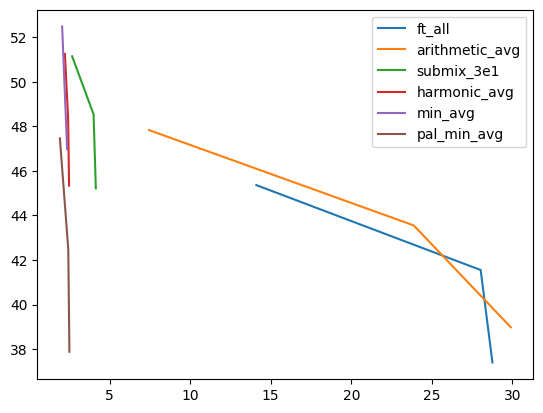

In [ ]:
from matplotlib import pyplot as plt
for r,v in res_m.items():
  plt.plot([x[0] for x in v], [x[1] for x in v], label=r)
plt.legend()
plt.show()

In [ ]:
df4

HOPPL_r  HOPPL_m  AUPPL_r  AUPPL_m  exp_99_true_r  \
experiment                                                          
ft_all            16.21    46.61    12.35    37.40            NaN   
arithmetic_avg    18.44    46.66    14.25    38.98         432.30   
submix_3e1        25.50    48.14    21.83    45.21           3.75   
harmonic_avg      19.70    48.64    16.46    45.34           2.66   
min_avg           20.54    49.89    17.35    46.97           2.05   
per_al            39.48    66.18    20.41    45.37            NaN   
pal_min_avg       21.62    52.14    13.38    37.88           2.04   

                exp_99_true_m  exp_max_true_r  exp_max_true_m  SPPL_r  \
experiment                                                              
ft_all                    NaN             NaN             NaN   11.96   
arithmetic_avg       72349.00      3491284.00    1.339514e+10   15.96   
submix_3e1              28.83         1385.00    8.525100e+04   46.01   
harmonic_avg             3.28            3.20    4.690000e+00   41.38   
min_avg                  2.74            2.65    3.940000e+00   49.73   
per_al                    NaN             NaN             NaN     NaN   
pal_min_avg              2.89            2.63    4.200000e+00   82.53   

                 SPPL_m  sia_roc_auc_r  sia_roc_auc_m  can_attack_score_30_r  \
experiment                                                                     
ft_all            23.94           0.83           0.86                  26.47   
arithmetic_avg    33.27           0.81           0.85                  28.67   
submix_3e1       377.20           0.75           0.82                   5.09   
harmonic_avg     823.10           0.64           0.67                   3.41   
min_avg         1059.00           0.61           0.65                   3.22   
per_al              NaN            NaN            NaN                    NaN   
pal_min_avg     1205.00           0.50           0.64                   2.49   

                can_attack_score_30_m  
experiment                             
ft_all                          28.76  
arithmetic_avg                  29.90  
submix_3e1                       4.15  
harmonic_avg                     2.49  
min_avg                          2.37  
per_al                            NaN  
pal_min_avg                      2.51

In [ ]:
df2

HOPPL_r  HOPPL_m  AUPPL_r  AUPPL_m  exp_99_true_r  \
experiment                                                          
ft_all            19.90    48.39    15.61    41.55            NaN   
arithmetic_avg    22.34    49.37    17.83    43.55         207.90   
submix_3e1        29.58    50.84    25.40    48.54           5.10   
harmonic_avg      23.57    50.83    20.09    48.37           2.38   
min_avg           24.54    51.89    21.14    49.79           1.77   
per_al            45.15    63.39    27.87    54.18            NaN   
pal_min_avg       25.19    52.22    16.85    42.48           1.78   

                exp_99_true_m  exp_max_true_r  exp_max_true_m  SPPL_r  \
experiment                                                              
ft_all                    NaN             NaN             NaN   15.31   
arithmetic_avg        1699.00       463986.00    1.433629e+08   19.78   
submix_3e1              17.36         1127.00    9.676000e+03   49.95   
harmonic_avg             2.84            2.88    3.910000e+00   50.87   
min_avg                  2.31            2.20    3.200000e+00   61.99   
per_al                    NaN             NaN             NaN     NaN   
pal_min_avg              2.37            2.23    3.270000e+00   74.00   

                 SPPL_m  sia_roc_auc_r  sia_roc_auc_m  can_attack_score_30_r  \
experiment                                                                     
ft_all            61.81           0.81           0.83                  14.47   
arithmetic_avg    78.93           0.82           0.82                  14.82   
submix_3e1       550.00           0.76           0.80                   4.73   
harmonic_avg     895.10           0.64           0.66                   3.49   
min_avg         1161.00           0.60           0.64                   3.21   
per_al              NaN            NaN            NaN                    NaN   
pal_min_avg     1127.00           0.54           0.62                   2.88   

                can_attack_score_30_m  
experiment                             
ft_all                          28.03  
arithmetic_avg                  23.88  
submix_3e1                       4.01  
harmonic_avg                     2.43  
min_avg                          2.21  
per_al                            NaN  
pal_min_avg                      2.44

In [ ]:
df1

HOPPL_r  HOPPL_m  AUPPL_r  AUPPL_m  exp_99_true_r  \
experiment                                                          
ft_all            23.77    50.34    19.19    45.36            NaN   
arithmetic_avg    27.04    52.03    22.29    47.83         159.90   
submix_3e1        32.01    52.85    27.80    51.14           7.83   
harmonic_avg      27.90    52.99    24.34    51.25           2.15   
min_avg           28.87    53.85    25.45    52.48           1.52   
per_al            52.72    63.61    38.49    61.42            NaN   
pal_min_avg       29.46    53.60    21.51    47.46           1.57   

                exp_99_true_m  exp_max_true_r  exp_max_true_m  SPPL_r  SPPL_m  \
experiment                                                                      
ft_all                    NaN             NaN             NaN   20.02   127.9   
arithmetic_avg         209.00        35579.00      5621951.00   26.66   186.9   
submix_3e1              12.48          904.70         3656.00   54.66   708.6   
harmonic_avg             2.44            2.48            3.20   55.57  1026.0   
min_avg                  1.89            1.83            2.52   67.25  1344.0   
per_al                    NaN             NaN             NaN     NaN     NaN   
pal_min_avg              1.93            1.83            2.59   72.09  1271.0   

                sia_roc_auc_r  sia_roc_auc_m  can_attack_score_30_r  \
experiment                                                            
ft_all                   0.80           0.80                   5.99   
arithmetic_avg           0.79           0.79                   4.62   
submix_3e1               0.74           0.77                   3.21   
harmonic_avg             0.62           0.66                   2.82   
min_avg                  0.58           0.63                   2.56   
per_al                    NaN            NaN                    NaN   
pal_min_avg              0.53           0.62                   2.13   

                can_attack_score_30_m  
experiment                             
ft_all                          14.11  
arithmetic_avg                   7.45  
submix_3e1                       2.68  
harmonic_avg                     2.23  
min_avg                          2.06  
per_al                            NaN  
pal_min_avg                      1.92